# Problem Statement

As someone aspiring to become a data scientist, I am working on a case study to address a critical challenge in the ride-sharing industry: recruiting and retaining drivers. Driver churn is a persistent issue, with many drivers leaving suddenly or switching to competitors based on changing rates.

In a growing organization, high churn rates can escalate into significant problems. While expanding hiring criteria to include individuals without vehicles can help bring in new drivers, it comes with high acquisition costs. Frequent driver turnover disrupts operations, impacts morale, and makes acquiring new drivers much more expensive than retaining the existing ones.

For this case study, I am working with monthly driver data from 2019 and 2020 to predict whether a driver is likely to leave the organization. The dataset includes key attributes such as:

- **Demographics**: Information like city, age, gender, etc.  
- **Tenure Information**: Joining date and last working date.  
- **Historical Performance Data**: Quarterly ratings, monthly business metrics, grades, and income.  

The objective is to analyze patterns, build a predictive model, and gain insights into how driver attrition can be reduced. This exercise not only enhances my technical skills but also provides valuable experience in solving real-world business problems.

In [394]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")

# Observations on Data

In [395]:
df = pd.read_csv('data.csv')
df=pd.read_csv('data.csv', usecols=lambda column: column != df.columns[0])
df

MMM-YY  Driver_ID   Age  Gender City  Education_Level  Income  \
0      01/01/19          1  28.0     0.0  C23                2   57387   
1      02/01/19          1  28.0     0.0  C23                2   57387   
2      03/01/19          1  28.0     0.0  C23                2   57387   
3      11/01/20          2  31.0     0.0   C7                2   67016   
4      12/01/20          2  31.0     0.0   C7                2   67016   
...         ...        ...   ...     ...  ...              ...     ...   
19099  08/01/20       2788  30.0     0.0  C27                2   70254   
19100  09/01/20       2788  30.0     0.0  C27                2   70254   
19101  10/01/20       2788  30.0     0.0  C27                2   70254   
19102  11/01/20       2788  30.0     0.0  C27                2   70254   
19103  12/01/20       2788  30.0     0.0  C27                2   70254   

      Dateofjoining LastWorkingDate  Joining Designation  Grade  \
0          24/12/18             NaN                    1      1   
1          24/12/18             NaN                    1      1   
2          24/12/18        03/11/19                    1      1   
3          11/06/20             NaN                    2      2   
4          11/06/20             NaN                    2      2   
...             ...             ...                  ...    ...   
19099      06/08/20             NaN                    2      2   
19100      06/08/20             NaN                    2      2   
19101      06/08/20             NaN                    2      2   
19102      06/08/20             NaN                    2      2   
19103      06/08/20             NaN                    2      2   

       Total Business Value  Quarterly Rating  
0                   2381060                 2  
1                   -665480                 2  
2                         0                 2  
3                         0                 1  
4                         0                 1  
...                     ...               ...  
19099                740280                 3  
19100                448370                 3  
19101                     0                 2  
19102                200420                 2  
19103                411480                 2  

[19104 rows x 13 columns]

In [396]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19104 entries, 0 to 19103
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   MMM-YY                19104 non-null  object 
 1   Driver_ID             19104 non-null  int64  
 2   Age                   19043 non-null  float64
 3   Gender                19052 non-null  float64
 4   City                  19104 non-null  object 
 5   Education_Level       19104 non-null  int64  
 6   Income                19104 non-null  int64  
 7   Dateofjoining         19104 non-null  object 
 8   LastWorkingDate       1616 non-null   object 
 9   Joining Designation   19104 non-null  int64  
 10  Grade                 19104 non-null  int64  
 11  Total Business Value  19104 non-null  int64  
 12  Quarterly Rating      19104 non-null  int64  
dtypes: float64(2), int64(7), object(4)
memory usage: 1.9+ MB


#### Column Profiling
1. **MMMM-YY**: Reporting Date (Monthly)
   - The month and year of reporting in the format MMMM-YY (e.g., Jan-22, Feb-22).
2. **Driver_ID**: Unique ID for drivers
   - A unique identifier assigned to each driver.
3. **Age**: Age of the driver
   - The age of the driver as a numeric value.
4. **Gender**: Gender of the driver
   - Male: 0, Female: 1
5. **City**: City Code of the driver
   - A code representing the city where the driver is located.
6. **Education_Level**: Education level of the driver
   - 0: 10th grade or below
   - 1: 12th grade
   - 2: Graduate
7. **Income**: Monthly average income of the driver
   - The average monthly income of the driver as a numeric value.
8. **Date Of Joining**: Joining date of the driver
   - The date when the driver joined the platform.
9. **LastWorkingDate**: Last date of working for the driver
   - The last date the driver worked or was active on the platform.
10. **Joining Designation**: Designation of the driver at the time of joining
    - The role or position assigned to the driver when they joined.
11. **Grade**: Grade of the driver at the time of reporting
    - The grade assigned to the driver during the reporting period.
12. **Total Business Value**: Total business value acquired by the driver in a month
    - Represents the total value of business conducted by the driver in a given month. 
    - A negative value indicates cancellations, refunds, or car EMI adjustments.
13. **Quarterly Rating**: Quarterly rating of the driver
    - A rating given to the driver on a scale of 1 to 5, where a higher value indicates better performance.

It looks like dates are not formatted correctly so it will be better to correct it.

In [397]:
df["MMM-YY"] = pd.to_datetime(df["MMM-YY"], format="%m/%d/%y")

In [398]:
df["Dateofjoining"] = pd.to_datetime(df["Dateofjoining"], format="%d/%m/%y", errors='coerce')

In [399]:
df["LastWorkingDate"] = pd.to_datetime(df["LastWorkingDate"], format="%d/%m/%y", errors='coerce')

In [400]:
df.head(3)

MMM-YY  Driver_ID   Age  Gender City  Education_Level  Income  \
0 2019-01-01          1  28.0     0.0  C23                2   57387   
1 2019-02-01          1  28.0     0.0  C23                2   57387   
2 2019-03-01          1  28.0     0.0  C23                2   57387   

  Dateofjoining LastWorkingDate  Joining Designation  Grade  \
0    2018-12-24             NaT                    1      1   
1    2018-12-24             NaT                    1      1   
2    2018-12-24      2019-11-03                    1      1   

   Total Business Value  Quarterly Rating  
0               2381060                 2  
1               -665480                 2  
2                     0                 2

In [401]:
df.shape

(19104, 13)

In [402]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19104 entries, 0 to 19103
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   MMM-YY                19104 non-null  datetime64[ns]
 1   Driver_ID             19104 non-null  int64         
 2   Age                   19043 non-null  float64       
 3   Gender                19052 non-null  float64       
 4   City                  19104 non-null  object        
 5   Education_Level       19104 non-null  int64         
 6   Income                19104 non-null  int64         
 7   Dateofjoining         19104 non-null  datetime64[ns]
 8   LastWorkingDate       1616 non-null   datetime64[ns]
 9   Joining Designation   19104 non-null  int64         
 10  Grade                 19104 non-null  int64         
 11  Total Business Value  19104 non-null  int64         
 12  Quarterly Rating      19104 non-null  int64         
dtypes: datetime64[ns

In [403]:
df.isnull().sum()

MMM-YY                      0
Driver_ID                   0
Age                        61
Gender                     52
City                        0
Education_Level             0
Income                      0
Dateofjoining               0
LastWorkingDate         17488
Joining Designation         0
Grade                       0
Total Business Value        0
Quarterly Rating            0
dtype: int64

In [404]:
df.Age.isnull().sum()

np.int64(61)

In [405]:
df[df.Age.isnull()]

MMM-YY  Driver_ID  Age  Gender City  Education_Level  Income  \
72    2020-02-01         20  NaN     1.0  C19                0   40342   
97    2019-10-01         22  NaN     0.0  C10                2   31224   
110   2019-07-01         24  NaN     0.0  C24                2   76308   
212   2019-11-01         40  NaN     0.0  C15                0   59182   
261   2019-05-01         49  NaN     0.0  C20                0   53039   
...          ...        ...  ...     ...  ...              ...     ...   
18395 2020-05-01       2690  NaN     0.0  C11                2   77662   
18722 2020-08-01       2730  NaN     1.0  C16                2   69924   
18780 2019-03-01       2738  NaN     0.0  C17                0   23068   
18843 2019-01-01       2751  NaN     0.0  C17                2   53115   
19024 2019-02-01       2774  NaN     0.0  C15                1   42313   

      Dateofjoining LastWorkingDate  Joining Designation  Grade  \
72       2019-10-25             NaT                    3      3   
97       2018-05-25             NaT                    1      1   
110      2018-05-25             NaT                    1      2   
212      2019-08-11             NaT                    2      2   
261      2018-05-25             NaT                    1      2   
...             ...             ...                  ...    ...   
18395    2018-07-17             NaT                    1      2   
18722    2019-08-07             NaT                    2      2   
18780    2018-08-09             NaT                    1      1   
18843    2015-05-11             NaT                    1      1   
19024    2018-07-21             NaT                    1      1   

       Total Business Value  Quarterly Rating  
72                        0                 1  
97                   200000                 3  
110                  203240                 3  
212                       0                 1  
261                  124190                 1  
...                     ...               ...  
18395                692600                 4  
18722                161860                 2  
18780                639780                 3  
18843                506550                 3  
19024               1141280                 4  

[61 rows x 13 columns]

In [406]:
df[df.Driver_ID==20]

MMM-YY  Driver_ID   Age  Gender City  Education_Level  Income  \
68 2019-10-01         20  26.0     1.0  C19                0   40342   
69 2019-11-01         20  26.0     1.0  C19                0   40342   
70 2019-12-01         20  26.0     1.0  C19                0   40342   
71 2020-01-01         20  26.0     1.0  C19                0   40342   
72 2020-02-01         20   NaN     1.0  C19                0   40342   
73 2020-03-01         20  26.0     1.0  C19                0   40342   

   Dateofjoining LastWorkingDate  Joining Designation  Grade  \
68    2019-10-25             NaT                    3      3   
69    2019-10-25             NaT                    3      3   
70    2019-10-25             NaT                    3      3   
71    2019-10-25             NaT                    3      3   
72    2019-10-25             NaT                    3      3   
73    2019-10-25      2020-01-03                    3      3   

    Total Business Value  Quarterly Rating  
68                     0                 1  
69                     0                 1  
70                     0                 1  
71                     0                 1  
72                     0                 1  
73                     0                 1

As the Driver_ID is unique for all the driver and there are rows where certain columns are null for the same driver but in other columns data is there, so it is better to populate those columns using already existing values

In [407]:
df = df.groupby('Driver_ID').apply(lambda group: group.ffill().bfill())
df = df.reset_index(drop=True)
df

MMM-YY  Driver_ID   Age  Gender City  Education_Level  Income  \
0     2019-01-01          1  28.0     0.0  C23                2   57387   
1     2019-02-01          1  28.0     0.0  C23                2   57387   
2     2019-03-01          1  28.0     0.0  C23                2   57387   
3     2020-11-01          2  31.0     0.0   C7                2   67016   
4     2020-12-01          2  31.0     0.0   C7                2   67016   
...          ...        ...   ...     ...  ...              ...     ...   
19099 2020-08-01       2788  30.0     0.0  C27                2   70254   
19100 2020-09-01       2788  30.0     0.0  C27                2   70254   
19101 2020-10-01       2788  30.0     0.0  C27                2   70254   
19102 2020-11-01       2788  30.0     0.0  C27                2   70254   
19103 2020-12-01       2788  30.0     0.0  C27                2   70254   

      Dateofjoining LastWorkingDate  Joining Designation  Grade  \
0        2018-12-24      2019-11-03                    1      1   
1        2018-12-24      2019-11-03                    1      1   
2        2018-12-24      2019-11-03                    1      1   
3        2020-06-11             NaT                    2      2   
4        2020-06-11             NaT                    2      2   
...             ...             ...                  ...    ...   
19099    2020-08-06             NaT                    2      2   
19100    2020-08-06             NaT                    2      2   
19101    2020-08-06             NaT                    2      2   
19102    2020-08-06             NaT                    2      2   
19103    2020-08-06             NaT                    2      2   

       Total Business Value  Quarterly Rating  
0                   2381060                 2  
1                   -665480                 2  
2                         0                 2  
3                         0                 1  
4                         0                 1  
...                     ...               ...  
19099                740280                 3  
19100                448370                 3  
19101                     0                 2  
19102                200420                 2  
19103                411480                 2  

[19104 rows x 13 columns]

Note for coding:
- Group by Driver_ID: This ensures that operations are performed within each group corresponding to the same Driver_ID.
- ffill and bfill:
    - ffill() propagates the last valid observation forward.
    - bfill() propagates the next valid observation backward. Combining these ensures all NaN values within the group are filled with valid values from the same group.
- Reset Index: If grouping alters the DataFrame structure, resetting the index ensures consistency.

In [408]:
df.isnull().sum()

MMM-YY                     0
Driver_ID                  0
Age                        0
Gender                     0
City                       0
Education_Level            0
Income                     0
Dateofjoining              0
LastWorkingDate         8745
Joining Designation        0
Grade                      0
Total Business Value       0
Quarterly Rating           0
dtype: int64

In the LastWorkingDate, there are nulls so we can assume that those drivers are still working.

Aggregating on the Driver_ID column can provide insights into drivers' consistent behaviors or patterns over time. Here's an example Python code snippet demonstrating how to use mean, sum, or nunique to aggregate key metrics

In [409]:
df = df.groupby('Driver_ID').agg({
    'Age': 'mean',                     
    'Gender': 'unique',                
    'City': 'unique',                  
    'Education_Level': 'unique',       
    'Income': 'mean',                  
    'Dateofjoining': 'min',            
    'LastWorkingDate': 'max',          
    'Joining Designation': 'unique',   
    'Grade': 'unique',                   
    'Total Business Value': 'sum',     
    'Quarterly Rating': 'mean'         
})
df = df.reset_index()
df

Driver_ID        Age Gender   City Education_Level   Income  \
0             1  28.000000  [0.0]  [C23]             [2]  57387.0   
1             2  31.000000  [0.0]   [C7]             [2]  67016.0   
2             4  43.000000  [0.0]  [C13]             [2]  65603.0   
3             5  29.000000  [0.0]   [C9]             [0]  46368.0   
4             6  31.000000  [1.0]  [C11]             [1]  78728.0   
...         ...        ...    ...    ...             ...      ...   
2376       2784  33.500000  [0.0]  [C24]             [0]  82815.0   
2377       2785  34.000000  [1.0]   [C9]             [0]  12105.0   
2378       2786  44.888889  [0.0]  [C19]             [0]  35370.0   
2379       2787  28.000000  [1.0]  [C20]             [2]  69498.0   
2380       2788  29.857143  [0.0]  [C27]             [2]  70254.0   

     Dateofjoining LastWorkingDate Joining Designation Grade  \
0       2018-12-24      2019-11-03                 [1]   [1]   
1       2020-06-11             NaT                 [2]   [2]   
2       2019-07-12      2020-04-27                 [2]   [2]   
3       2019-09-01      2019-07-03                 [1]   [1]   
4       2020-07-31             NaT                 [3]   [3]   
...            ...             ...                 ...   ...   
2376    2015-10-15             NaT                 [2]   [3]   
2377    2020-08-28      2020-10-28                 [1]   [1]   
2378    2018-07-31      2019-09-22                 [2]   [2]   
2379    2018-07-21      2019-06-20                 [1]   [1]   
2380    2020-08-06             NaT                 [2]   [2]   

      Total Business Value  Quarterly Rating  
0                  1715580          2.000000  
1                        0          1.000000  
2                   350000          1.000000  
3                   120360          1.000000  
4                  1265000          1.600000  
...                    ...               ...  
2376              21748820          2.625000  
2377                     0          1.000000  
2378               2815090          1.666667  
2379                977830          1.500000  
2380               2298240          2.285714  

[2381 rows x 12 columns]

In [410]:
df.shape

(2381, 12)

In [411]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2381 entries, 0 to 2380
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Driver_ID             2381 non-null   int64         
 1   Age                   2381 non-null   float64       
 2   Gender                2381 non-null   object        
 3   City                  2381 non-null   object        
 4   Education_Level       2381 non-null   object        
 5   Income                2381 non-null   float64       
 6   Dateofjoining         2381 non-null   datetime64[ns]
 7   LastWorkingDate       1616 non-null   datetime64[ns]
 8   Joining Designation   2381 non-null   object        
 9   Grade                 2381 non-null   object        
 10  Total Business Value  2381 non-null   int64         
 11  Quarterly Rating      2381 non-null   float64       
dtypes: datetime64[ns](2), float64(3), int64(2), object(5)
memory usage: 223.3+ K

In [412]:
df.isnull().sum()

Driver_ID                 0
Age                       0
Gender                    0
City                      0
Education_Level           0
Income                    0
Dateofjoining             0
LastWorkingDate         765
Joining Designation       0
Grade                     0
Total Business Value      0
Quarterly Rating          0
dtype: int64

As mentioned earlier, the null values in LastWorkingDate are still working or not churned drivers

In [413]:
df.describe(include=['object'])

Gender   City Education_Level Joining Designation Grade
count    2381   2381            2381                2381  2381
unique      2     29               3                   5    49
top     [0.0]  [C20]             [2]                 [1]   [2]
freq     1404    152             802                1026   844

In [414]:
df.describe()

Driver_ID          Age         Income                  Dateofjoining  \
count  2381.000000  2381.000000    2381.000000                           2381   
mean   1397.559009    33.369155   59232.460484  2019-01-27 12:58:58.009239808   
min       1.000000    21.000000   10747.000000            2013-01-04 00:00:00   
25%     695.000000    29.000000   39104.000000            2018-06-26 00:00:00   
50%    1400.000000    33.000000   55285.000000            2019-06-23 00:00:00   
75%    2100.000000    37.000000   75835.000000            2020-04-14 00:00:00   
max    2788.000000    58.000000  188418.000000            2020-12-28 00:00:00   
std     806.161628     5.890611   28298.214012                            NaN   

                     LastWorkingDate  Total Business Value  Quarterly Rating  
count                           1616          2.381000e+03       2381.000000  
mean   2019-12-26 23:22:34.455445760          4.586742e+06          1.566304  
min              2018-12-31 00:00:00         -1.385530e+06          1.000000  
25%              2019-06-10 00:00:00          0.000000e+00          1.000000  
50%              2019-12-20 12:00:00          8.176800e+05          1.000000  
75%              2020-07-14 00:00:00          4.173650e+06          2.000000  
max              2020-12-28 00:00:00          9.533106e+07          4.000000  
std                              NaN          9.127115e+06          0.719652

#### Analysis
- Age
    - Mean Age: 33.36 years
    - Min Age: 21 years
    - Max Age: 58 years
    - Standard Deviation: 5.59 years (indicating a moderately spread-out age range).
- Income
    - Mean Income: 59,324 (monthly average income).
    - Min Income: 10,747 (potentially part-time drivers or new joiners).
    - Max Income: 188,418 (likely top performers or drivers in high-demand areas).
    - Std Dev: 28,929 (indicates wide income variability among drivers).
- Total Business Value
    - Mean Value: 4,586,742 (likely inflated by outliers as the range spans from negative to very high values).
    - Min Value: -1,385,530 (indicates cancellations, refunds, or adjustments).
    - Max Value: 95,331,060 (indicating exceptional performance).
    - The negative values suggest the need to assess cancellation patterns or refunds more closely.
- Quarterly Rating
    - Mean Rating: 1.56 out of 5.
    - Min Rating: 1 (lowest performance).
    - Max Rating: 4 (no one received the highest score of 5, which may indicate strict rating criteria).
    - Ratings appear skewed towards lower scores.
- Grade
    - Unique Grades: 49 unique values.
    - Most Frequent Grade (Top): 2, with 844 occurrences. This suggests that a significant number of drivers are concentrated at this grade.
- Gender
    - Unique Values: 2 (0: Male, 1: Female).
    - Top Value: Male (1404 entries or 59% of the data).
- City
    - Unique Values: 29 city codes.
    - Top City: C20 (152 drivers or 6.4%).
- Education_Level
    - Unique Values: 3 (0: Below 10th grade, 1: 12th grade, 2: Graduate).
    - Top Education Level: Graduate (802 entries or 33.7%).
- Joining Designation
    - Unique Values: 5 roles.
    - Top Designation: Most common is 1 (1026 drivers).
#### Insights
- **Active vs. Inactive Drivers:** Around 32% of drivers (765/2381) are still active on the platform. The rest have a LastWorkingDate, suggesting they left or became inactive.
- **Income Variability:** There is significant income disparity among drivers. Understanding factors like location, hours worked, or business value could help optimize income distribution.
- **Performance (Quarterly Rating):** The average quarterly rating is low (1.56 out of 5). Investigating reasons for underperformance and implementing support/training programs could improve ratings.
- **Education Level:** Most drivers are graduates, which may suggest a higher likelihood of tech-savvy individuals or those adaptable to digital platforms.
- **City Concentration:** While 29 cities are represented, the top city (C20) accounts for only 6.4% of drivers, suggesting a fairly balanced geographical spread.
- **Cancellations and Refunds:** Negative values in Total Business Value highlight a need to monitor and reduce cancellations or refunds.

# Univariate Analysis

In [415]:
df.head()

Driver_ID   Age Gender   City Education_Level   Income Dateofjoining  \
0          1  28.0  [0.0]  [C23]             [2]  57387.0    2018-12-24   
1          2  31.0  [0.0]   [C7]             [2]  67016.0    2020-06-11   
2          4  43.0  [0.0]  [C13]             [2]  65603.0    2019-07-12   
3          5  29.0  [0.0]   [C9]             [0]  46368.0    2019-09-01   
4          6  31.0  [1.0]  [C11]             [1]  78728.0    2020-07-31   

  LastWorkingDate Joining Designation Grade  Total Business Value  \
0      2019-11-03                 [1]   [1]               1715580   
1             NaT                 [2]   [2]                     0   
2      2020-04-27                 [2]   [2]                350000   
3      2019-07-03                 [1]   [1]                120360   
4             NaT                 [3]   [3]               1265000   

   Quarterly Rating  
0               2.0  
1               1.0  
2               1.0  
3               1.0  
4               1.6

In [416]:
df.select_dtypes(include=['int64', 'float64']).columns.tolist()

['Driver_ID', 'Age', 'Income', 'Total Business Value', 'Quarterly Rating']

In [417]:
[col for col in df.select_dtypes(include=['int64', 'float64']).columns if col != 'Driver_ID']

['Age', 'Income', 'Total Business Value', 'Quarterly Rating']

In [418]:
df.select_dtypes(include=['object', 'category']).columns.tolist()

['Gender', 'City', 'Education_Level', 'Joining Designation', 'Grade']

Column name: Gender and it contains 
 Gender
[0.0]    1404
[1.0]     977
Name: count, dtype: int64


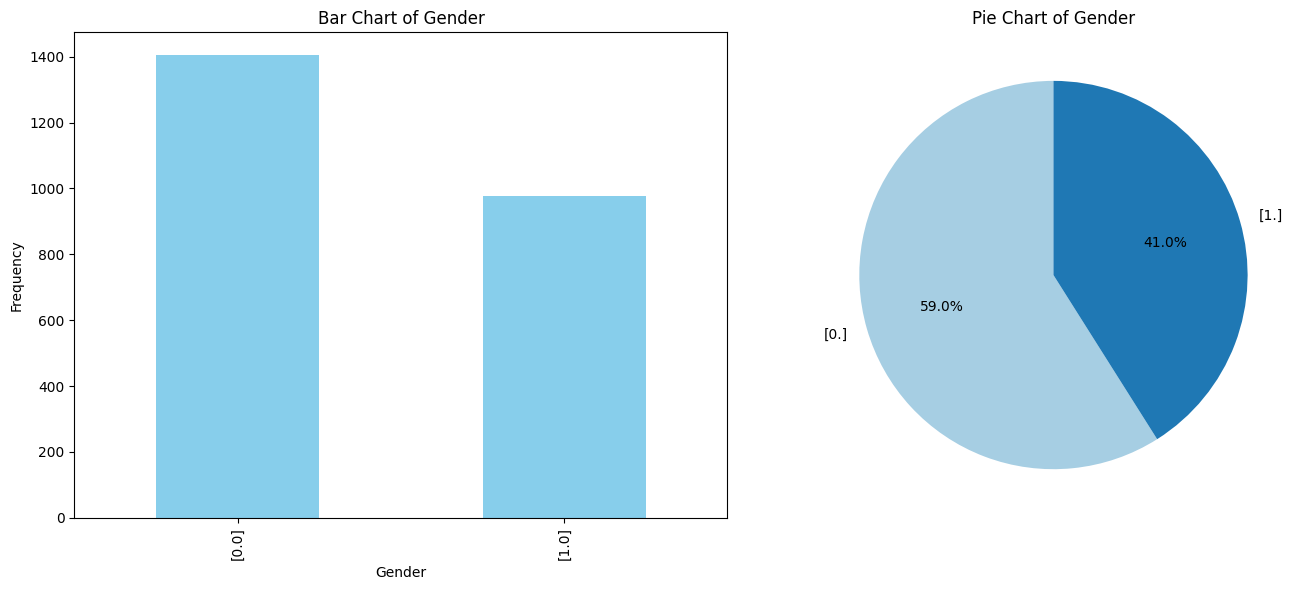

Column name: City and it contains 
 City
[C20]    152
[C15]    101
[C29]     96
[C26]     93
[C27]     89
[C8]      89
[C10]     86
[C16]     84
[C3]      82
[C22]     82
[C28]     82
[C12]     81
[C1]      80
[C5]      80
[C14]     79
[C21]     79
[C6]      78
[C4]      77
[C7]      76
[C9]      75
[C23]     74
[C25]     74
[C24]     73
[C19]     72
[C2]      72
[C13]     71
[C17]     71
[C18]     69
[C11]     64
Name: count, dtype: int64


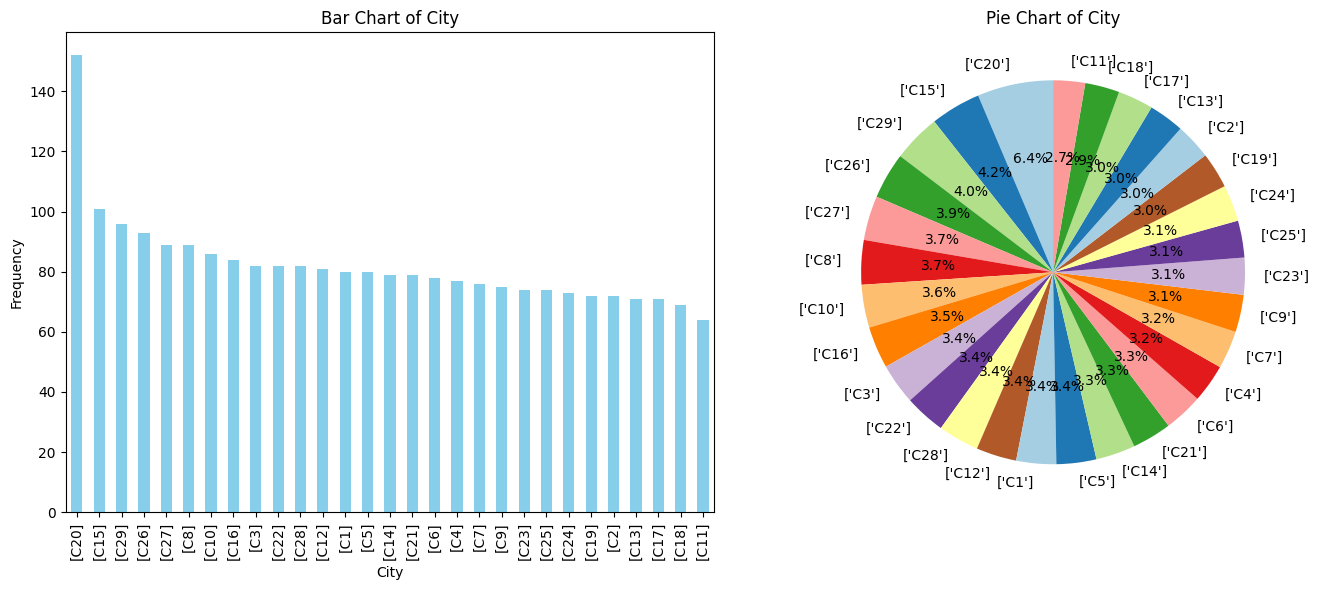

Column name: Education_Level and it contains 
 Education_Level
[2]    802
[1]    795
[0]    784
Name: count, dtype: int64


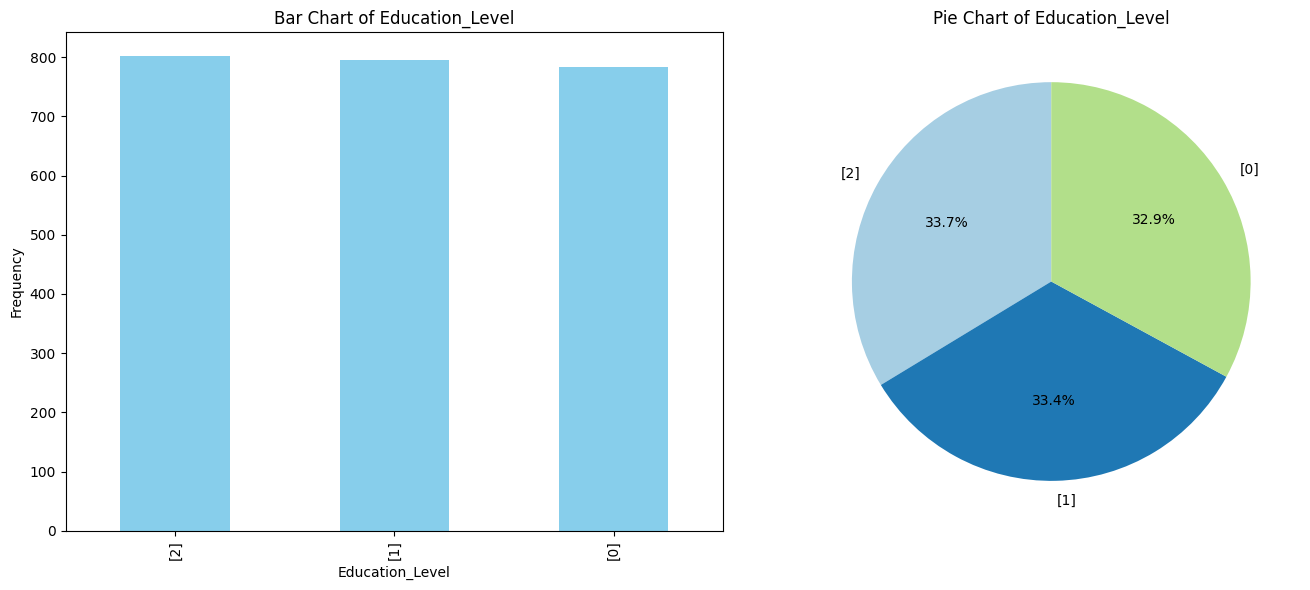

Column name: Joining Designation and it contains 
 Joining Designation
[1]    1026
[2]     815
[3]     493
[4]      36
[5]      11
Name: count, dtype: int64


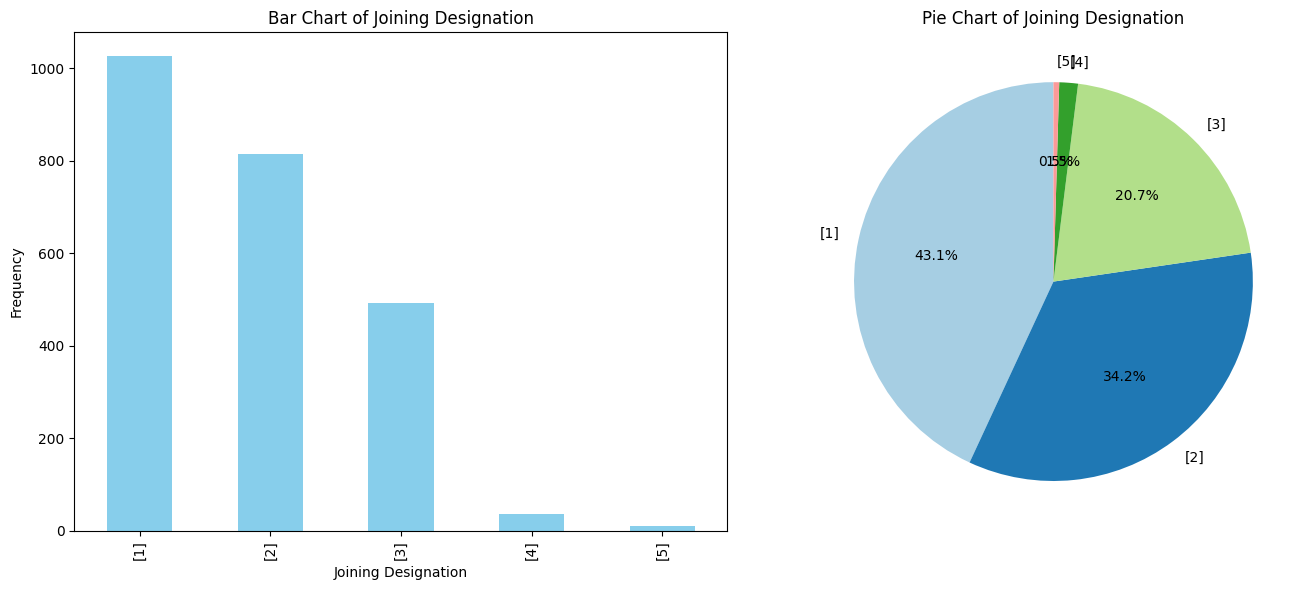

Column name: Grade and it contains 
 Grade
[2]       844
[1]       741
[3]       602
[4]       129
[5]        21
[3, 4]      1
[4, 5]      1
[3, 4]      1
[2, 3]      1
[3, 4]      1
[3, 4]      1
[1, 2]      1
[1, 2]      1
[2, 3]      1
[2, 3]      1
[3, 4]      1
[1, 2]      1
[2, 3]      1
[4, 5]      1
[2, 3]      1
[2, 3]      1
[1, 2]      1
[2, 3]      1
[1, 2]      1
[2, 3]      1
[2, 3]      1
[2, 3]      1
[1, 2]      1
[3, 4]      1
[2, 3]      1
[1, 2]      1
[3, 4]      1
[2, 3]      1
[2, 3]      1
[2, 3]      1
[2, 3]      1
[4, 5]      1
[2, 3]      1
[1, 2]      1
[3, 4]      1
[2, 3]      1
[2, 3]      1
[2, 3]      1
[1, 2]      1
[1, 2]      1
[2, 3]      1
[3, 4]      1
[2, 3]      1
[2, 3]      1
Name: count, dtype: int64


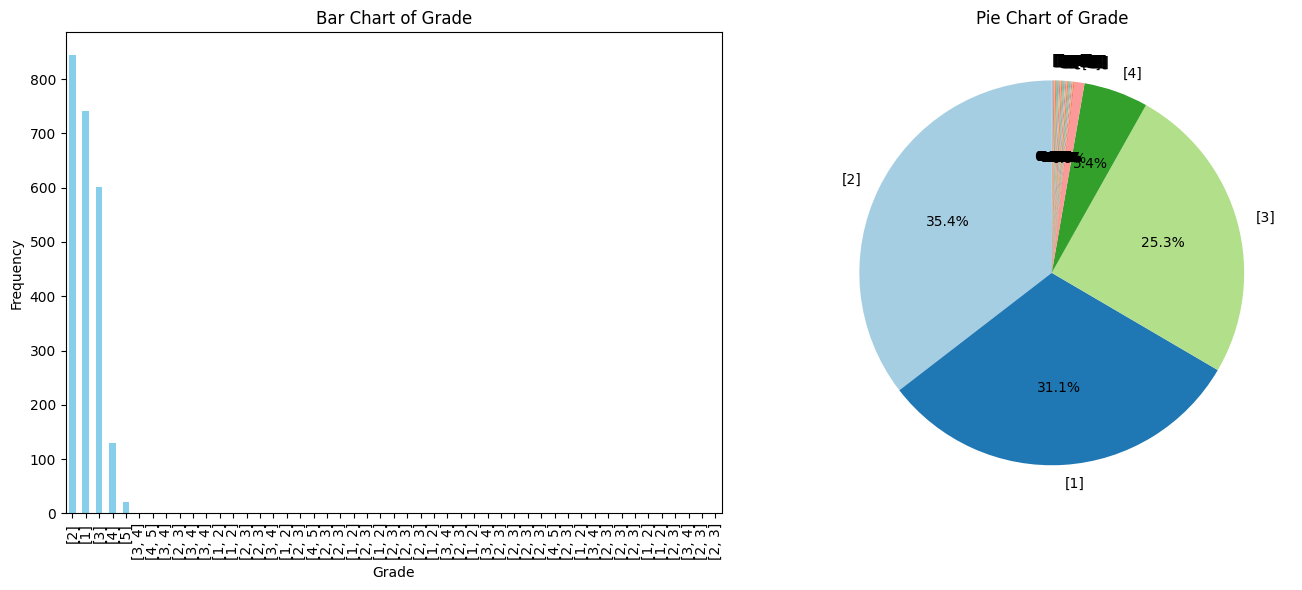

In [419]:
for i in df.select_dtypes(include=['object', 'category']).columns.tolist():
    print(f'Column name: {i} and it contains \n {df[i].value_counts()}')
    if len(df[i].value_counts()) > 50:
        print(f"\033[1mToo many values to plot bar and pie chart for column '{i}'\033[0m \n\n")
        continue
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    df[i].value_counts().plot(kind='bar', ax=axes[0], color='skyblue')
    axes[0].set_title(f'Bar Chart of {i}')
    axes[0].set_xlabel(i)
    axes[0].set_ylabel('Frequency')
    pie_data = df[i].value_counts()
    axes[1].pie(pie_data, labels=pie_data.index, autopct='%1.1f%%', startangle=90, colors=plt.cm.Paired.colors)
    axes[1].set_title(f'Pie Chart of {i}')
    plt.tight_layout()
    plt.show()

#### Analysis of Categorical Columns:
1. Gender
- Distribution:
    - **Male (0):** 59% (1404 drivers).
    - **Female (1):** 41% (977 drivers).
- Insights:
    - There is a noticeable gender gap, with males forming the majority of the workforce. This may indicate an opportunity to attract and empower more female drivers.
    - Gender diversity programs could be considered to balance the distribution.
2. City
- Top 3 Cities by Driver Count:
    - **C20:** 152 drivers (6.4%).
    - **C15:** 101 drivers (4.2%).
    - **C29:** 96 drivers (4.0%).
- Insights:
    - The driver distribution is relatively even across 29 cities, with no single city dominating.
    - High-performing cities (e.g., based on income or business value) should be further analyzed for best practices.
    - Smaller cities may represent growth opportunities for driver recruitment.
3. Education Level
- Distribution:
    - **Graduate (2):** 33.7% (802 drivers).
    - **12th Grade (1):** 33.4% (795 drivers).
    - **10th Grade or Below (0):** 32.9% (784 drivers).
- Insights:
    - The workforce is almost equally distributed across education levels.
    - A high percentage of graduates indicates that drivers may be adaptable to digital tools and technology.
    - For those with lower education levels, targeted training programs could help enhance performance.
4. Joining Designation
- Distribution:
    - **Designation 1:** 43.1% (1026 drivers).
    - **Designation 2:** 34.2% (815 drivers).
    - **Designation 3:** 20.7% (493 drivers).
    - **Designations 4 and 5:** Minimal representation (<2%).
- Insights:
    - Designation 1 is the most common joining role, which may represent an entry-level position.
    - Drivers in Designations 4 and 5 may represent specialized or senior roles. Understanding the progression from Designation 1 to higher levels can help design career growth paths.
5. Grade
- Distribution:
    - **Grade 2:** 35.4% (844 drivers).
    - **Grade 1:** 31.1% (741 drivers).
    - **Grade 3:** 25.3% (602 drivers).
    - **Grades 4 and 5:** Account for only **6.3% combined**.
    - The remaining grades are sparsely populated with individual entries.
- Insights:
    - The majority of drivers are clustered around Grades 1, 2, and 3, with fewer drivers achieving higher grades (4 or 5).
    - This distribution could indicate that reaching higher grades is challenging or reserved for exceptional performers.
    - Identifying factors contributing to higher grades (e.g., consistent income, fewer cancellations) could provide actionable insights to uplift more drivers to top grades.


--------------------------------------------------
Analysis for Column: Age
--------------------------------------------------
Skewness: 0.5304
Kurtosis: 0.1508

Top 10 value counts:
Age
32.0    121
31.0     99
34.0     89
30.0     88
33.0     86
29.0     84
36.0     78
35.0     75
28.0     73
27.0     67
Name: count, dtype: int64

Bottom 10 value counts:
Age
32.800000    1
27.545455    1
41.250000    1
32.636364    1
38.100000    1
31.307692    1
29.363636    1
45.842105    1
39.769231    1
33.266667    1
Name: count, dtype: int64

Z-scores (First 10 values):
[-0.91166832 -0.40227627  1.63529193 -0.74187097 -0.40227627  0.10711578
 -0.91166832  0.27691313 -0.63851606  0.95610253]

IQR value is 8.0
Upper Limit/Bound: 49.0
Lower Limit/Bound: 17.0
Number of rows which are outliners are 23



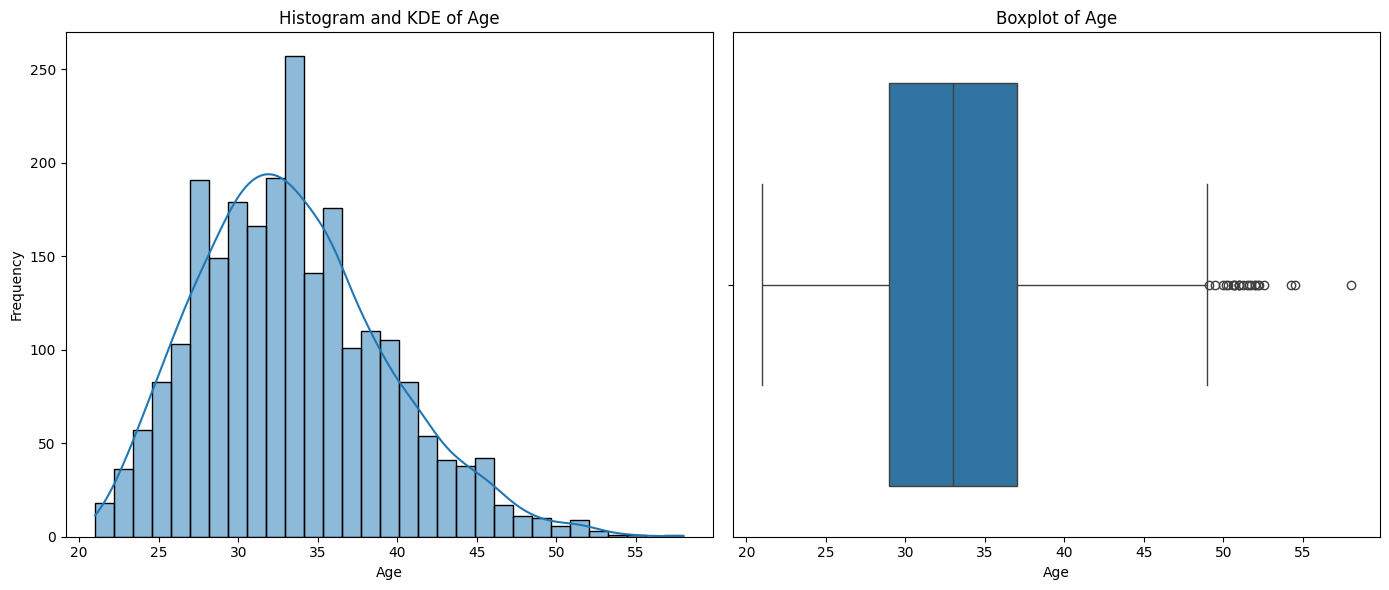


--------------------------------------------------
Analysis for Column: Income
--------------------------------------------------
Skewness: 0.7776
Kurtosis: 0.4564

Top 10 value counts:
Income
48747.0    3
41591.0    2
33721.0    2
49664.0    2
77903.0    2
64128.0    2
48097.0    2
83969.0    2
63181.0    2
12456.0    2
Name: count, dtype: int64

Bottom 10 value counts:
Income
19734.000000     1
52682.000000     1
51099.000000     1
31631.000000     1
40342.000000     1
22755.000000     1
31224.000000     1
76308.000000     1
102077.000000    1
126132.333333    1
Name: count, dtype: int64

Z-scores (First 10 values):
[-0.06522843  0.27511187  0.2251689  -0.45469876  0.68907652  0.40376891
 -0.60300782 -1.09982195  2.12052754 -1.39608661]

IQR value is 36731.0
Upper Limit/Bound: 130931.5
Lower Limit/Bound: -15992.5
Number of rows which are outliners are 47



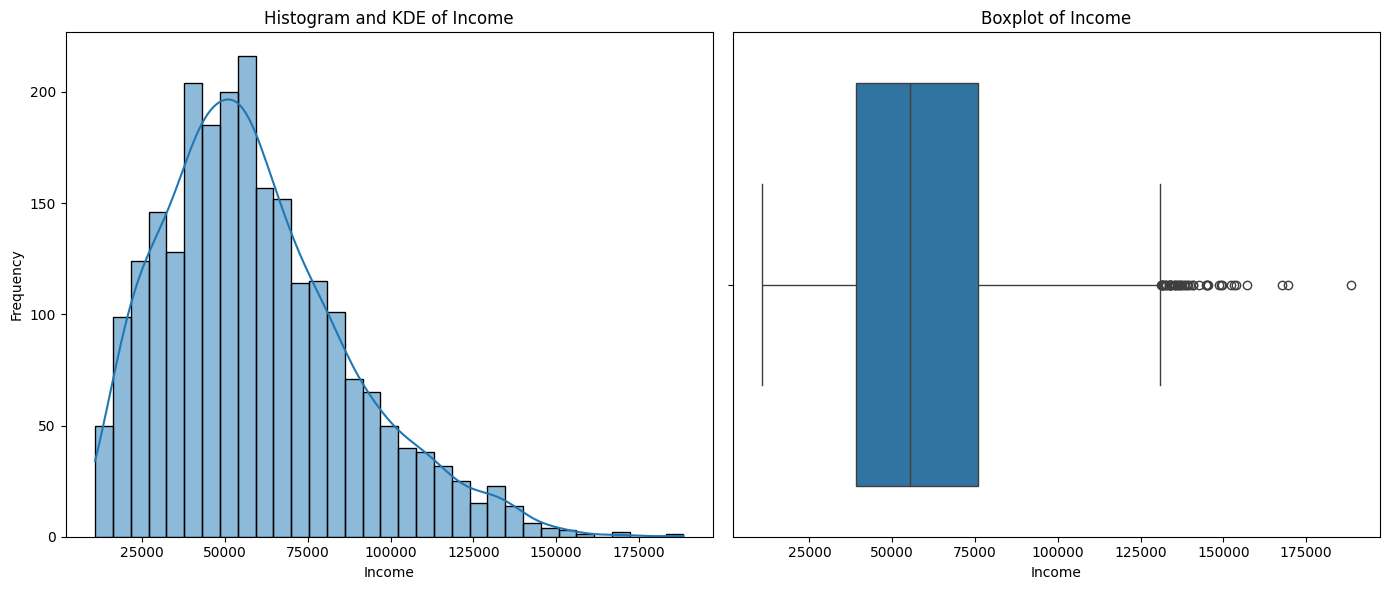


--------------------------------------------------
Analysis for Column: Total Business Value
--------------------------------------------------
Skewness: 3.3613
Kurtosis: 14.6539

Top 10 value counts:
Total Business Value
0         719
200000     10
250000      6
350000      5
600000      4
400000      3
500000      3
300000      3
116400      2
101850      2
Name: count, dtype: int64

Bottom 10 value counts:
Total Business Value
5945900     1
20843460    1
1834440     1
116940      1
3140390     1
1038200     1
61583040    1
5735920     1
1354530     1
69867900    1
Name: count, dtype: int64

Z-scores (First 10 values):
[-0.31464103 -0.50264571 -0.46429038 -0.48945586 -0.36401858 -0.50264571
 -0.50264571 -0.21693356  0.61656721 -0.50264571]

IQR value is 4173650.0
Upper Limit/Bound: 10434125.0
Lower Limit/Bound: -6260475.0
Number of rows which are outliners are 336



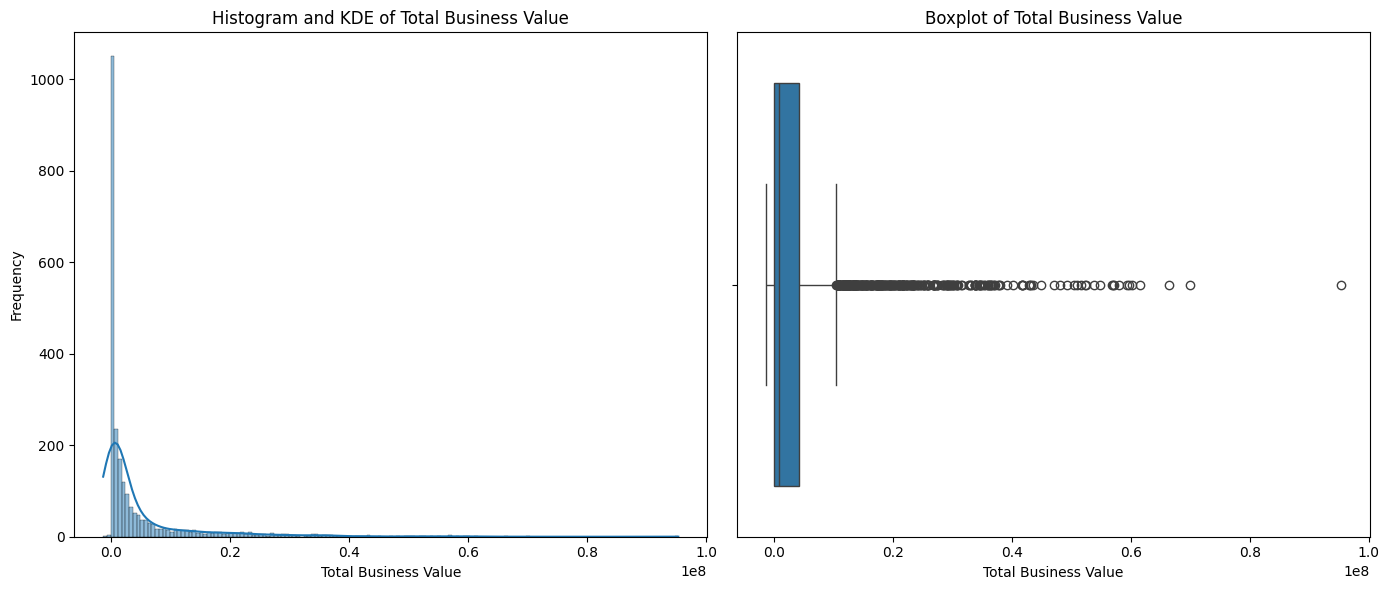


--------------------------------------------------
Analysis for Column: Quarterly Rating
--------------------------------------------------
Skewness: 1.0953
Kurtosis: 0.1937

Top 10 value counts:
Quarterly Rating
1.000000    1202
2.000000     116
1.600000      88
1.750000      72
2.500000      69
1.500000      59
3.000000      40
1.428571      39
2.750000      34
1.666667      32
Name: count, dtype: int64

Bottom 10 value counts:
Quarterly Rating
2.304348    1
1.727273    1
1.142857    1
1.705882    1
1.700000    1
2.550000    1
1.631579    1
2.565217    1
1.933333    1
1.882353    1
Name: count, dtype: int64

Z-scores (First 10 values):
[ 0.60277326 -0.78707919 -0.78707919 -0.78707919  0.04683228 -0.78707919
 -0.78707919  1.29769948 -0.42450898 -0.78707919]

IQR value is 1.0
Upper Limit/Bound: 3.5
Lower Limit/Bound: -0.5
Number of rows which are outliners are 28



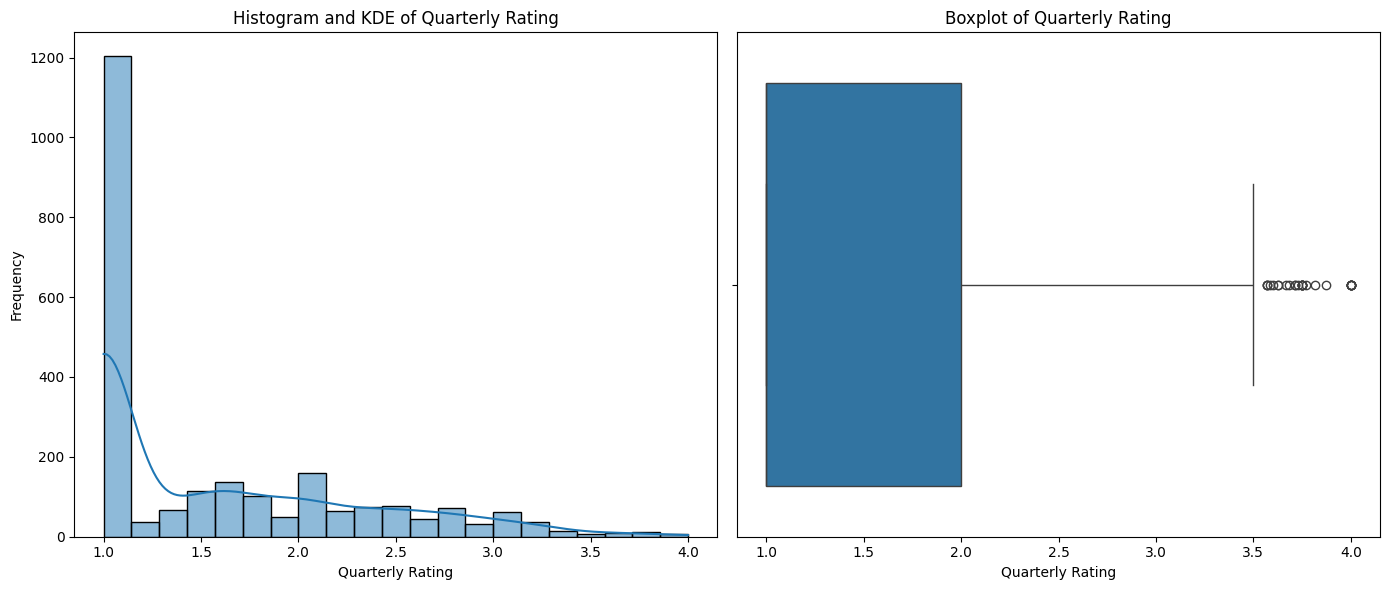

In [420]:
for i in [col for col in df.select_dtypes(include=['int64', 'float64']).columns if col != 'Driver_ID']:
    print(f"\n{'-'*50}")
    print(f"Analysis for Column: {i}")
    print(f"{'-'*50}")
    skew_value = df[i].skew()
    print(f"Skewness: {skew_value:.4f}")
    kurt_value = df[i].kurt()
    print(f"Kurtosis: {kurt_value:.4f}")
    print("\nTop 10 value counts:")
    print(df[i].value_counts().head(10))
    print("\nBottom 10 value counts:")
    print(df[i].value_counts().tail(10))
    z_scores = zscore(df[i].dropna())
    print(f"\nZ-scores (First 10 values):")
    print(z_scores[:10])
    IQR = df[i].quantile(0.75)-df[i].quantile(0.25)
    print(f"\nIQR value is {IQR}\nUpper Limit/Bound: {df[i].quantile(0.75)+1.5*IQR}\nLower Limit/Bound: {df[i].quantile(0.25)-1.5*IQR}\nNumber of rows which are outliners are {df[(df[i]<df[i].quantile(0.25)-1.5*IQR) | (df[i]>df[i].quantile(0.75)+1.5*IQR)].shape[0]}\n")
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    sns.histplot(df[i], kde=True, ax=axes[0])
    axes[0].set_title(f'Histogram and KDE of {i}')
    axes[0].set_xlabel(i)
    axes[0].set_ylabel('Frequency')
    sns.boxplot(x=df[i], ax=axes[1])
    axes[1].set_title(f'Boxplot of {i}')
    axes[1].set_xlabel(i)
    plt.tight_layout()
    plt.show()

#### Analysis of Numerical Columns:
1. Age
   - Skewness: 0.5304 (slightly positively skewed).
   - Kurtosis: 0.1508 (close to normal distribution).
   - Top Age Value: 32 (121 occurrences).
   - Bottom Age Value: Rare values (e.g., 32.800, 27.545 with 1 occurrence each).
   - Z-scores indicate no extreme outliers within the bounds of 17 and 49 years.
   - Number of Outliers: 23 (based on IQR analysis).
   - Visual Insights:
     - The histogram and KDE show a distribution centered around ages 30–35.
     - The boxplot indicates a small number of outliers above the upper bound.
2. Income
   - Skewness: 0.7776 (moderately positively skewed).
   - Kurtosis: 0.4564 (slightly leptokurtic).
   - Top Income Value: 48740 (3 occurrences).
   - Bottom Income Values: Low income like 19734 (1 occurrence).
   - Z-scores suggest some outliers in high-income ranges.
   - IQR: 36731.0.
   - Outliers: 47 rows above the upper bound (108931.5).
   - Visual Insights:
     - The histogram indicates a majority of drivers earn between 40000 and 80000.
     - Boxplot confirms the presence of a few high-income outliers.
3. Total Business Value
   - Skewness: 3.3613 (highly positively skewed).
   - Kurtosis: 14.6539 (highly leptokurtic, suggesting heavy tails).
   - Top Value: 0 (719 occurrences; cancellations/refunds).
   - High positive values: e.g., 500000, 300000.
   - Negative Values: e.g., -6206475 (outlier region).
   - Outliers: 336 rows with values outside IQR bounds.
   - Visual Insights:
     - The histogram is right-skewed with a peak at zero.
     - Boxplot highlights significant high-value outliers.
4. Quarterly Rating
   - Skewness: 1.8953 (strongly positively skewed).
   - Kurtosis: 0.1937 (close to normal distribution).
   - Top Value: 1.0 (1202 occurrences; lowest performance rating).
   - Bottom Value: Rare ratings like 2.304 (1 occurrence).
   - Z-scores show a tight spread around low ratings.
   - IQR: 1.0, suggesting tight distribution.
   - Outliers: 28 rows with high ratings (>3.5).
   - Visual Insights:
     - The histogram highlights a concentration around low ratings (1.0 to 2.0).
     - Boxplot confirms a small number of higher-rating outliers.

# Bivariate Analysis

In [421]:
df.head(10)

Driver_ID        Age Gender   City Education_Level    Income Dateofjoining  \
0          1  28.000000  [0.0]  [C23]             [2]   57387.0    2018-12-24   
1          2  31.000000  [0.0]   [C7]             [2]   67016.0    2020-06-11   
2          4  43.000000  [0.0]  [C13]             [2]   65603.0    2019-07-12   
3          5  29.000000  [0.0]   [C9]             [0]   46368.0    2019-09-01   
4          6  31.000000  [1.0]  [C11]             [1]   78728.0    2020-07-31   
5          8  34.000000  [0.0]   [C2]             [0]   70656.0    2020-09-19   
6         11  28.000000  [1.0]  [C19]             [2]   42172.0    2020-07-12   
7         12  35.000000  [0.0]  [C23]             [2]   28116.0    2019-06-29   
8         13  29.608696  [0.0]  [C19]             [2]  119227.0    2015-05-28   
9         14  39.000000  [1.0]  [C26]             [0]   19734.0    2020-10-16   

  LastWorkingDate Joining Designation Grade  Total Business Value  \
0      2019-11-03                 [1]   [1]               1715580   
1             NaT                 [2]   [2]                     0   
2      2020-04-27                 [2]   [2]                350000   
3      2019-07-03                 [1]   [1]                120360   
4             NaT                 [3]   [3]               1265000   
5      2020-11-15                 [3]   [3]                     0   
6             NaT                 [1]   [1]                     0   
7      2019-12-21                 [1]   [1]               2607180   
8      2020-11-25                 [1]   [4]              10213040   
9             NaT                 [3]   [3]                     0   

   Quarterly Rating  
0           2.00000  
1           1.00000  
2           1.00000  
3           1.00000  
4           1.60000  
5           1.00000  
6           1.00000  
7           2.50000  
8           1.26087  
9           1.00000

In [422]:
def plot_scatterplots(df, numerical_columns):
    for i, col1 in enumerate(numerical_columns):
        for col2 in numerical_columns[i+1:]:
            plt.figure(figsize=(8, 6))
            sns.scatterplot(data=df, x=col1, y=col2)
            plt.title(f"Scatter Plot: {col1} vs {col2}")
            plt.xlabel(col1)
            plt.ylabel(col2)
            plt.grid(True)
            plt.show()

In [423]:
def plot_boxplots(df, categorical_columns, numerical_columns):
    categorical_columns = [str(col) for col in categorical_columns]
    numerical_columns = [str(col) for col in numerical_columns]
    for cat_col in categorical_columns:
        for num_col in numerical_columns:
            try:
                plt.figure(figsize=(8, 6))
                sns.boxplot(data=df, x=cat_col, y=num_col)
                plt.title(f"Box Plot: {num_col} by {cat_col}")
                plt.xlabel(cat_col)
                plt.ylabel(num_col)
                plt.xticks(rotation=45)
                plt.grid(True)
                plt.show()
            except Exception as e:
                print(f"Error plotting Box Plot for {cat_col} vs {num_col}: {e}")

In [424]:
def plot_stacked_bars_and_heatmaps(df, categorical_columns):
    for i, cat_col1 in enumerate(categorical_columns):
        for cat_col2 in categorical_columns[i+1:]:
            crosstab = pd.crosstab(df[cat_col1].astype(str), df[cat_col2].astype(str))
            crosstab_percentage = crosstab.div(crosstab.sum(axis=1), axis=0) * 100
            fig, axes = plt.subplots(1, 2, figsize=(20, 10))
            crosstab.plot(kind='bar', stacked=True, ax=axes[0])
            axes[0].set_title(f"Stacked Bar Plot: {cat_col1} vs {cat_col2}")
            axes[0].set_xlabel(cat_col1)
            axes[0].set_ylabel("Frequency")
            axes[0].tick_params(axis='x', rotation=45)
            axes[0].grid(True)
            axes[0].legend(title=cat_col2, bbox_to_anchor=(1.05, 1), loc='upper left')
            sns.heatmap(crosstab_percentage, annot=True, fmt='.1f', cmap='Blues', ax=axes[1], cbar_kws={'format': '%.0f%%'})
            axes[1].set_title(f"Heatmap (Percentage): {cat_col1} vs {cat_col2}")
            axes[1].set_xlabel(cat_col2)
            axes[1].set_ylabel(cat_col1)
            plt.tight_layout()
            plt.show()

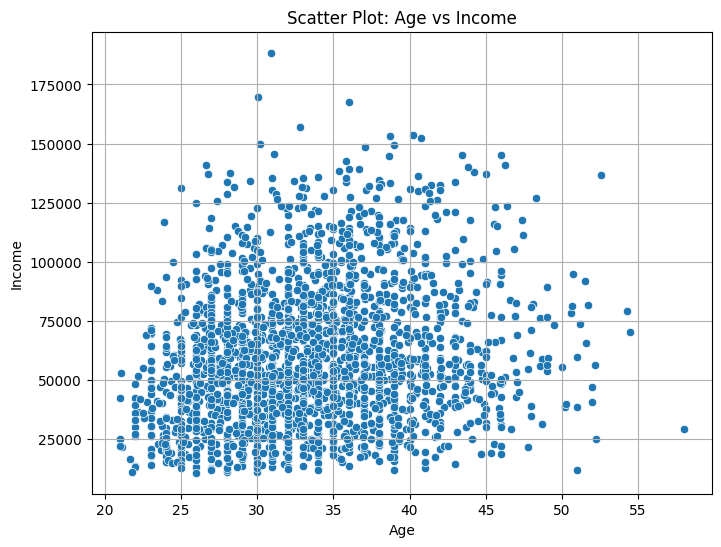

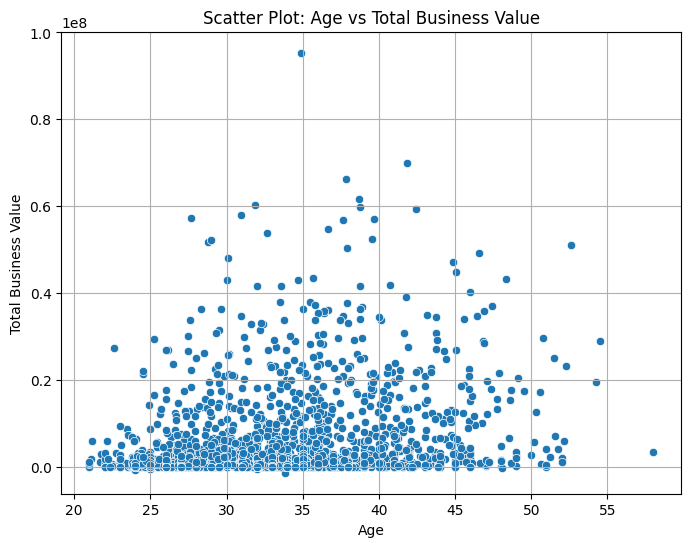

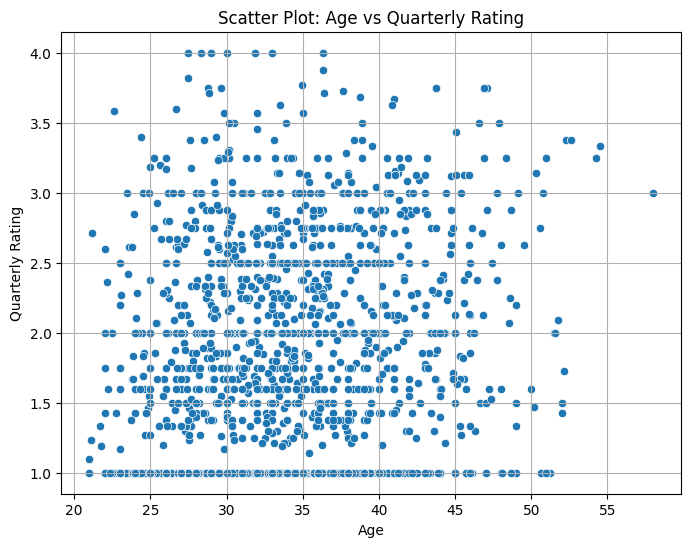

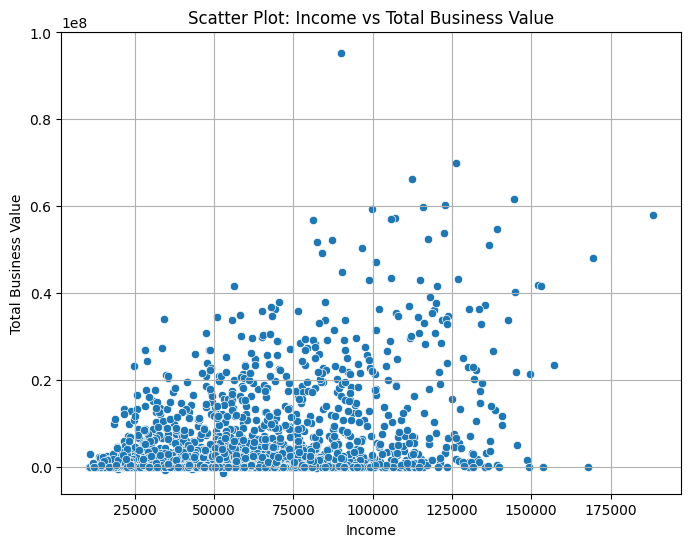

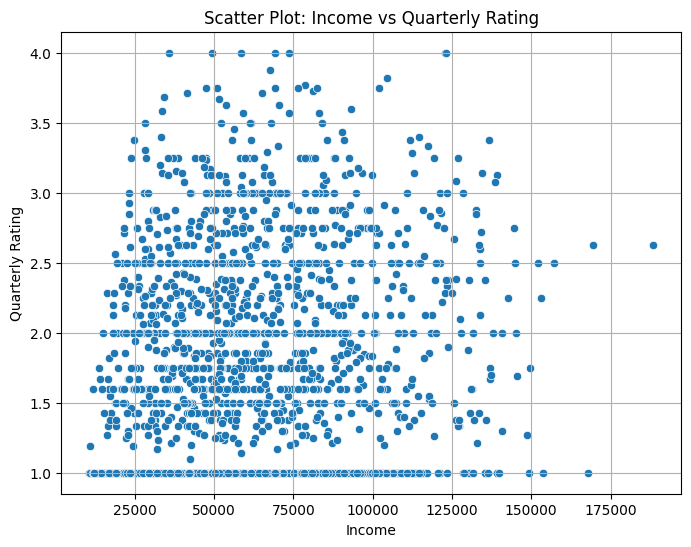

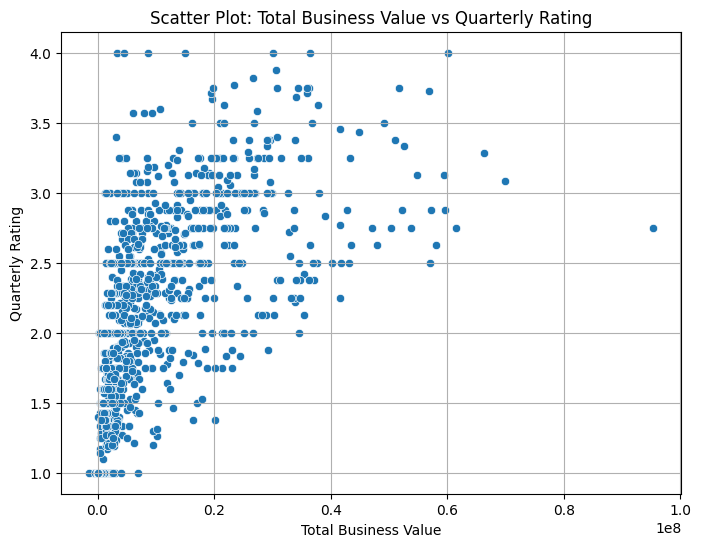

In [425]:
plot_scatterplots(df, [col for col in df.select_dtypes(include=['int64', 'float64']).columns if col != 'Driver_ID'])

#### Analysis of Columns with Numerical-Numerical Relationships
1. Age vs. Income
   - **Observations**:
     - The scatter plot indicates no clear linear relationship between age and income.
     - Most data points are clustered around the middle-age range (30-40 years) and income levels of 40,000-80,000.
     - Some outliers are visible in the higher income range (>100,000), spread across various ages.
   - **Insights**:
     - Age does not appear to be a strong predictor of income.
     - High-income earners are present across all age groups but are concentrated in mid-age drivers.
2. Age vs. Total Business Value
   - **Observations**:
     - The majority of drivers (regardless of age) have low total business values, concentrated near zero.
     - A few outliers with high business values (above 0.6e8) are visible, primarily in mid-age groups (30-40 years).
   - **Insights**:
     - Total business value is not strongly correlated with age.
     - Drivers in mid-age groups seem to dominate higher business values, potentially due to experience or better performance.
3. Age vs. Quarterly Rating
   - **Observations**:
     - Quarterly ratings are clustered around 1.0 to 2.5 for all age groups.
     - No clear trend is visible between age and quarterly ratings.
     - Outliers with ratings >3.5 are distributed across different age groups.
   - **Insights**:
     - Age is not a strong determinant of quarterly rating.
     - Most drivers across all age groups have low to average ratings, indicating potential room for improvement in performance across the board.
4. Income vs. Total Business Value
   - **Observations**:
     - Income and total business value show a weak positive correlation.
     - Drivers with higher incomes tend to have higher business values, but the relationship is not linear.
     - Outliers with very high business values (>0.6e8) have moderate to high incomes.
   - **Insights**:
     - Drivers generating higher business values often earn higher incomes.
     - Factors beyond total business value (e.g., bonuses or performance metrics) might contribute to income variability.
5. Income vs. Quarterly Rating
   - **Observations**:
     - No strong relationship between income and quarterly ratings is visible.
     - Most data points cluster around ratings of 1.0 to 2.5, regardless of income.
     - High-income drivers (>100,000) are scattered across various rating levels.
   - **Insights**:
     - Higher income does not necessarily correlate with better quarterly ratings.
     - Ratings appear to be independent of income, possibly influenced by qualitative factors like customer feedback or punctuality.
6. Total Business Value vs. Quarterly Rating
   - **Observations**:
     - A weak positive correlation exists between total business value and quarterly ratings.
     - Drivers with higher ratings (above 3.0) generally have higher business values.
     - However, most data points are clustered at lower ratings (1.0 to 2.0) and low business values.
   - **Insights**:
     - Total business value might be a factor influencing quarterly ratings, but the relationship is not strong.
     - Improving business value could help improve quarterly ratings, but additional factors need to be considered.
General Recommendations:
- **For Income**:
  - Investigate factors influencing high incomes among certain drivers and replicate success strategies across the fleet.
  - Offer targeted incentives for drivers in the mid-income range to boost performance.
- **For Business Value**:
  - Analyze drivers with high total business values to identify and scale best practices.
  - Address cancellations/refunds that might be contributing to low business values for many drivers.
- **For Quarterly Ratings**:
  - Provide performance improvement programs for drivers with low ratings.
  - Focus on understanding the drivers of high ratings and aligning them with incentives.
- **For Age Groups**:
  - Mid-age drivers (30-40 years) tend to perform better in terms of income and business value. Leverage their experience for mentorship programs.

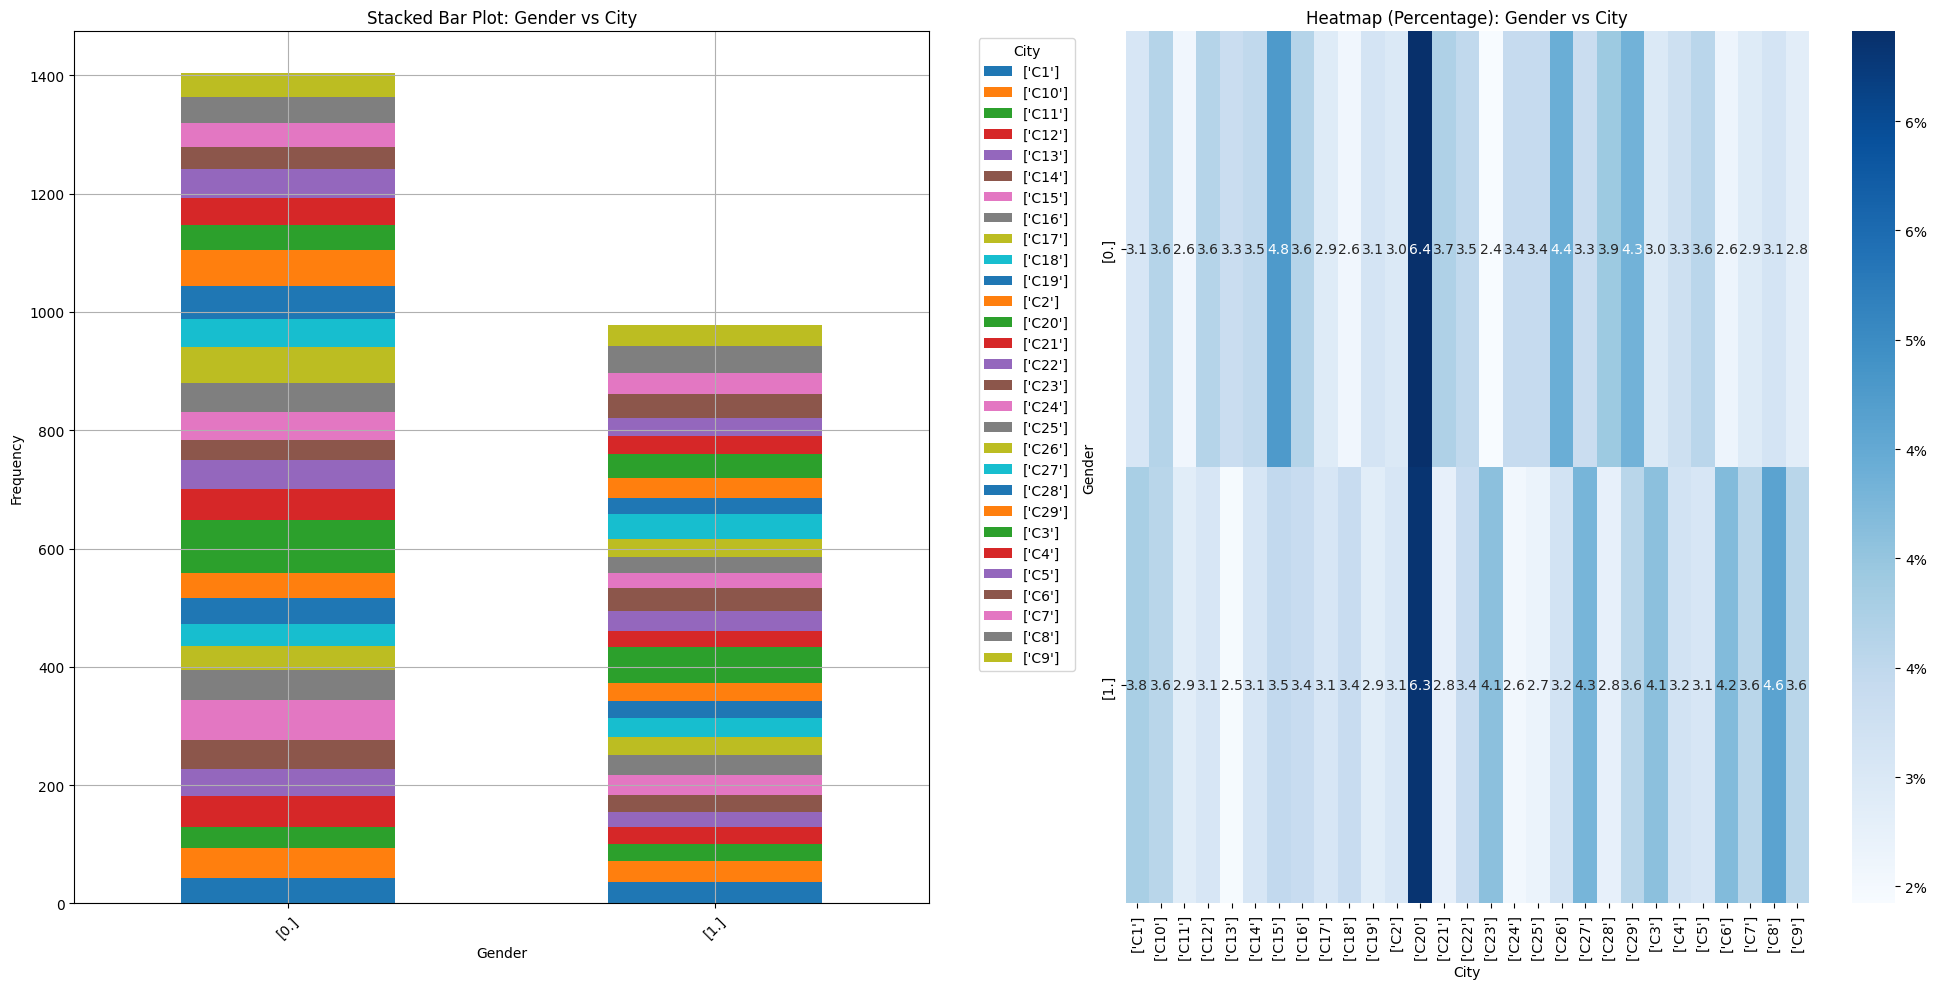

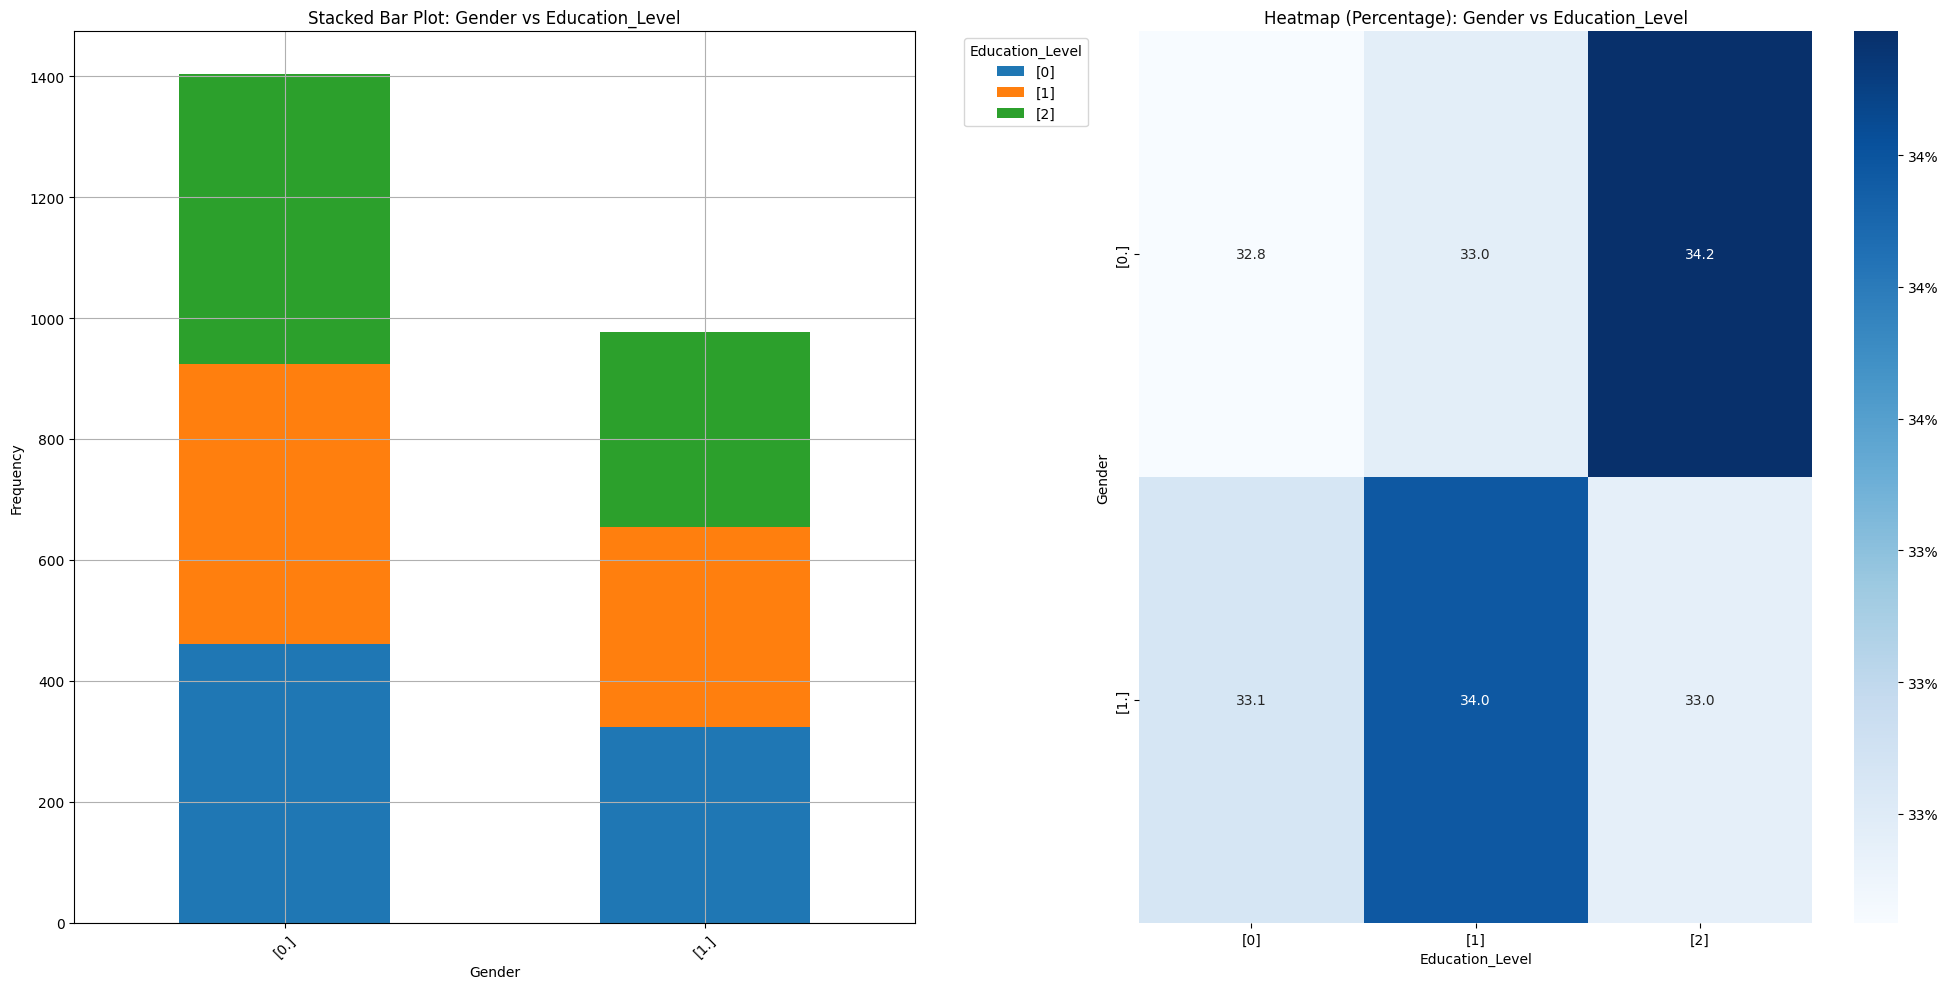

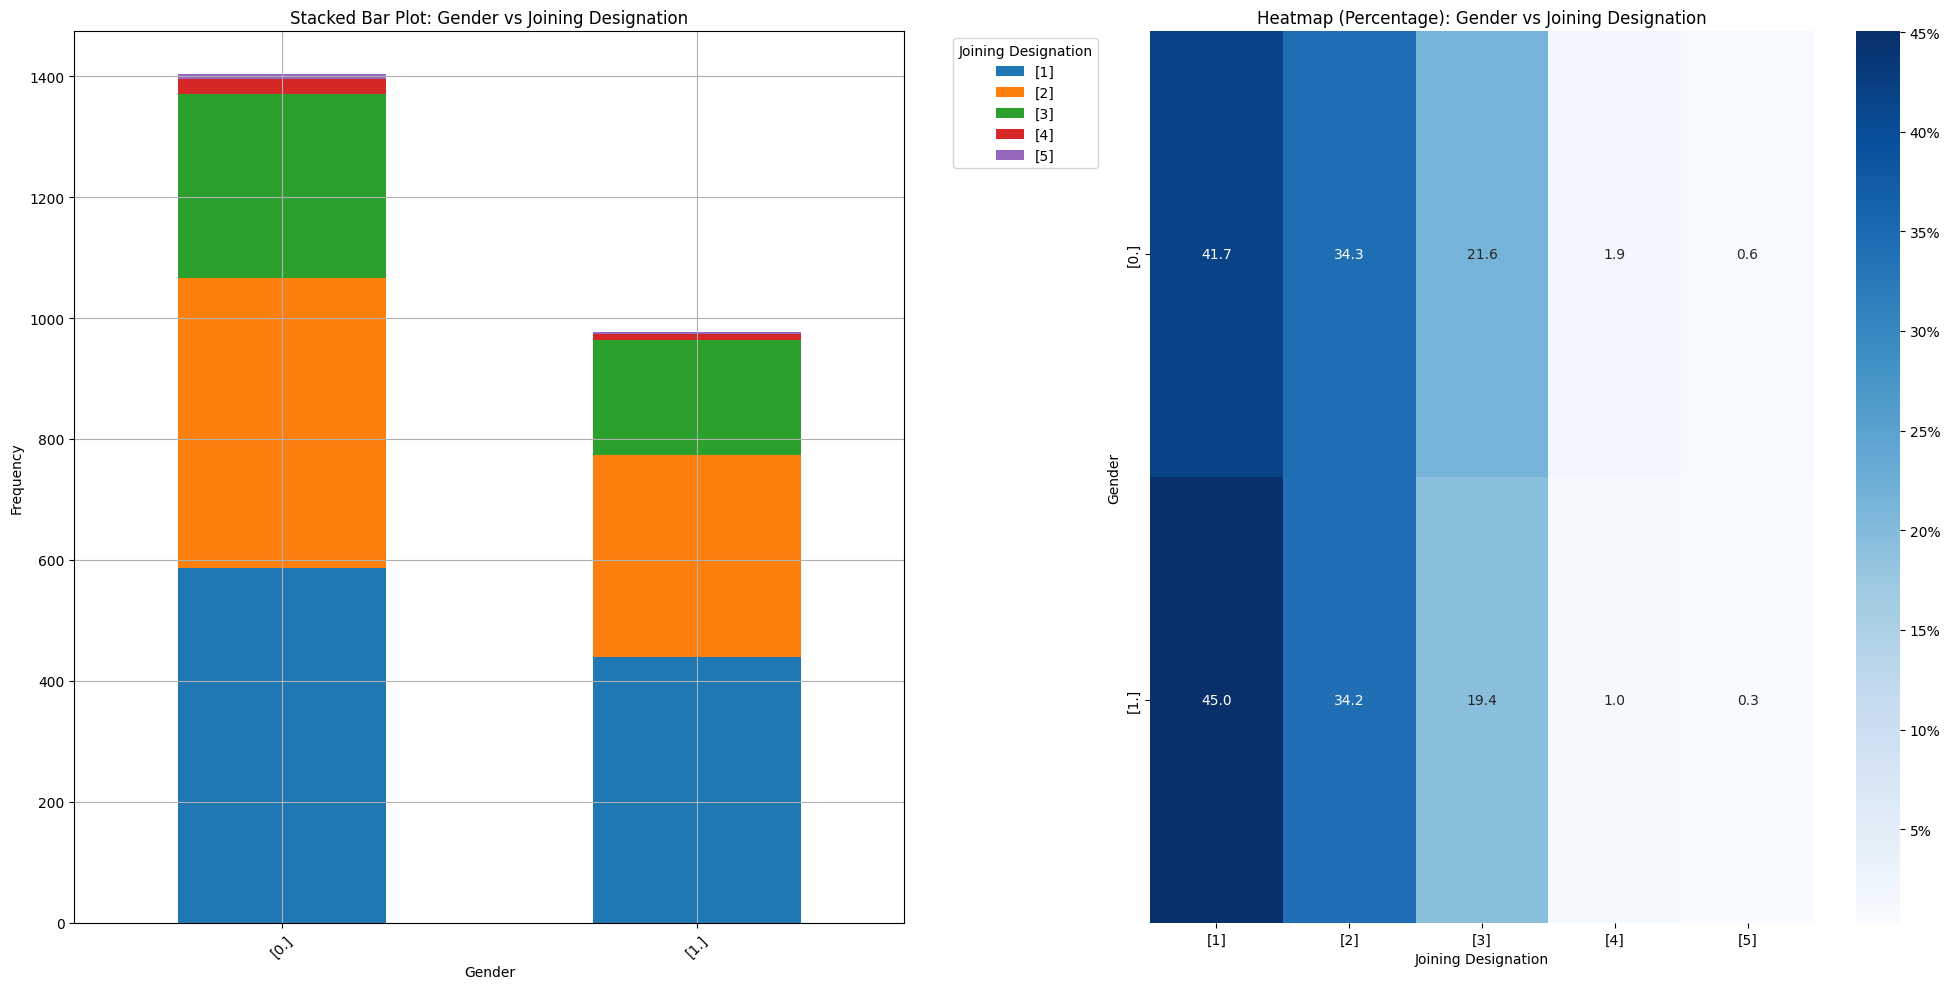

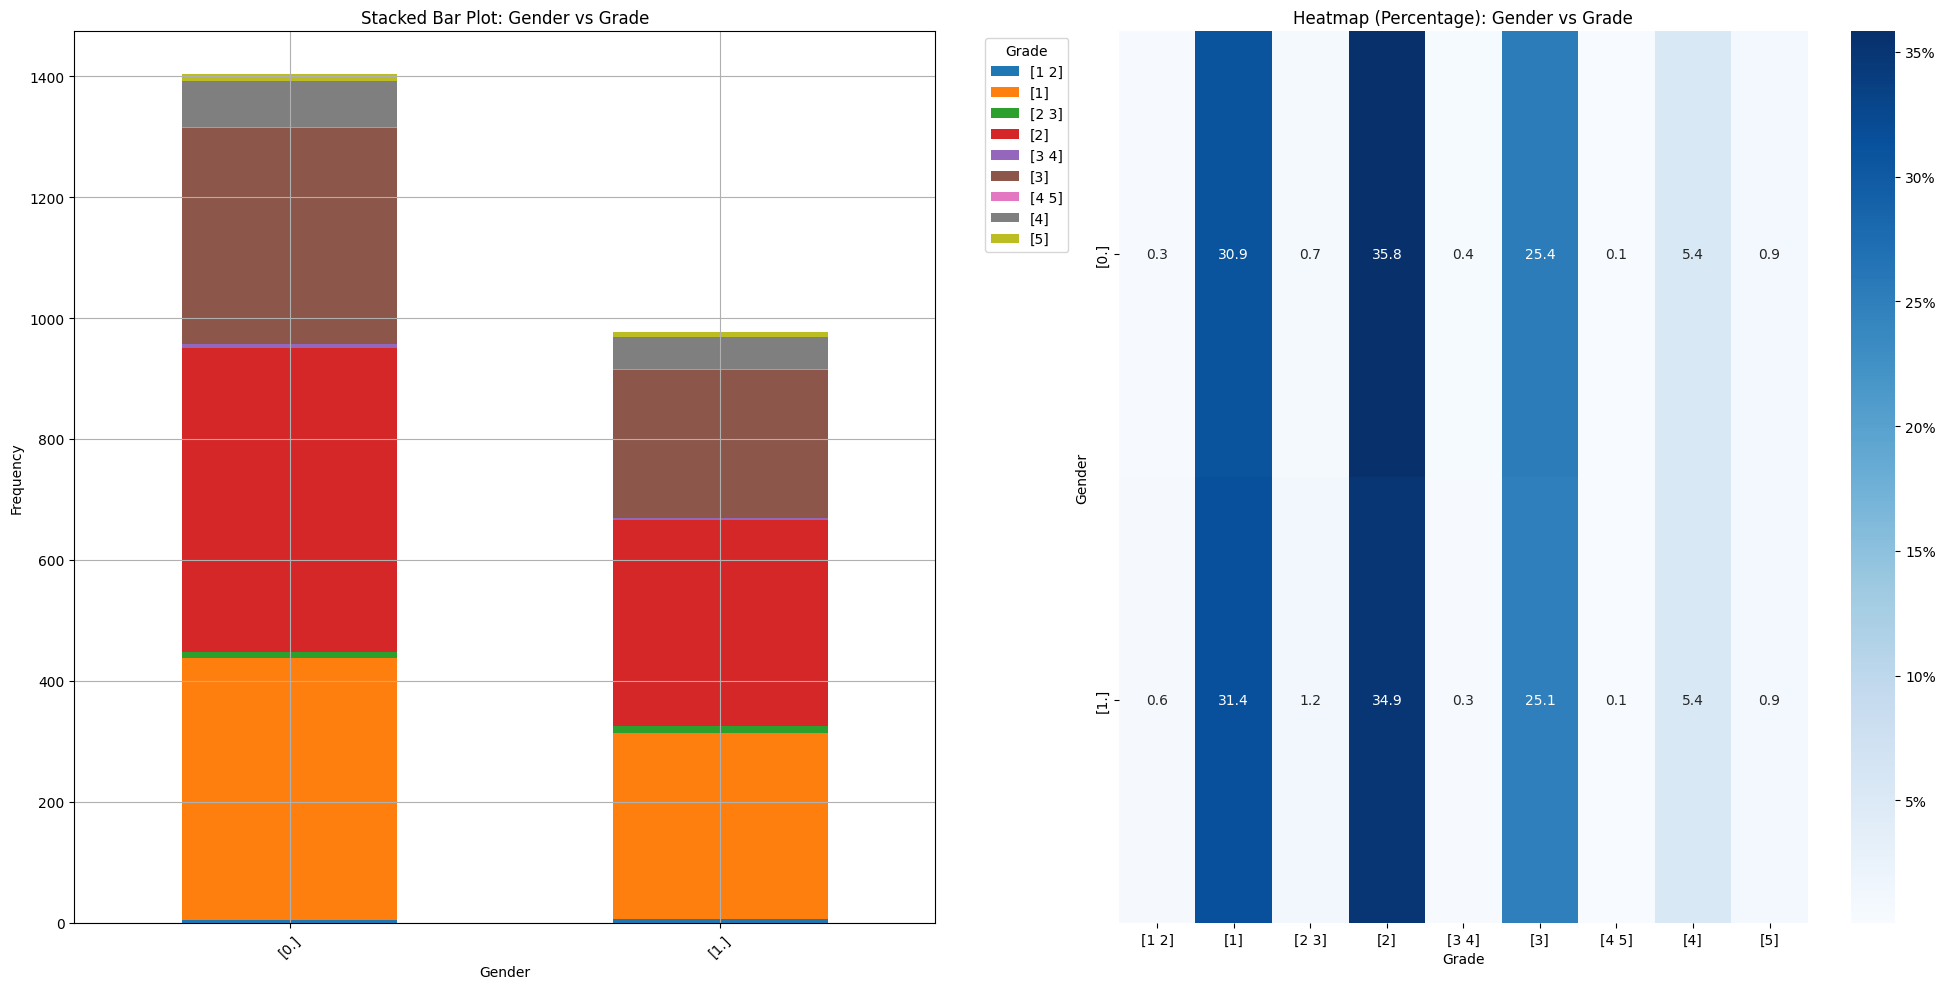

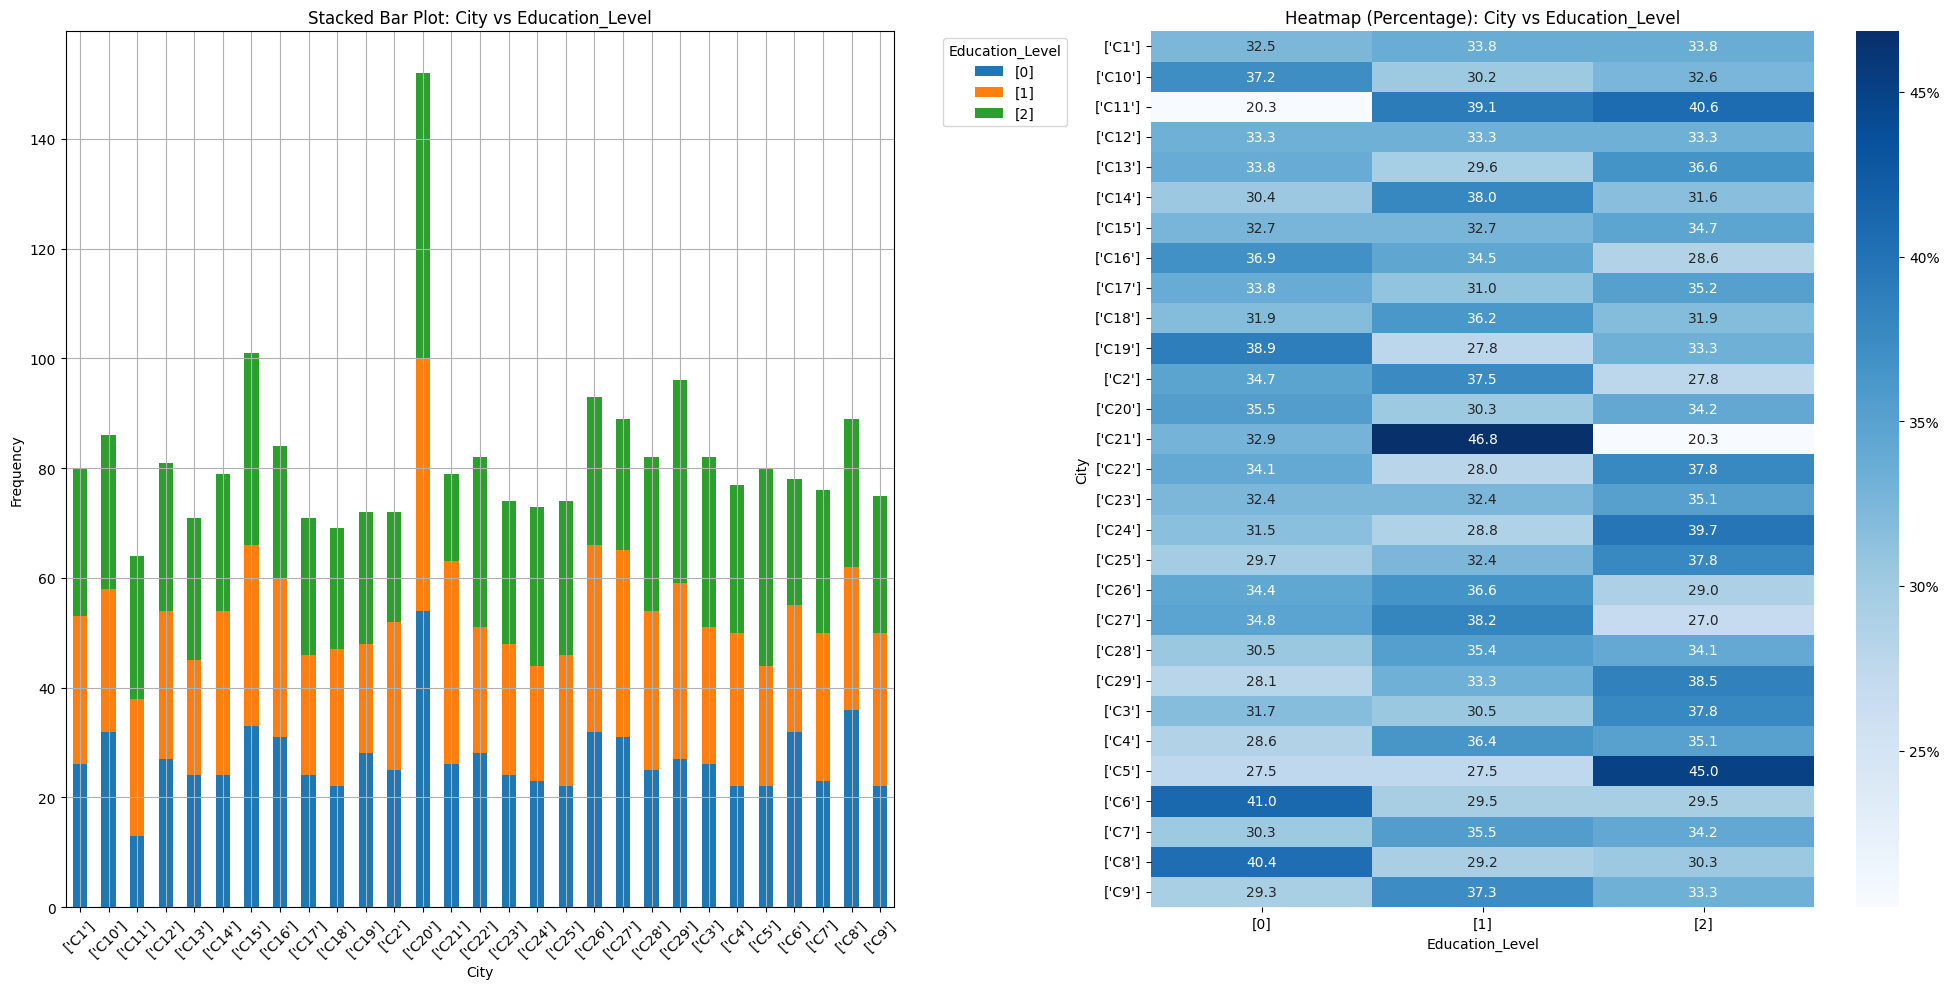

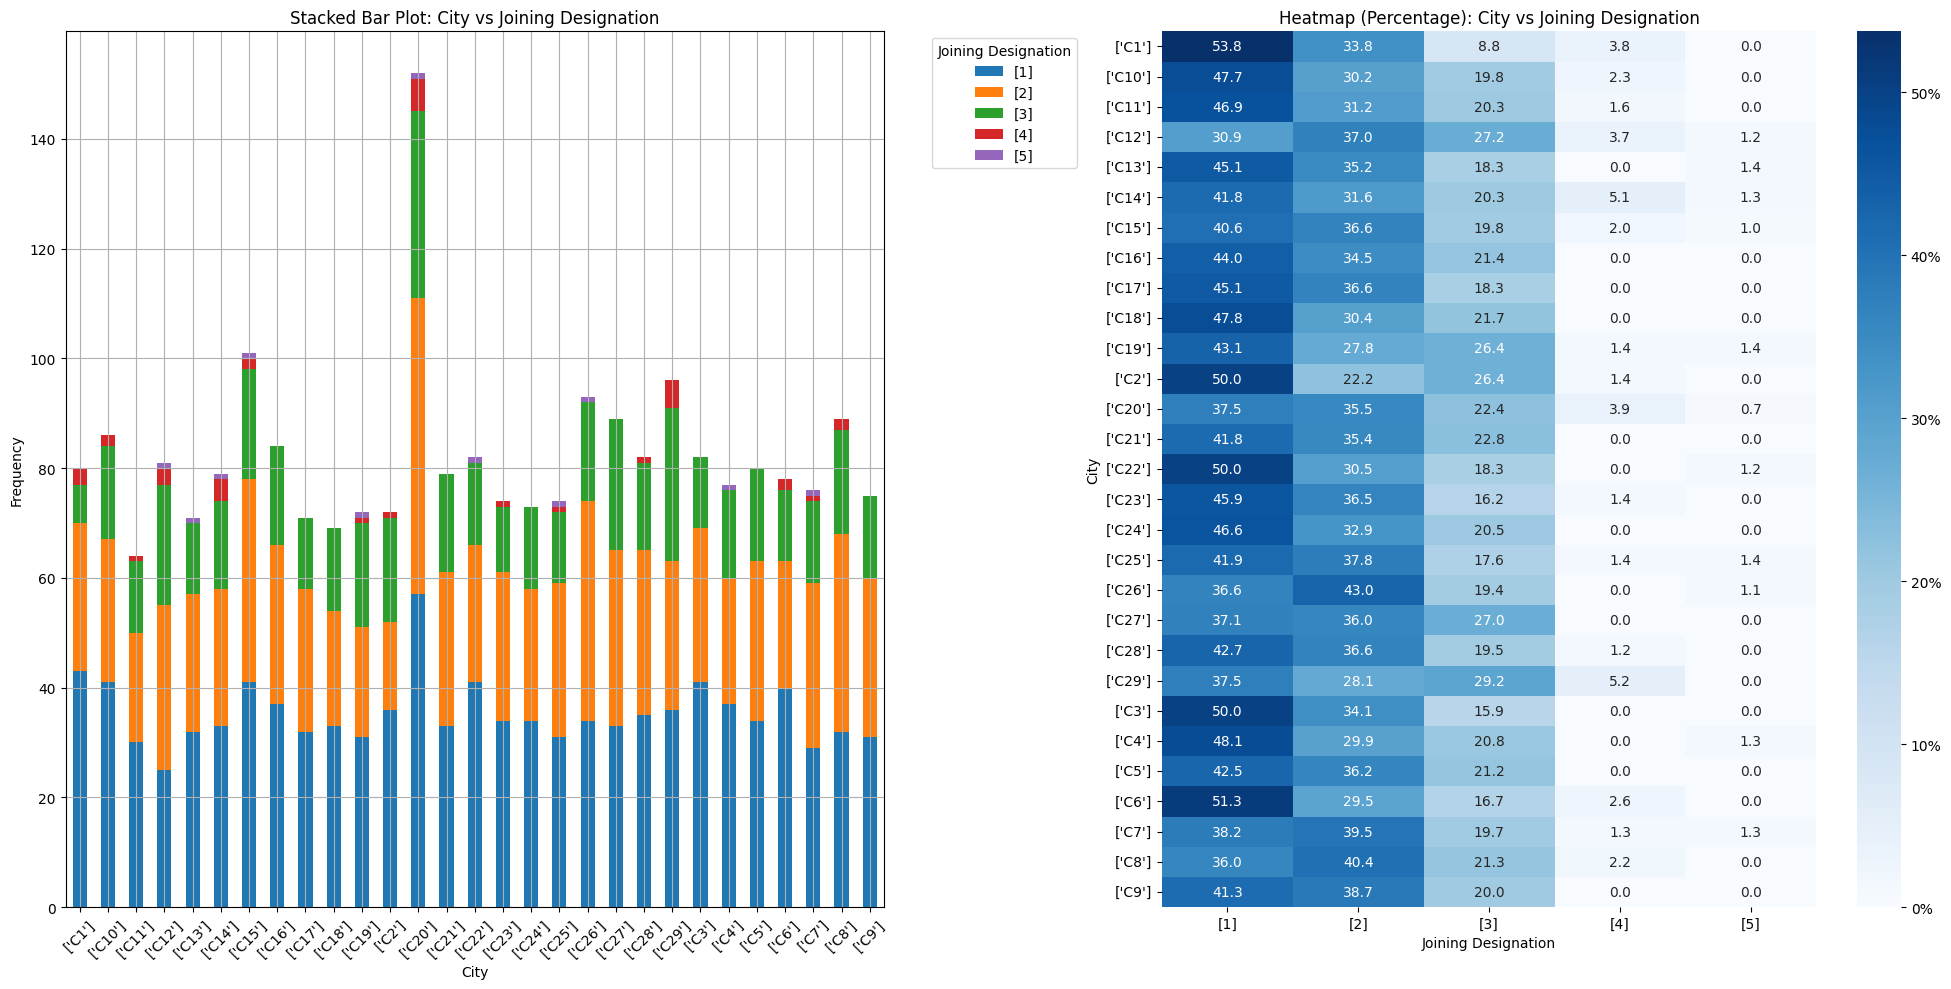

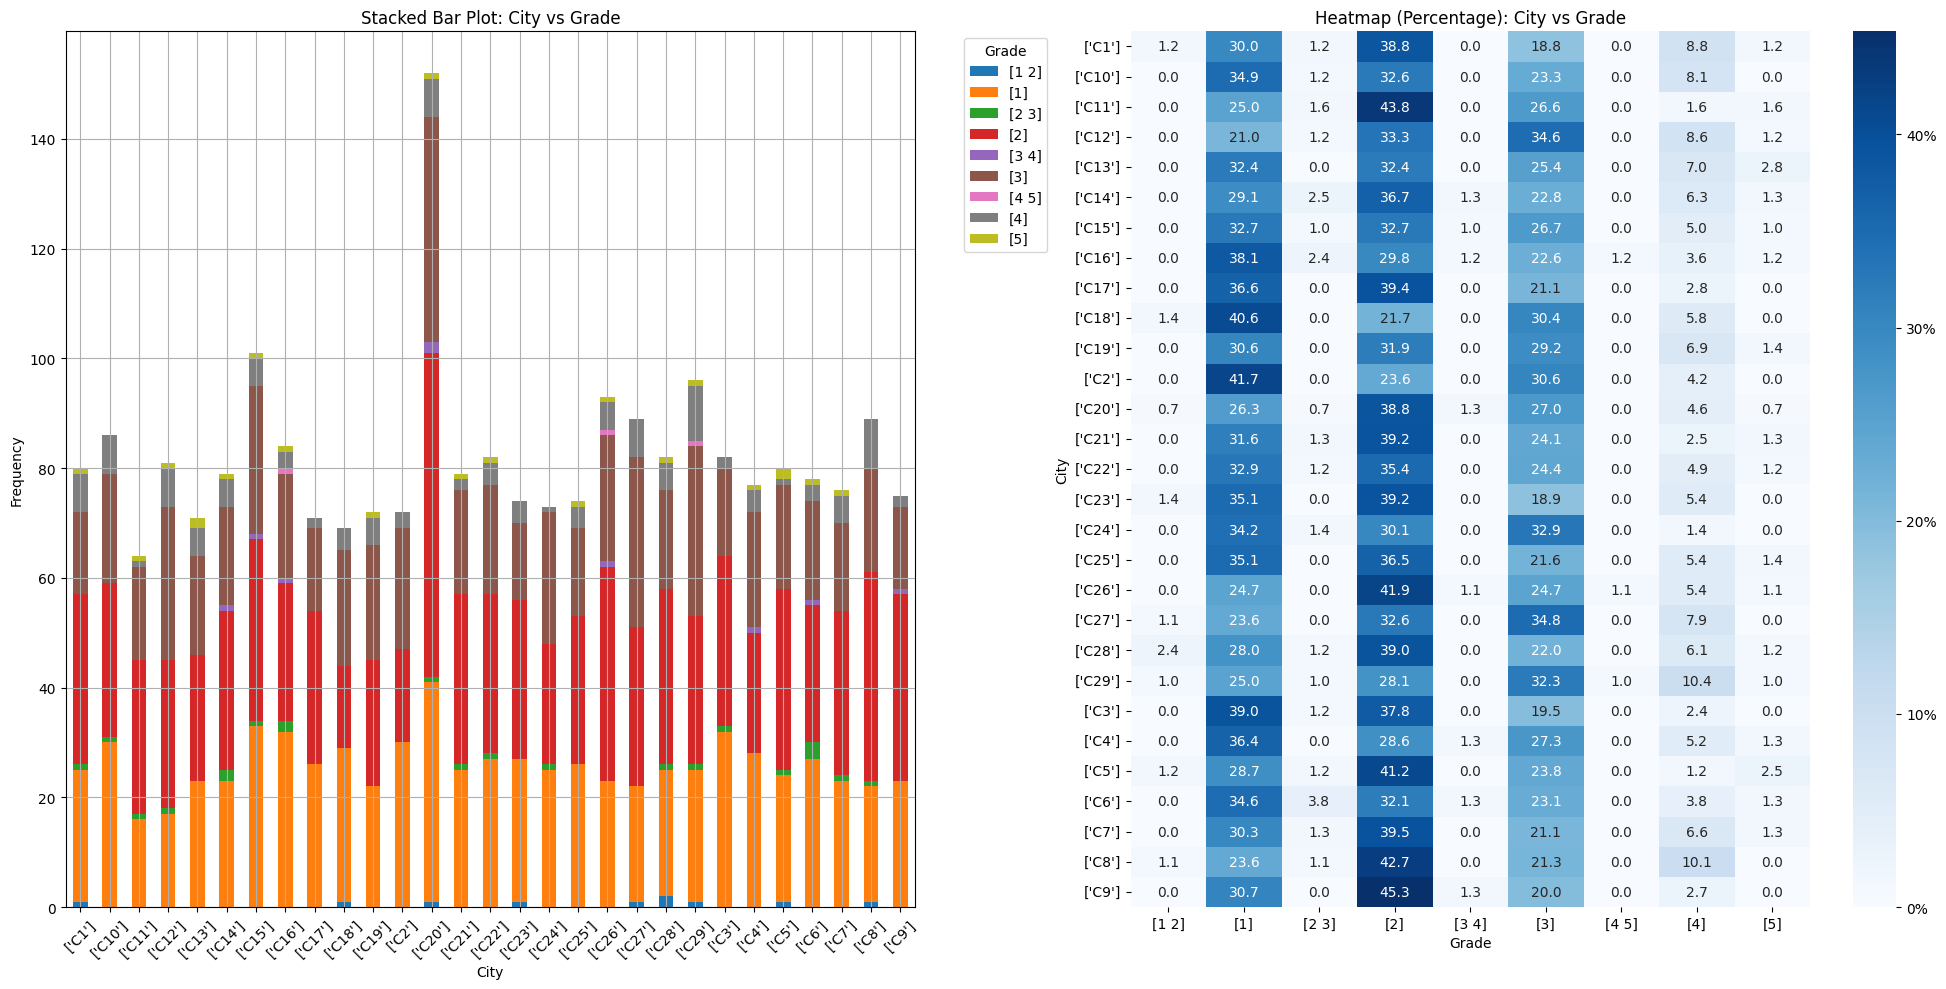

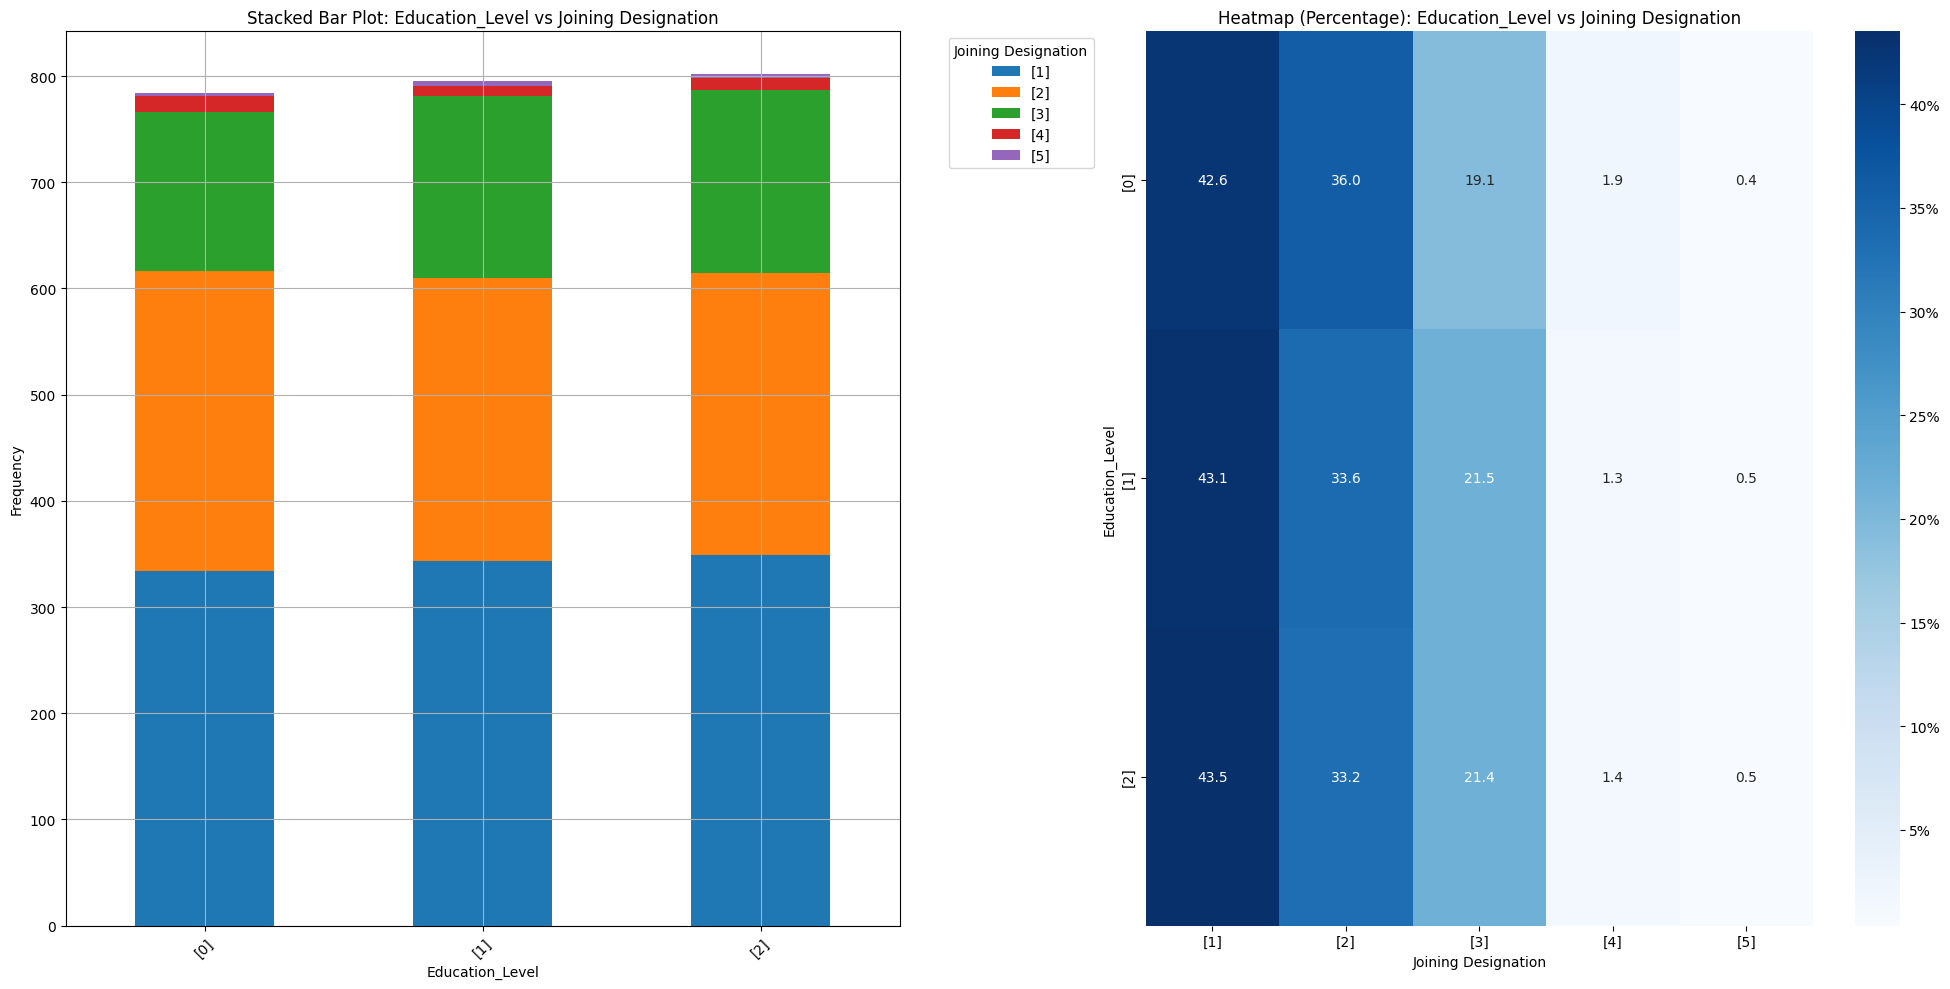

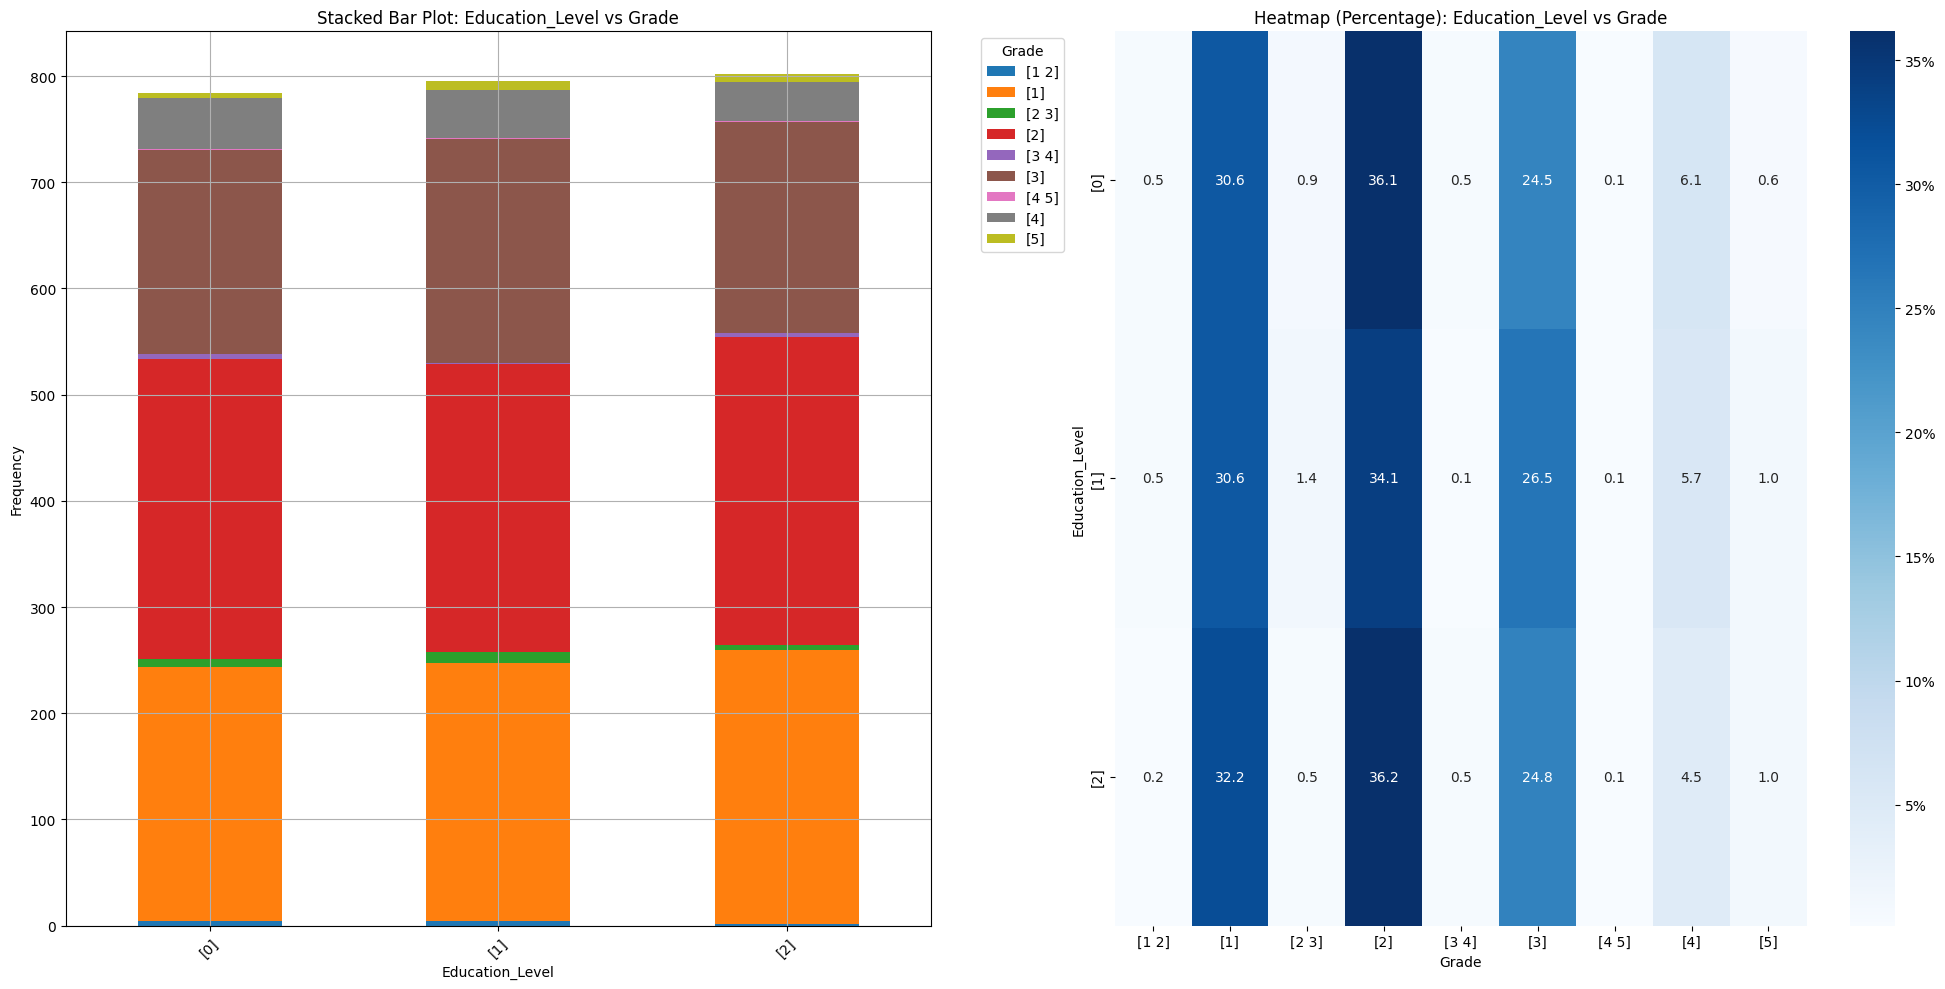

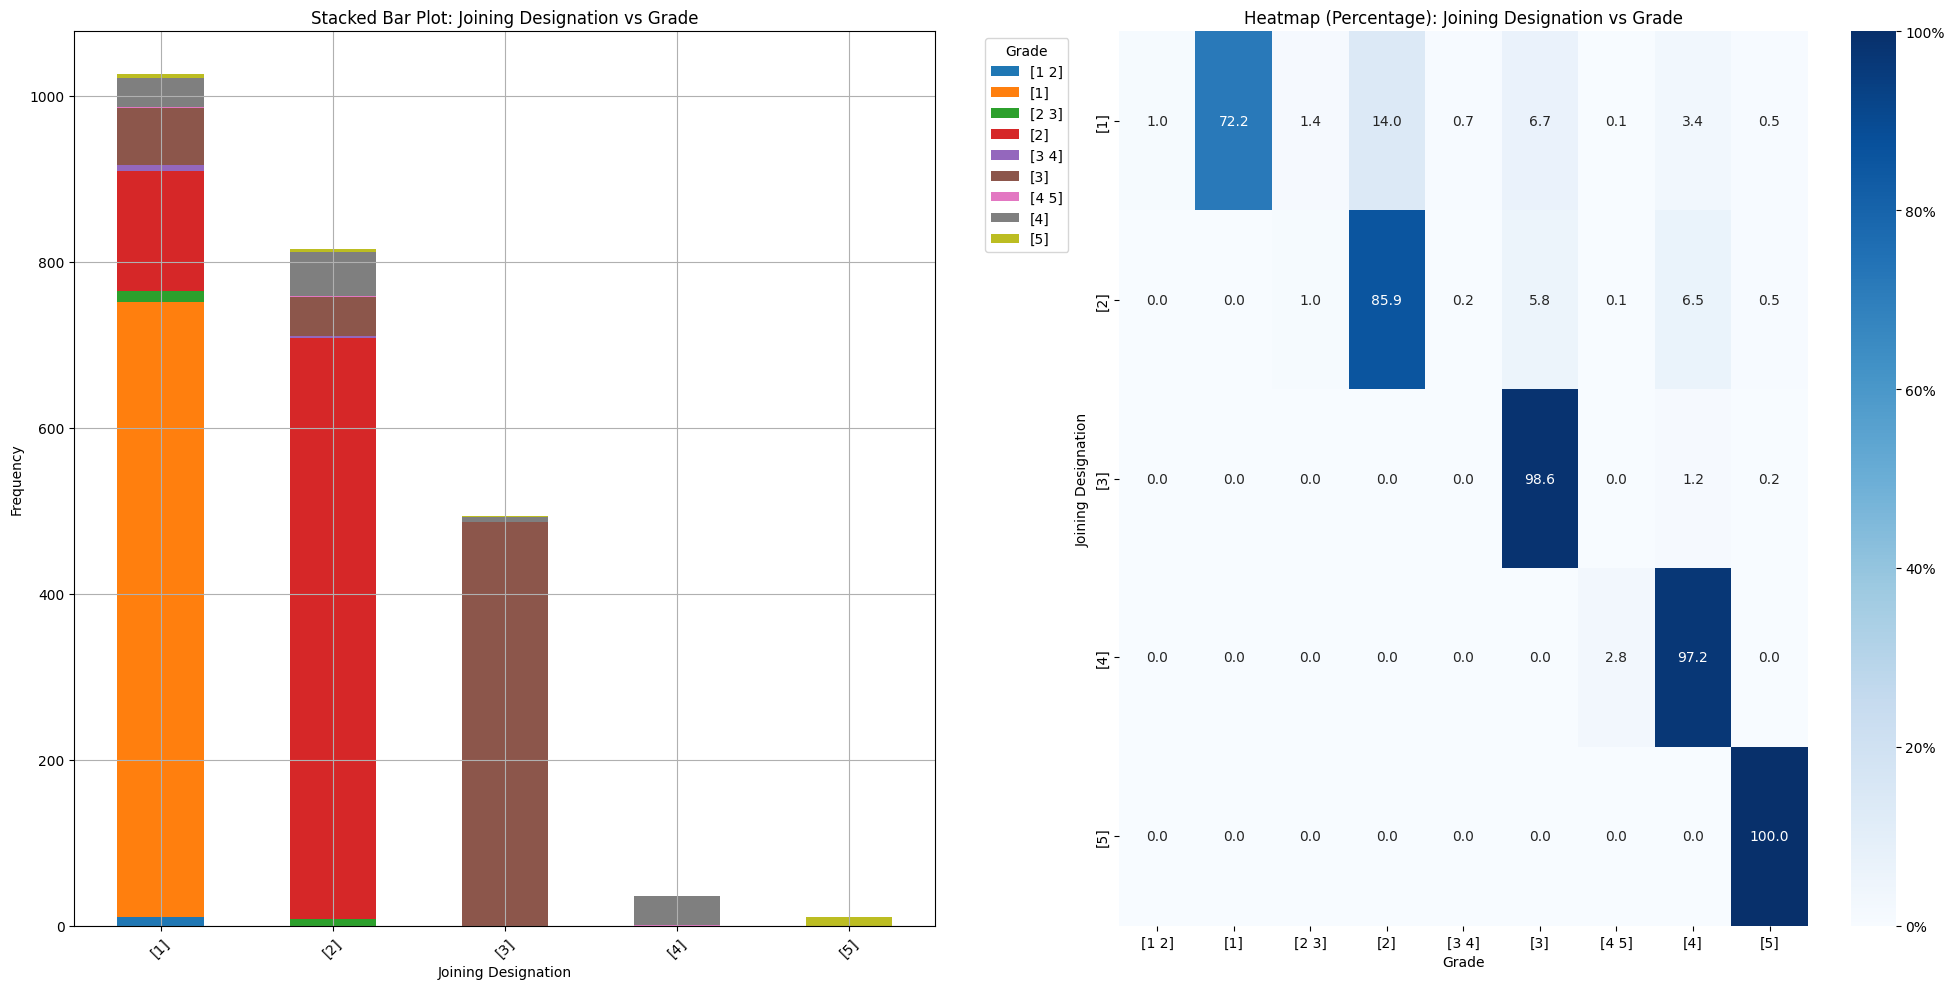

In [426]:
plot_stacked_bars_and_heatmaps(df, df.select_dtypes(include=['object', 'category']).columns.tolist())

## Analysis of Columns with Categorical-Categorical Relationship:
**Gender vs City**

- Stacked Bar Plot:
  - The distribution of genders across cities is relatively balanced.
  - City `C20` has the highest representation for both genders.
  - Certain cities display slight gender preferences, indicating possible regional trends.

- Heatmap (Percentage):
  - Cities like `C20` show higher percentages of one gender.
  - Some cities, such as `C6` and `C8`, have near-equal gender distributions, highlighting balanced participation.

**Gender vs Education Level**

- Stacked Bar Plot:
  - Education levels are evenly distributed between genders.
  - A significant portion of drivers are graduates, equally represented across genders.

- Heatmap (Percentage):
  - Graduates (`2`) dominate among both genders.
  - Minimal variation between genders suggests a balanced distribution of educational qualifications.

**Gender vs Joining Designation**

- Stacked Bar Plot:
  - Designation `1` is the most common across both genders.
  - Senior roles (`4`, `5`) have minimal representation for both genders.

- Heatmap (Percentage):
  - Males (`0`) dominate entry-level positions (`1`), while senior roles show limited participation across genders.

**Gender vs Grade**

- Stacked Bar Plot:
  - Grades `2` and `3` are most common for both genders, indicating consistent performance distributions.
  - Higher grades (`4` and `5`) have sparse representation.

- Heatmap (Percentage):
  - Grade `2` exhibits a balanced gender distribution.
  - Marginal gender differences are observed in higher grades.

**City vs Education Level**

- Stacked Bar Plot:
  - City `C20` has the highest number of graduates, followed by other education levels.
  - Smaller cities demonstrate a more balanced distribution of education levels.

- Heatmap (Percentage):
  - Graduates dominate in cities like `C21` and `C6`.
  - Certain cities show a higher percentage of lower education levels.

**City vs Joining Designation**

- Stacked Bar Plot:
  - City `C20` leads in Designation `1`, while other cities distribute fairly across entry and mid-level roles.
  - Senior roles (`4`, `5`) show limited representation across cities.

- Heatmap (Percentage):
  - Cities `C1` and `C3` display a high percentage of entry-level positions, with minimal representation in senior roles.

**City vs Grade**

- Stacked Bar Plot:
  - Cities like `C20` dominate in Grade `2`.
  - Higher grades have limited representation across cities.

- Heatmap (Percentage):
  - Balanced participation in Grades `1` and `2` is observed across cities.
  - Higher grades show negligible differences among cities.

**Education Level vs Joining Designation**

- Stacked Bar Plot:
  - Designation `1` is the most common across all education levels.
  - Senior roles show minimal distribution.

- Heatmap (Percentage):
  - Entry-level positions dominate across all education levels.
  - Higher designations reveal limited differences between education levels.

**Education Level vs Grade**

- Stacked Bar Plot:
  - Grades `2` and `3` are prevalent across all education levels.
  - Higher grades have sparse distribution.

- Heatmap (Percentage):
  - Graduates and lower education levels are equally distributed in Grades `1` and `2`.
  - Higher grades show minimal representation differences.

**Joining Designation vs Grade**

- Stacked Bar Plot:
  - Entry-level grades are most prominent in Designations `1` and `2`.
  - Higher grades show minimal representation across all designations.

- Heatmap (Percentage):
  - Grades `2` and `3` dominate entry-level positions.
  - Senior grades are rarely represented in higher designations.


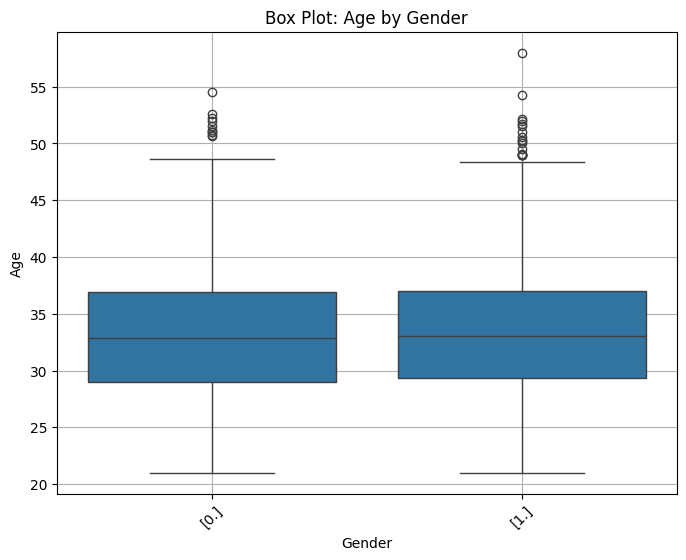

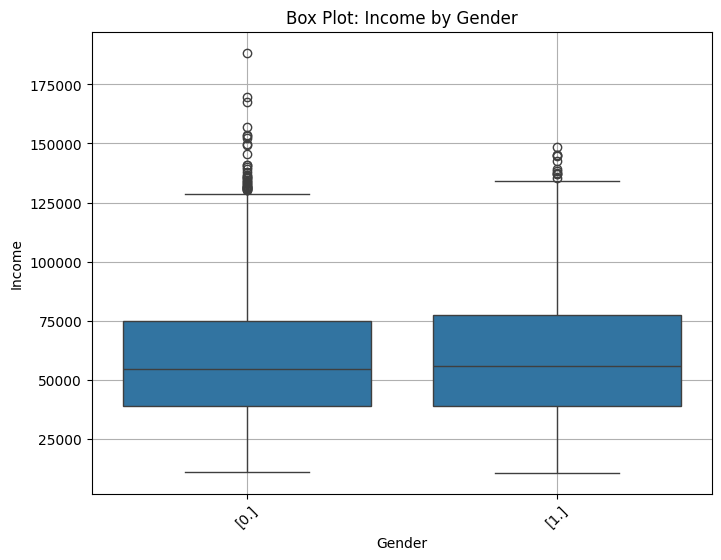

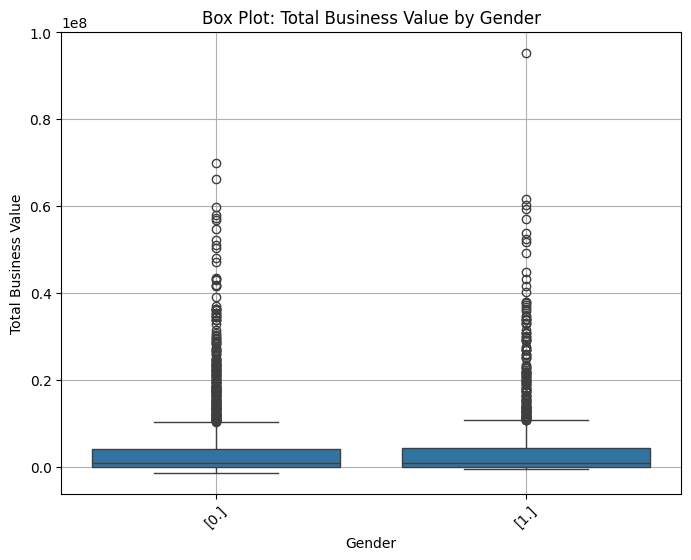

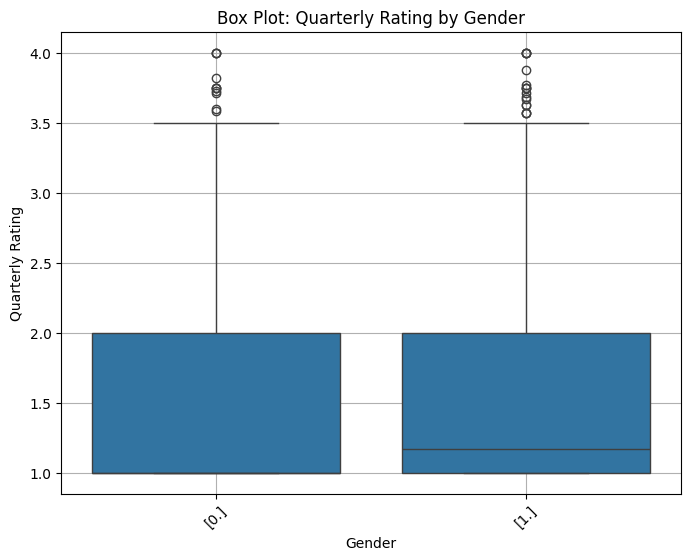

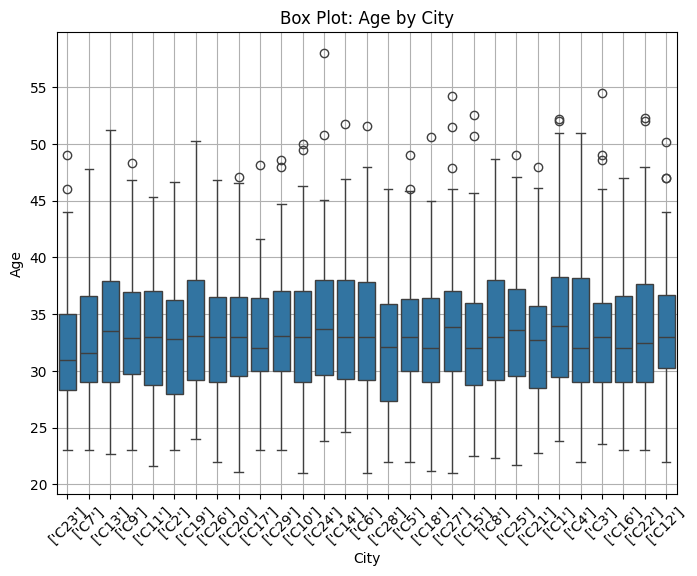

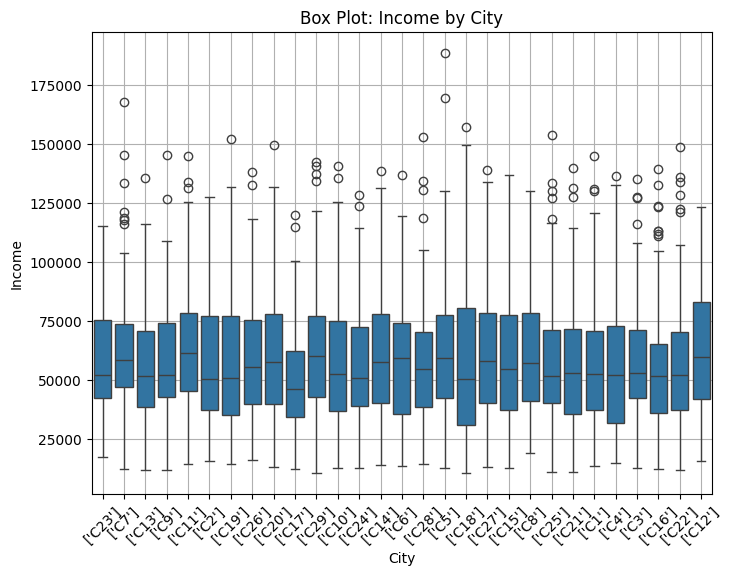

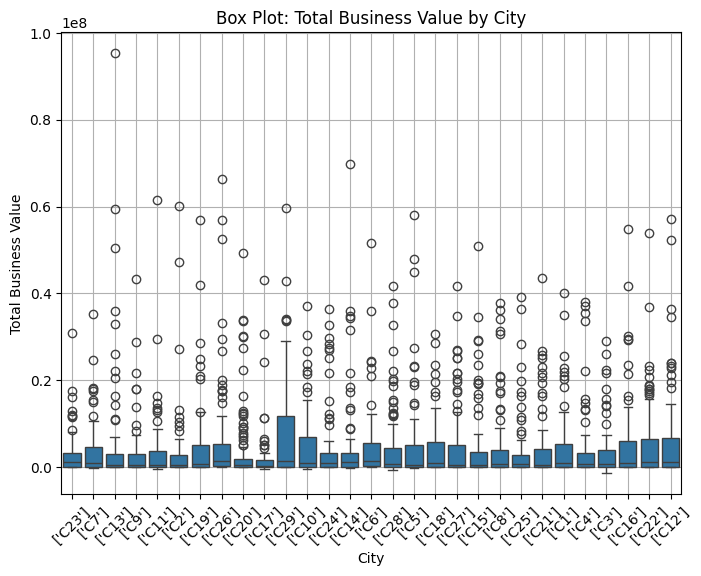

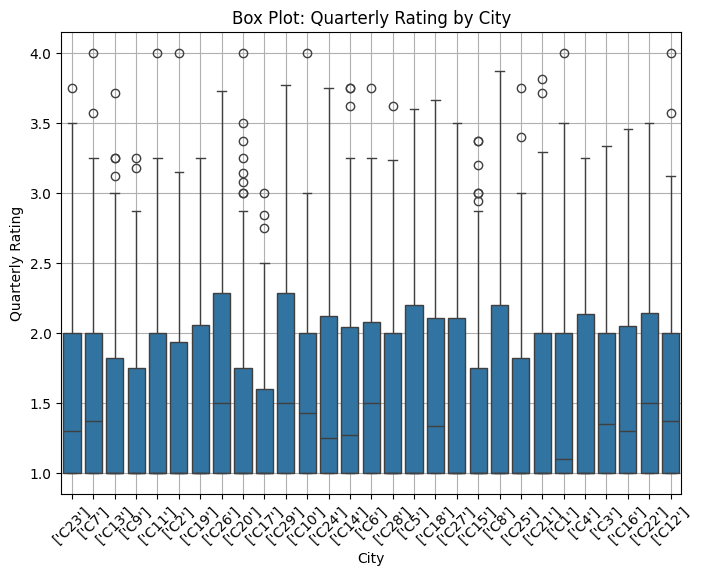

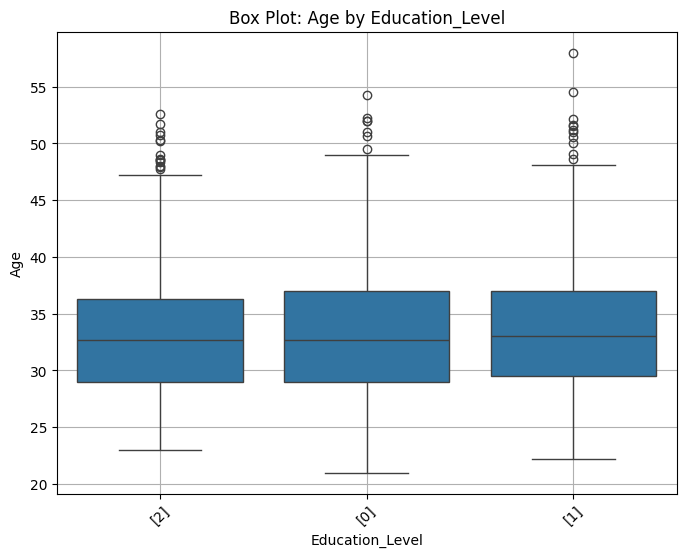

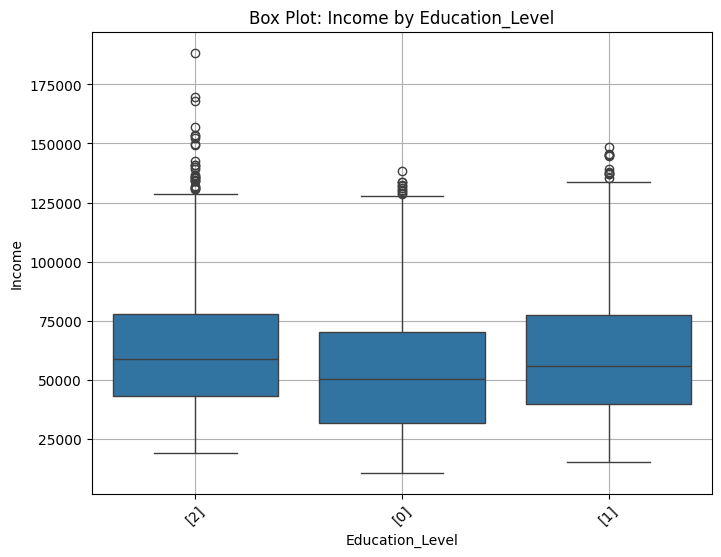

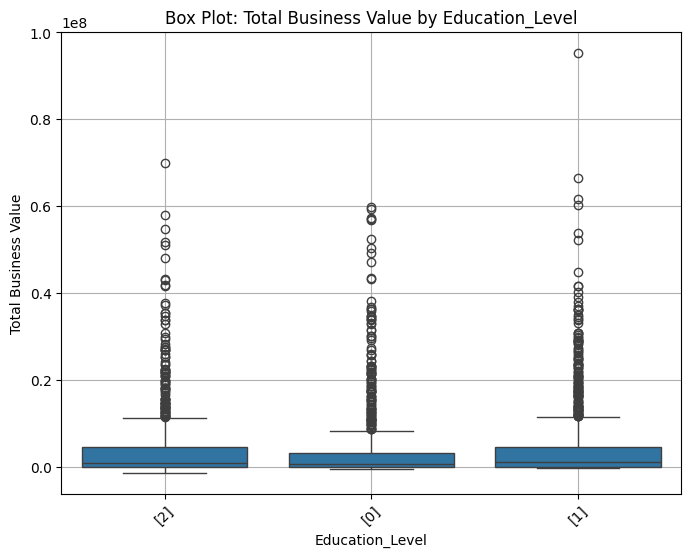

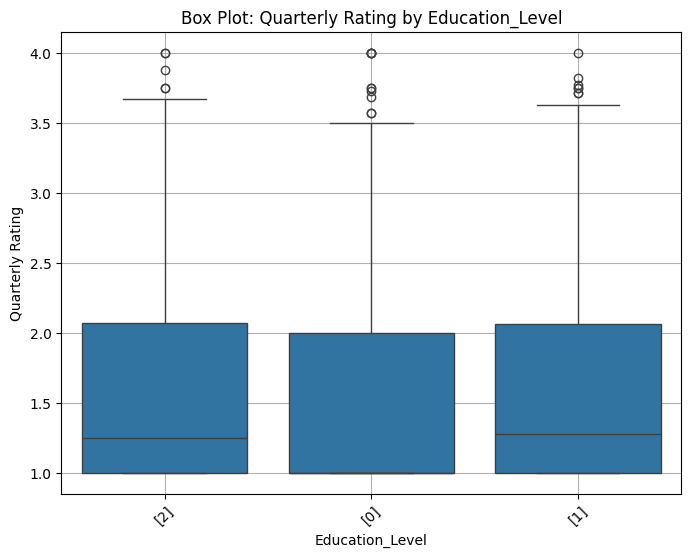

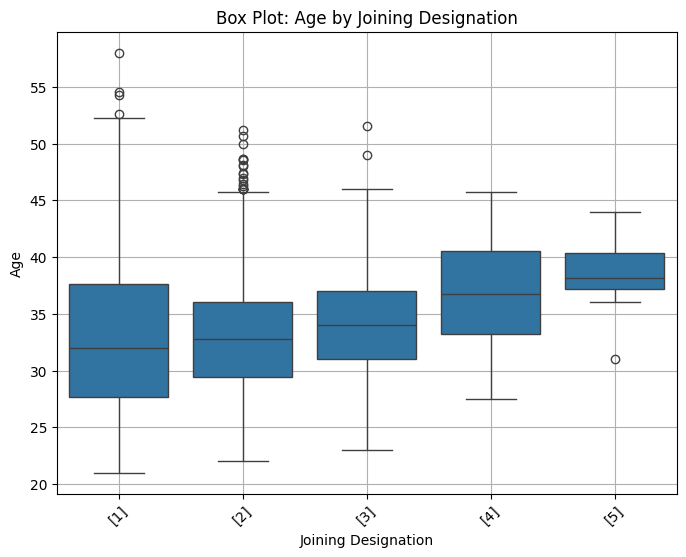

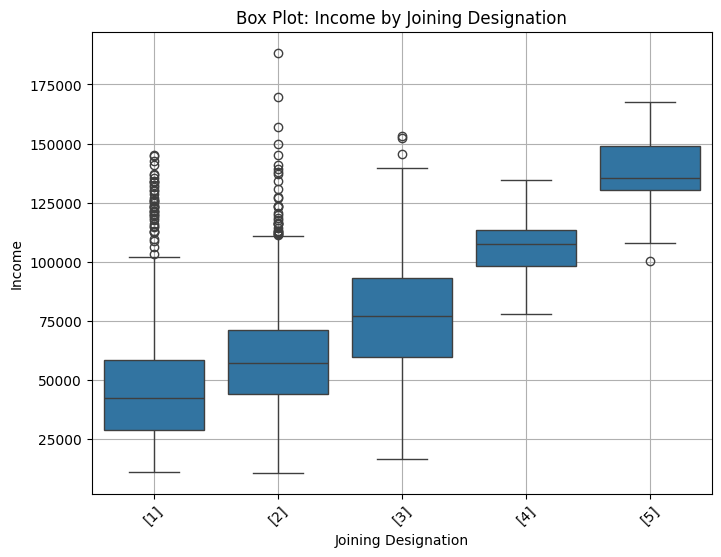

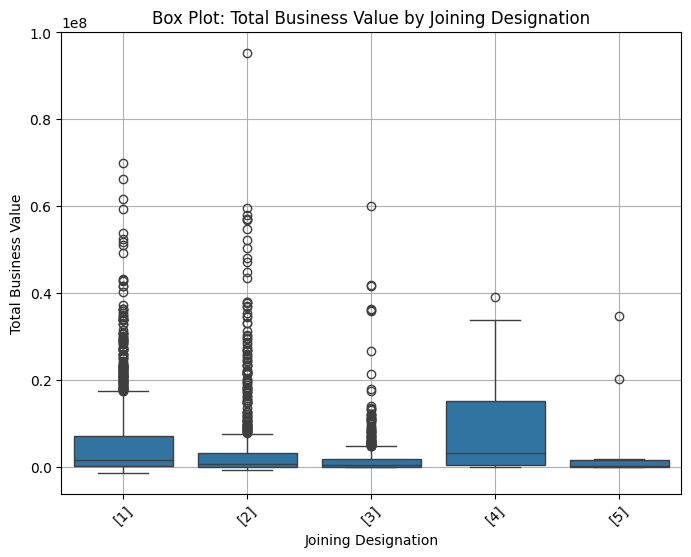

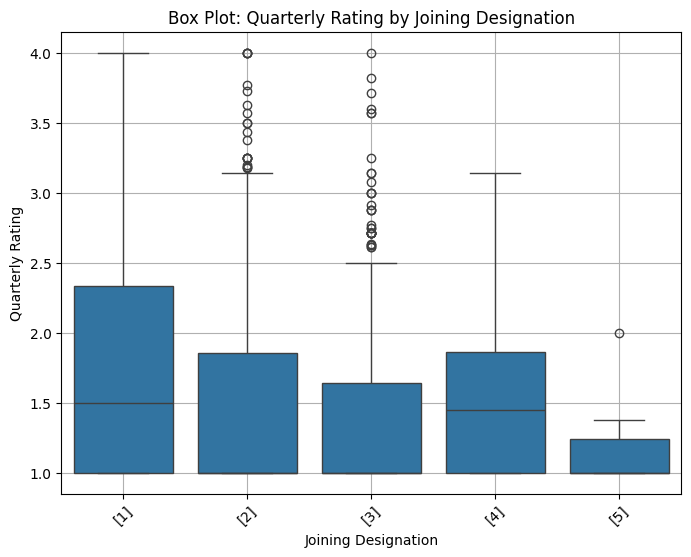

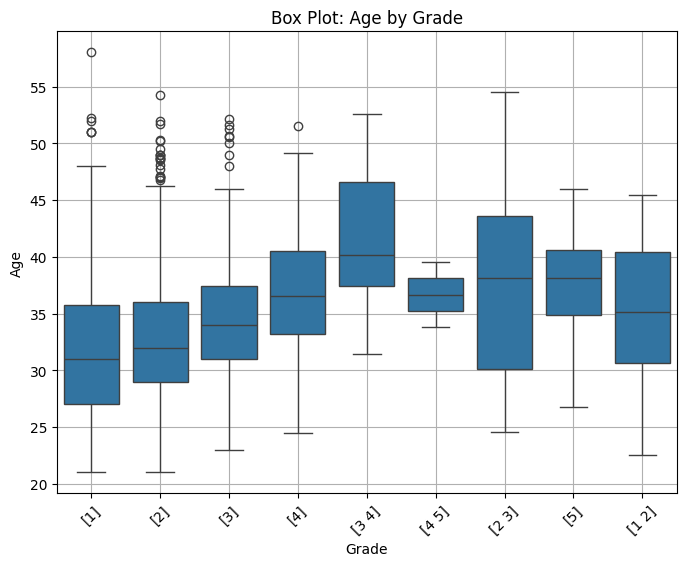

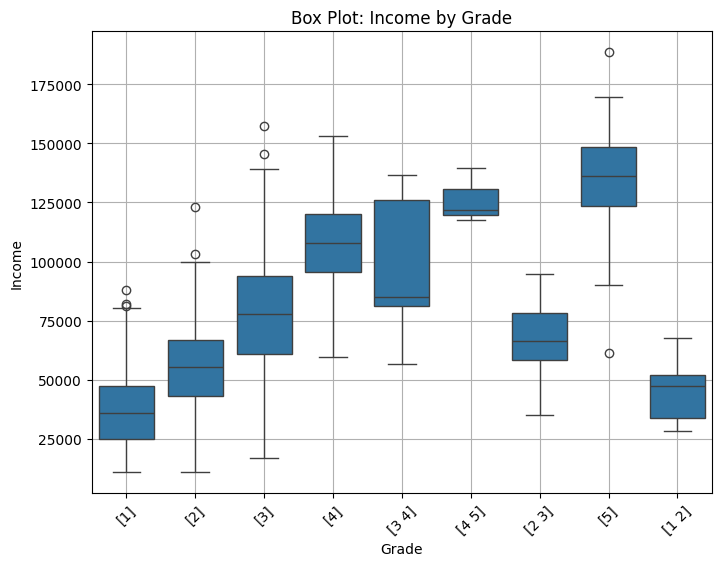

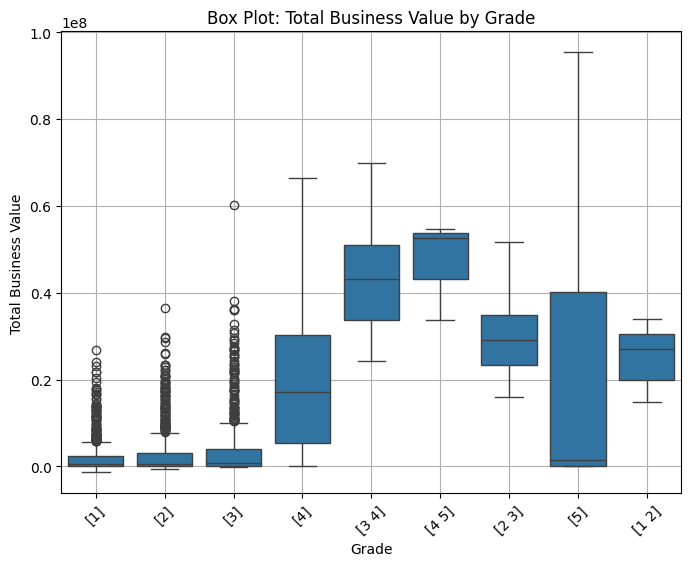

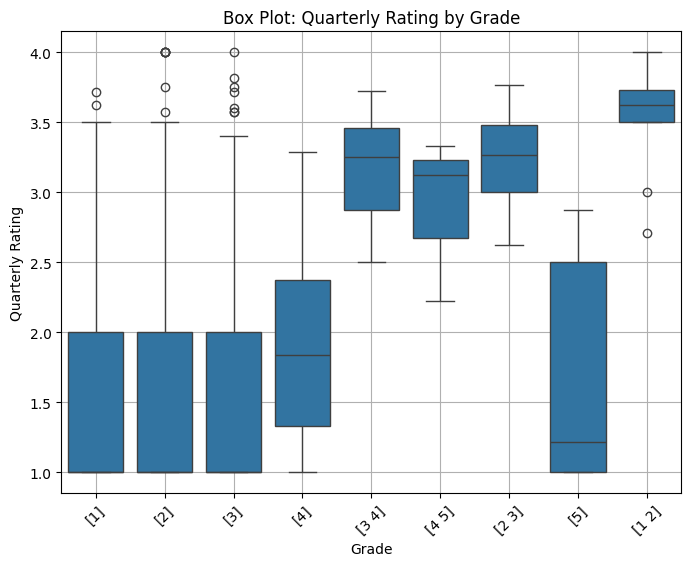

In [427]:
for cat_col in ['Gender', 'City', 'Education_Level', 'Joining Designation', 'Grade']:
    df[cat_col] = df[cat_col].astype(str)
plot_boxplots(df, df.select_dtypes(include=['object', 'category']).columns.tolist(), [col for col in df.select_dtypes(include=['int64', 'float64']).columns if col != 'Driver_ID'])

## Analysis of Columns with Categorical-Numerical Relationship:
- **Age by Gender:**  
  Both genders show a similar distribution of ages. The median age is consistent across genders, and a few outliers with higher ages are observed for both groups.

- **Income by Gender:**  
  The distribution of income is similar for both genders, with a slightly higher number of outliers at higher income levels for one gender. Median income remains consistent, indicating no significant gender-based disparity.

- **Total Business Value by Gender:**  
  The distribution of total business value is narrow for most data points, but both genders exhibit numerous outliers. Median values show minimal variation.

- **Quarterly Rating by Gender:**  
  Ratings are consistent between genders, although one group has a slightly wider distribution. A few outliers are present at higher ratings.

- **Age by City:**  
  Most cities have a similar age range and median values. Certain cities exhibit more outliers, reflecting a broader age distribution.

- **Income by City:**  
  Income distribution across cities is comparable. However, some cities have slightly higher income medians, suggesting location-based earning variations.

- **Education Level Analysis:**  
  - **Age:** Median ages across education levels are similar, with slightly older individuals in higher education levels.  
  - **Income:** Higher education correlates with slightly higher income, although medians remain close.  
  - **Total Business Value:** Minimal differences are observed across education levels, but significant outliers exist.  
  - **Quarterly Rating:** Ratings are consistent across education levels, with minimal variations.

- **Joining Designation:**  
  - **Age:** Higher designations are associated with older employees, indicated by a median shift.  
  - **Income:** An upward trend in income is observed with higher designations.  
  - **Total Business Value:** Higher designations generally correspond to larger business values, with notable outliers.  
  - **Quarterly Rating:** Median ratings slightly decline with higher designations.

- **Grade-Based Observations:**  
  - **Age:** Predictably, age increases with grade level.  
  - **Income:** Higher grades exhibit a rise in income.  
  - **Total Business Value:** Total business value increases with grade level, accompanied by more outliers.  
  - **Quarterly Rating:** Rating distributions vary more across grades, with higher grades showing more scattered data.

# Data Preprocessing

In [428]:
df

Driver_ID        Age Gender     City Education_Level   Income  \
0             1  28.000000   [0.]  ['C23']             [2]  57387.0   
1             2  31.000000   [0.]   ['C7']             [2]  67016.0   
2             4  43.000000   [0.]  ['C13']             [2]  65603.0   
3             5  29.000000   [0.]   ['C9']             [0]  46368.0   
4             6  31.000000   [1.]  ['C11']             [1]  78728.0   
...         ...        ...    ...      ...             ...      ...   
2376       2784  33.500000   [0.]  ['C24']             [0]  82815.0   
2377       2785  34.000000   [1.]   ['C9']             [0]  12105.0   
2378       2786  44.888889   [0.]  ['C19']             [0]  35370.0   
2379       2787  28.000000   [1.]  ['C20']             [2]  69498.0   
2380       2788  29.857143   [0.]  ['C27']             [2]  70254.0   

     Dateofjoining LastWorkingDate Joining Designation Grade  \
0       2018-12-24      2019-11-03                 [1]   [1]   
1       2020-06-11             NaT                 [2]   [2]   
2       2019-07-12      2020-04-27                 [2]   [2]   
3       2019-09-01      2019-07-03                 [1]   [1]   
4       2020-07-31             NaT                 [3]   [3]   
...            ...             ...                 ...   ...   
2376    2015-10-15             NaT                 [2]   [3]   
2377    2020-08-28      2020-10-28                 [1]   [1]   
2378    2018-07-31      2019-09-22                 [2]   [2]   
2379    2018-07-21      2019-06-20                 [1]   [1]   
2380    2020-08-06             NaT                 [2]   [2]   

      Total Business Value  Quarterly Rating  
0                  1715580          2.000000  
1                        0          1.000000  
2                   350000          1.000000  
3                   120360          1.000000  
4                  1265000          1.600000  
...                    ...               ...  
2376              21748820          2.625000  
2377                     0          1.000000  
2378               2815090          1.666667  
2379                977830          1.500000  
2380               2298240          2.285714  

[2381 rows x 12 columns]

In [429]:
df.duplicated().sum()

np.int64(0)

There are no duplicates

In [430]:
df.isnull().sum()

Driver_ID                 0
Age                       0
Gender                    0
City                      0
Education_Level           0
Income                    0
Dateofjoining             0
LastWorkingDate         765
Joining Designation       0
Grade                     0
Total Business Value      0
Quarterly Rating          0
dtype: int64

The null value is only in LastWorkingDate column and this null represents that the driver is still working/employed

From the Univariate Analysis of numerical Columns, we know there are outliners in all of them and below is the list of column names and number of outliners and well as % of data which are out liners
- Age: 23 (0.96%)
- Income: 47 (1.97%)
- Total Business Value: 336 (14.11%)
- Quarterly Rating: 28 (1.17%)
<br>
And all of them are above upper limit/Bound and also to avoid loss of information from other columns which will be the case of deletion, I will use clipping method


Age, IQR value is 8.0
Upper Limit/Bound: 49.0
Clipped Age: Max value is now 49.0


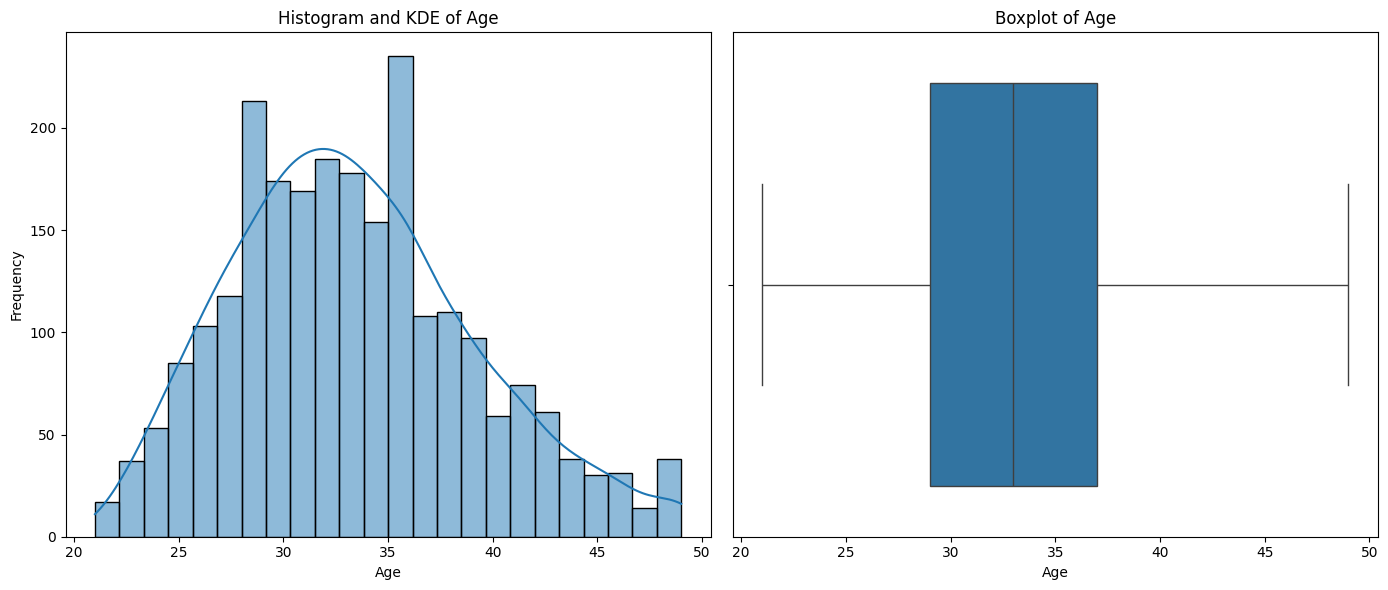


Income, IQR value is 36731.0
Upper Limit/Bound: 130931.5
Clipped Income: Max value is now 130931.5


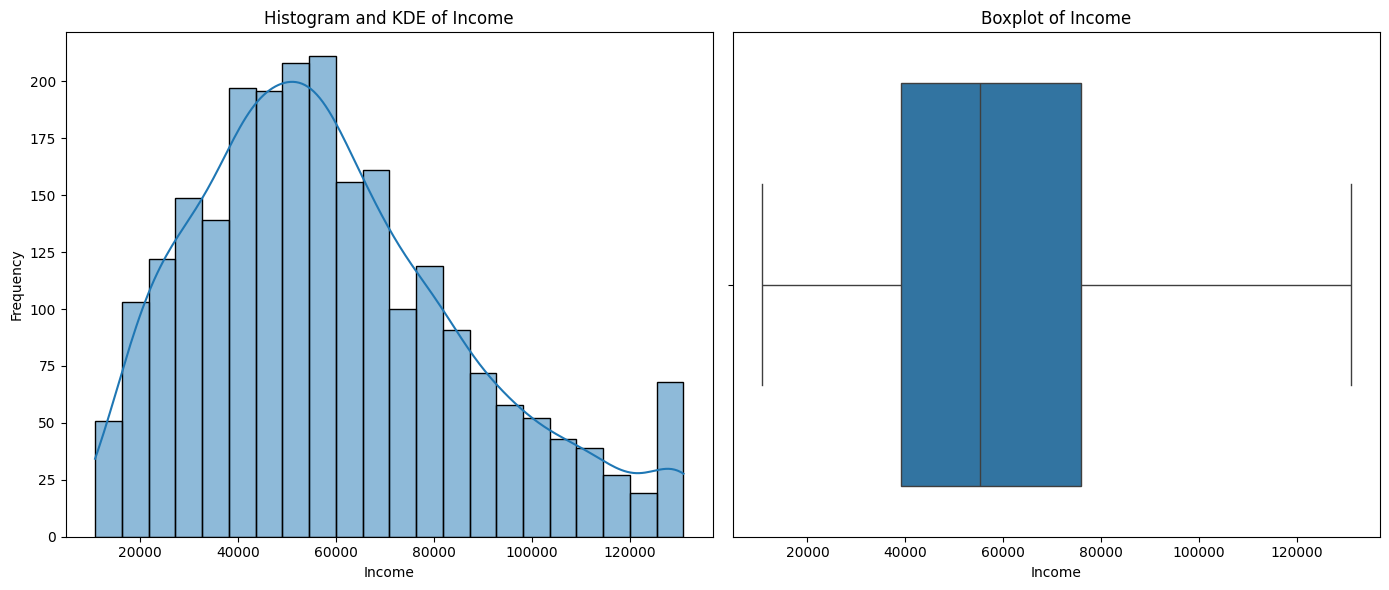


Total Business Value, IQR value is 4173650.0
Upper Limit/Bound: 10434125.0
Clipped Total Business Value: Max value is now 10434125


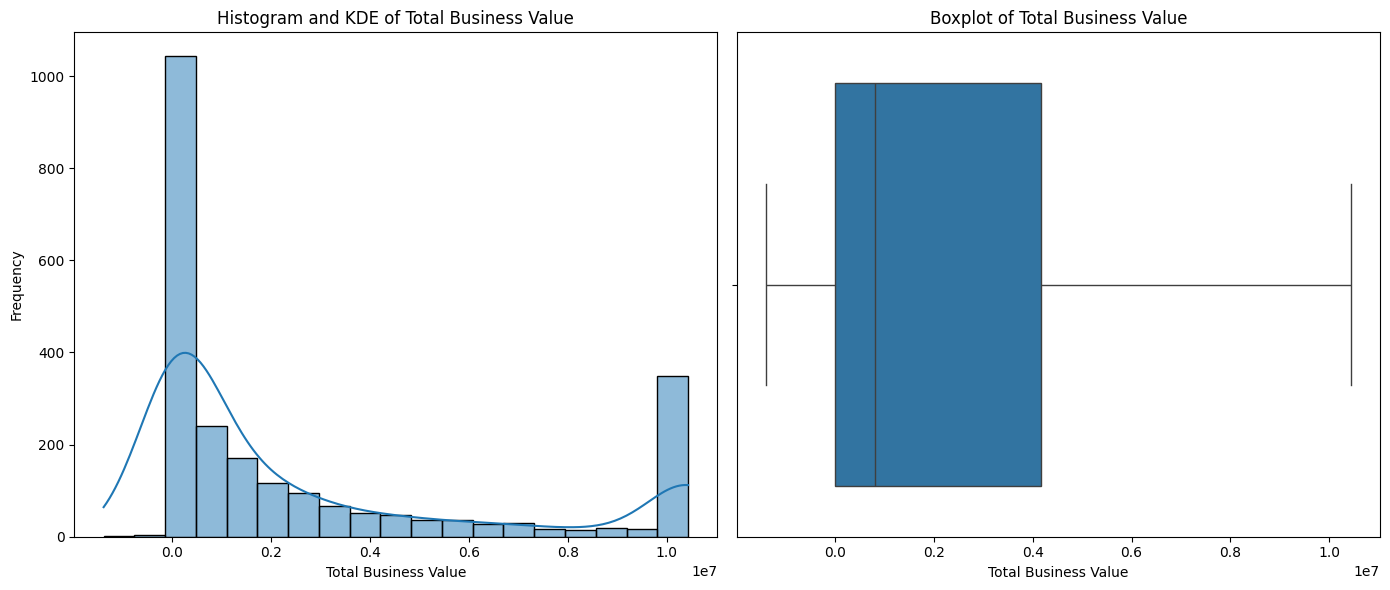


Quarterly Rating, IQR value is 1.0
Upper Limit/Bound: 3.5
Clipped Quarterly Rating: Max value is now 3.5


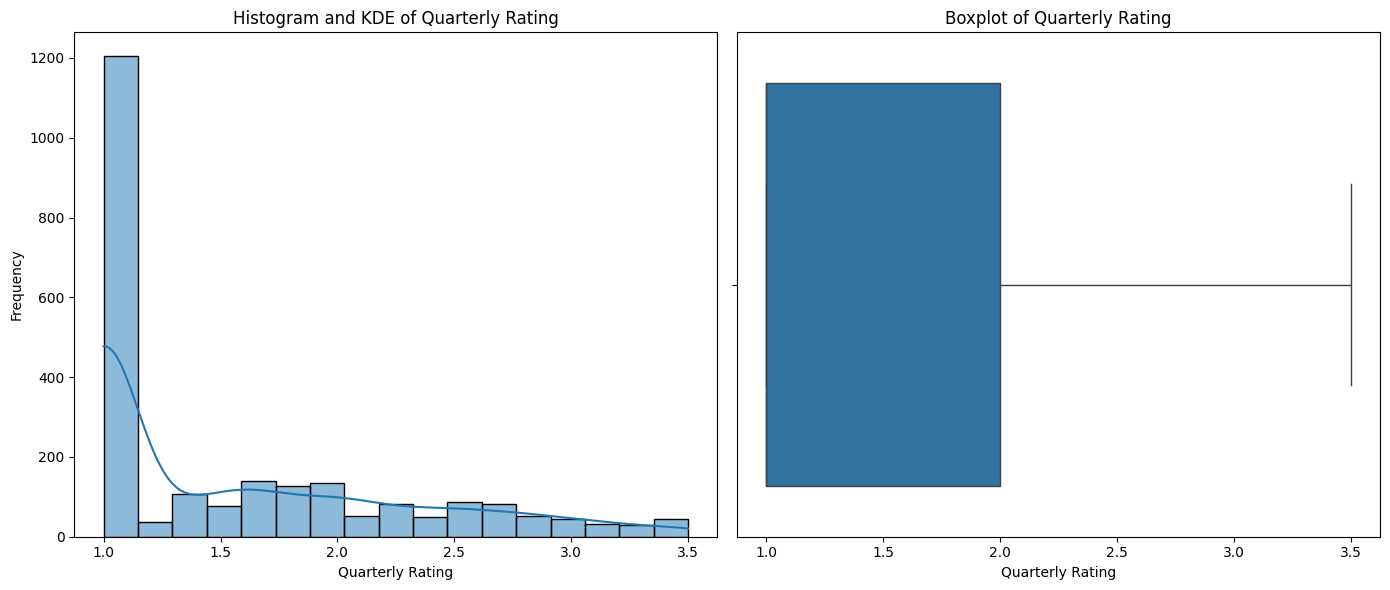

In [431]:
for i in [col for col in df.select_dtypes(include=['int64', 'float64']).columns if col != 'Driver_ID']:
    print(f"\n{i}, IQR value is {df[i].quantile(0.75)-df[i].quantile(0.25)}\nUpper Limit/Bound: {df[i].quantile(0.75)+1.5*(df[i].quantile(0.75)-df[i].quantile(0.25))}")
    df[i] = df[i].clip(upper=df[i].quantile(0.75)+1.5*(df[i].quantile(0.75)-df[i].quantile(0.25)))
    print(f"Clipped {i}: Max value is now {df[i].max()}")
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    sns.histplot(df[i], kde=True, ax=axes[0])
    axes[0].set_title(f'Histogram and KDE of {i}')
    axes[0].set_xlabel(i)
    axes[0].set_ylabel('Frequency')
    sns.boxplot(x=df[i], ax=axes[1])
    axes[1].set_title(f'Boxplot of {i}')
    axes[1].set_xlabel(i)
    plt.tight_layout()
    plt.show()

Now there are no outliners

Creating Target Variable/column using LastWorkingDate where value is 1 for Churn and null is 0 as Not Churn. Also creating new feature as employement duration by substracting Dateofjoining and LastWorkingDate (using current date whenever there is null) and extracting day, month and year from Dateofjoining

In [432]:
df['Target'] = df['LastWorkingDate'].notnull().astype(int)
df['LastWorkingDate1']=df['LastWorkingDate']
df['LastWorkingDate1'].fillna(datetime.now(), inplace=True)
df['EmployementDuration'] = (df['LastWorkingDate1'] - df['Dateofjoining']).dt.days // 30
df['Year_of_Joining'] = df['Dateofjoining'].dt.year
df['Month_of_Joining'] = df['Dateofjoining'].dt.month
df['Day_of_Joining'] = df['Dateofjoining'].dt.day
df.drop(columns=['LastWorkingDate', 'LastWorkingDate1', 'Dateofjoining'], inplace=True)
df.head()

Driver_ID   Age Gender     City Education_Level   Income  \
0          1  28.0   [0.]  ['C23']             [2]  57387.0   
1          2  31.0   [0.]   ['C7']             [2]  67016.0   
2          4  43.0   [0.]  ['C13']             [2]  65603.0   
3          5  29.0   [0.]   ['C9']             [0]  46368.0   
4          6  31.0   [1.]  ['C11']             [1]  78728.0   

  Joining Designation Grade  Total Business Value  Quarterly Rating  Target  \
0                 [1]   [1]               1715580               2.0       1   
1                 [2]   [2]                     0               1.0       0   
2                 [2]   [2]                350000               1.0       1   
3                 [1]   [1]                120360               1.0       1   
4                 [3]   [3]               1265000               1.6       0   

   EmployementDuration  Year_of_Joining  Month_of_Joining  Day_of_Joining  
0                   10             2018                12              24  
1                   56             2020                 6              11  
2                    9             2019                 7              12  
3                   -2             2019                 9               1  
4                   54             2020                 7              31

In [433]:
df[df.EmployementDuration<0]

Driver_ID   Age Gender     City Education_Level   Income  \
3             5  29.0   [0.]   ['C9']             [0]  46368.0   
12           18  27.0   [1.]  ['C17']             [1]  31631.0   
23           35  32.0   [0.]   ['C5']             [1]  68070.0   
45           59  35.0   [1.]  ['C18']             [1]  31644.0   
66           82  37.0   [1.]  ['C24']             [1]  89013.0   
...         ...   ...    ...      ...             ...      ...   
2301       2698  26.0   [0.]  ['C21']             [1]  58892.0   
2304       2701  25.0   [0.]  ['C14']             [1]  64281.0   
2316       2713  32.0   [1.]   ['C9']             [2]  23582.0   
2335       2733  29.0   [0.]  ['C10']             [2]  56659.0   
2345       2745  33.0   [0.]  ['C26']             [1]  46734.0   

     Joining Designation Grade  Total Business Value  Quarterly Rating  \
3                    [1]   [1]                120360               1.0   
12                   [1]   [1]                     0               1.0   
23                   [3]   [3]                300000               1.0   
45                   [1]   [1]                134660               1.0   
66                   [3]   [3]                     0               1.0   
...                  ...   ...                   ...               ...   
2301                 [2]   [2]                     0               1.0   
2304                 [1]   [1]                     0               1.0   
2316                 [2]   [2]                300000               1.0   
2335                 [2]   [2]                     0               1.0   
2345                 [3]   [3]                     0               1.0   

      Target  EmployementDuration  Year_of_Joining  Month_of_Joining  \
3          1                   -2             2019                 9   
12         1                   -5             2019                 9   
23         1                   -2             2020                 7   
45         1                   -3             2019                 6   
66         1                   -4             2020                11   
...      ...                  ...              ...               ...   
2301       1                   -3             2020                 3   
2304       1                   -3             2019                 7   
2316       1                   -3             2019                 6   
2335       1                   -1             2020                12   
2345       1                   -1             2020                 3   

      Day_of_Joining  
3                  1  
12                 1  
23                 3  
45                 1  
66                 4  
...              ...  
2301              17  
2304              18  
2316              30  
2335               9  
2345              14  

[135 rows x 15 columns]

It seems there are drivers whose employment duration is negative, which doesn't make sense. It would be better to verify the original dataset to determine whether this is a true case or if there was a mistake made during the coding/modification process.

In [434]:
df1 = pd.read_csv('data.csv')
df1=pd.read_csv('data.csv', usecols=lambda column: column != df1.columns[0])
df1[df1.Driver_ID == 5]

MMM-YY  Driver_ID   Age  Gender City  Education_Level  Income  \
10  01/01/19          5  29.0     0.0   C9                0   46368   
11  02/01/19          5  29.0     0.0   C9                0   46368   
12  03/01/19          5  29.0     0.0   C9                0   46368   

   Dateofjoining LastWorkingDate  Joining Designation  Grade  \
10      01/09/19             NaN                    1      1   
11      01/09/19             NaN                    1      1   
12      01/09/19        03/07/19                    1      1   

    Total Business Value  Quarterly Rating  
10                     0                 1  
11                120360                 1  
12                     0                 1

So the data is wrong for these drivers and it is better to delete those rows as it will hamper the model's result. 

In [435]:
df=df[df.EmployementDuration>=0]
df.head(10)

Driver_ID        Age Gender     City Education_Level    Income  \
0           1  28.000000   [0.]  ['C23']             [2]   57387.0   
1           2  31.000000   [0.]   ['C7']             [2]   67016.0   
2           4  43.000000   [0.]  ['C13']             [2]   65603.0   
4           6  31.000000   [1.]  ['C11']             [1]   78728.0   
5           8  34.000000   [0.]   ['C2']             [0]   70656.0   
6          11  28.000000   [1.]  ['C19']             [2]   42172.0   
7          12  35.000000   [0.]  ['C23']             [2]   28116.0   
8          13  29.608696   [0.]  ['C19']             [2]  119227.0   
9          14  39.000000   [1.]  ['C26']             [0]   19734.0   
10         16  30.000000   [1.]  ['C23']             [0]   52963.0   

   Joining Designation Grade  Total Business Value  Quarterly Rating  Target  \
0                  [1]   [1]               1715580           2.00000       1   
1                  [2]   [2]                     0           1.00000       0   
2                  [2]   [2]                350000           1.00000       1   
4                  [3]   [3]               1265000           1.60000       0   
5                  [3]   [3]                     0           1.00000       1   
6                  [1]   [1]                     0           1.00000       0   
7                  [1]   [1]               2607180           2.50000       1   
8                  [1]   [4]              10213040           1.26087       1   
9                  [3]   [3]                     0           1.00000       0   
10                 [2]   [2]                346800           1.00000       1   

    EmployementDuration  Year_of_Joining  Month_of_Joining  Day_of_Joining  
0                    10             2018                12              24  
1                    56             2020                 6              11  
2                     9             2019                 7              12  
4                    54             2020                 7              31  
5                     1             2020                 9              19  
6                    55             2020                 7              12  
7                     5             2019                 6              29  
8                    66             2015                 5              28  
9                    52             2020                10              16  
10                    2             2018                11              30

In [436]:
df['Gender']=df['Gender'].str.extract(r'(\d+)').astype(int)
df['Education_Level']=df['Education_Level'].str.extract(r'(\d+)').astype(int)
df['Joining Designation']=df['Joining Designation'].str.extract(r'(\d+)').astype(int)
df['Grade']=df['Grade'].str.extract(r'(\d+)').astype(int)
df['City'] = df['City'].str.strip("[]'")

In [437]:
df.head()

Driver_ID   Age  Gender City  Education_Level   Income  \
0          1  28.0       0  C23                2  57387.0   
1          2  31.0       0   C7                2  67016.0   
2          4  43.0       0  C13                2  65603.0   
4          6  31.0       1  C11                1  78728.0   
5          8  34.0       0   C2                0  70656.0   

   Joining Designation  Grade  Total Business Value  Quarterly Rating  Target  \
0                    1      1               1715580               2.0       1   
1                    2      2                     0               1.0       0   
2                    2      2                350000               1.0       1   
4                    3      3               1265000               1.6       0   
5                    3      3                     0               1.0       1   

   EmployementDuration  Year_of_Joining  Month_of_Joining  Day_of_Joining  
0                   10             2018                12              24  
1                   56             2020                 6              11  
2                    9             2019                 7              12  
4                   54             2020                 7              31  
5                    1             2020                 9              19

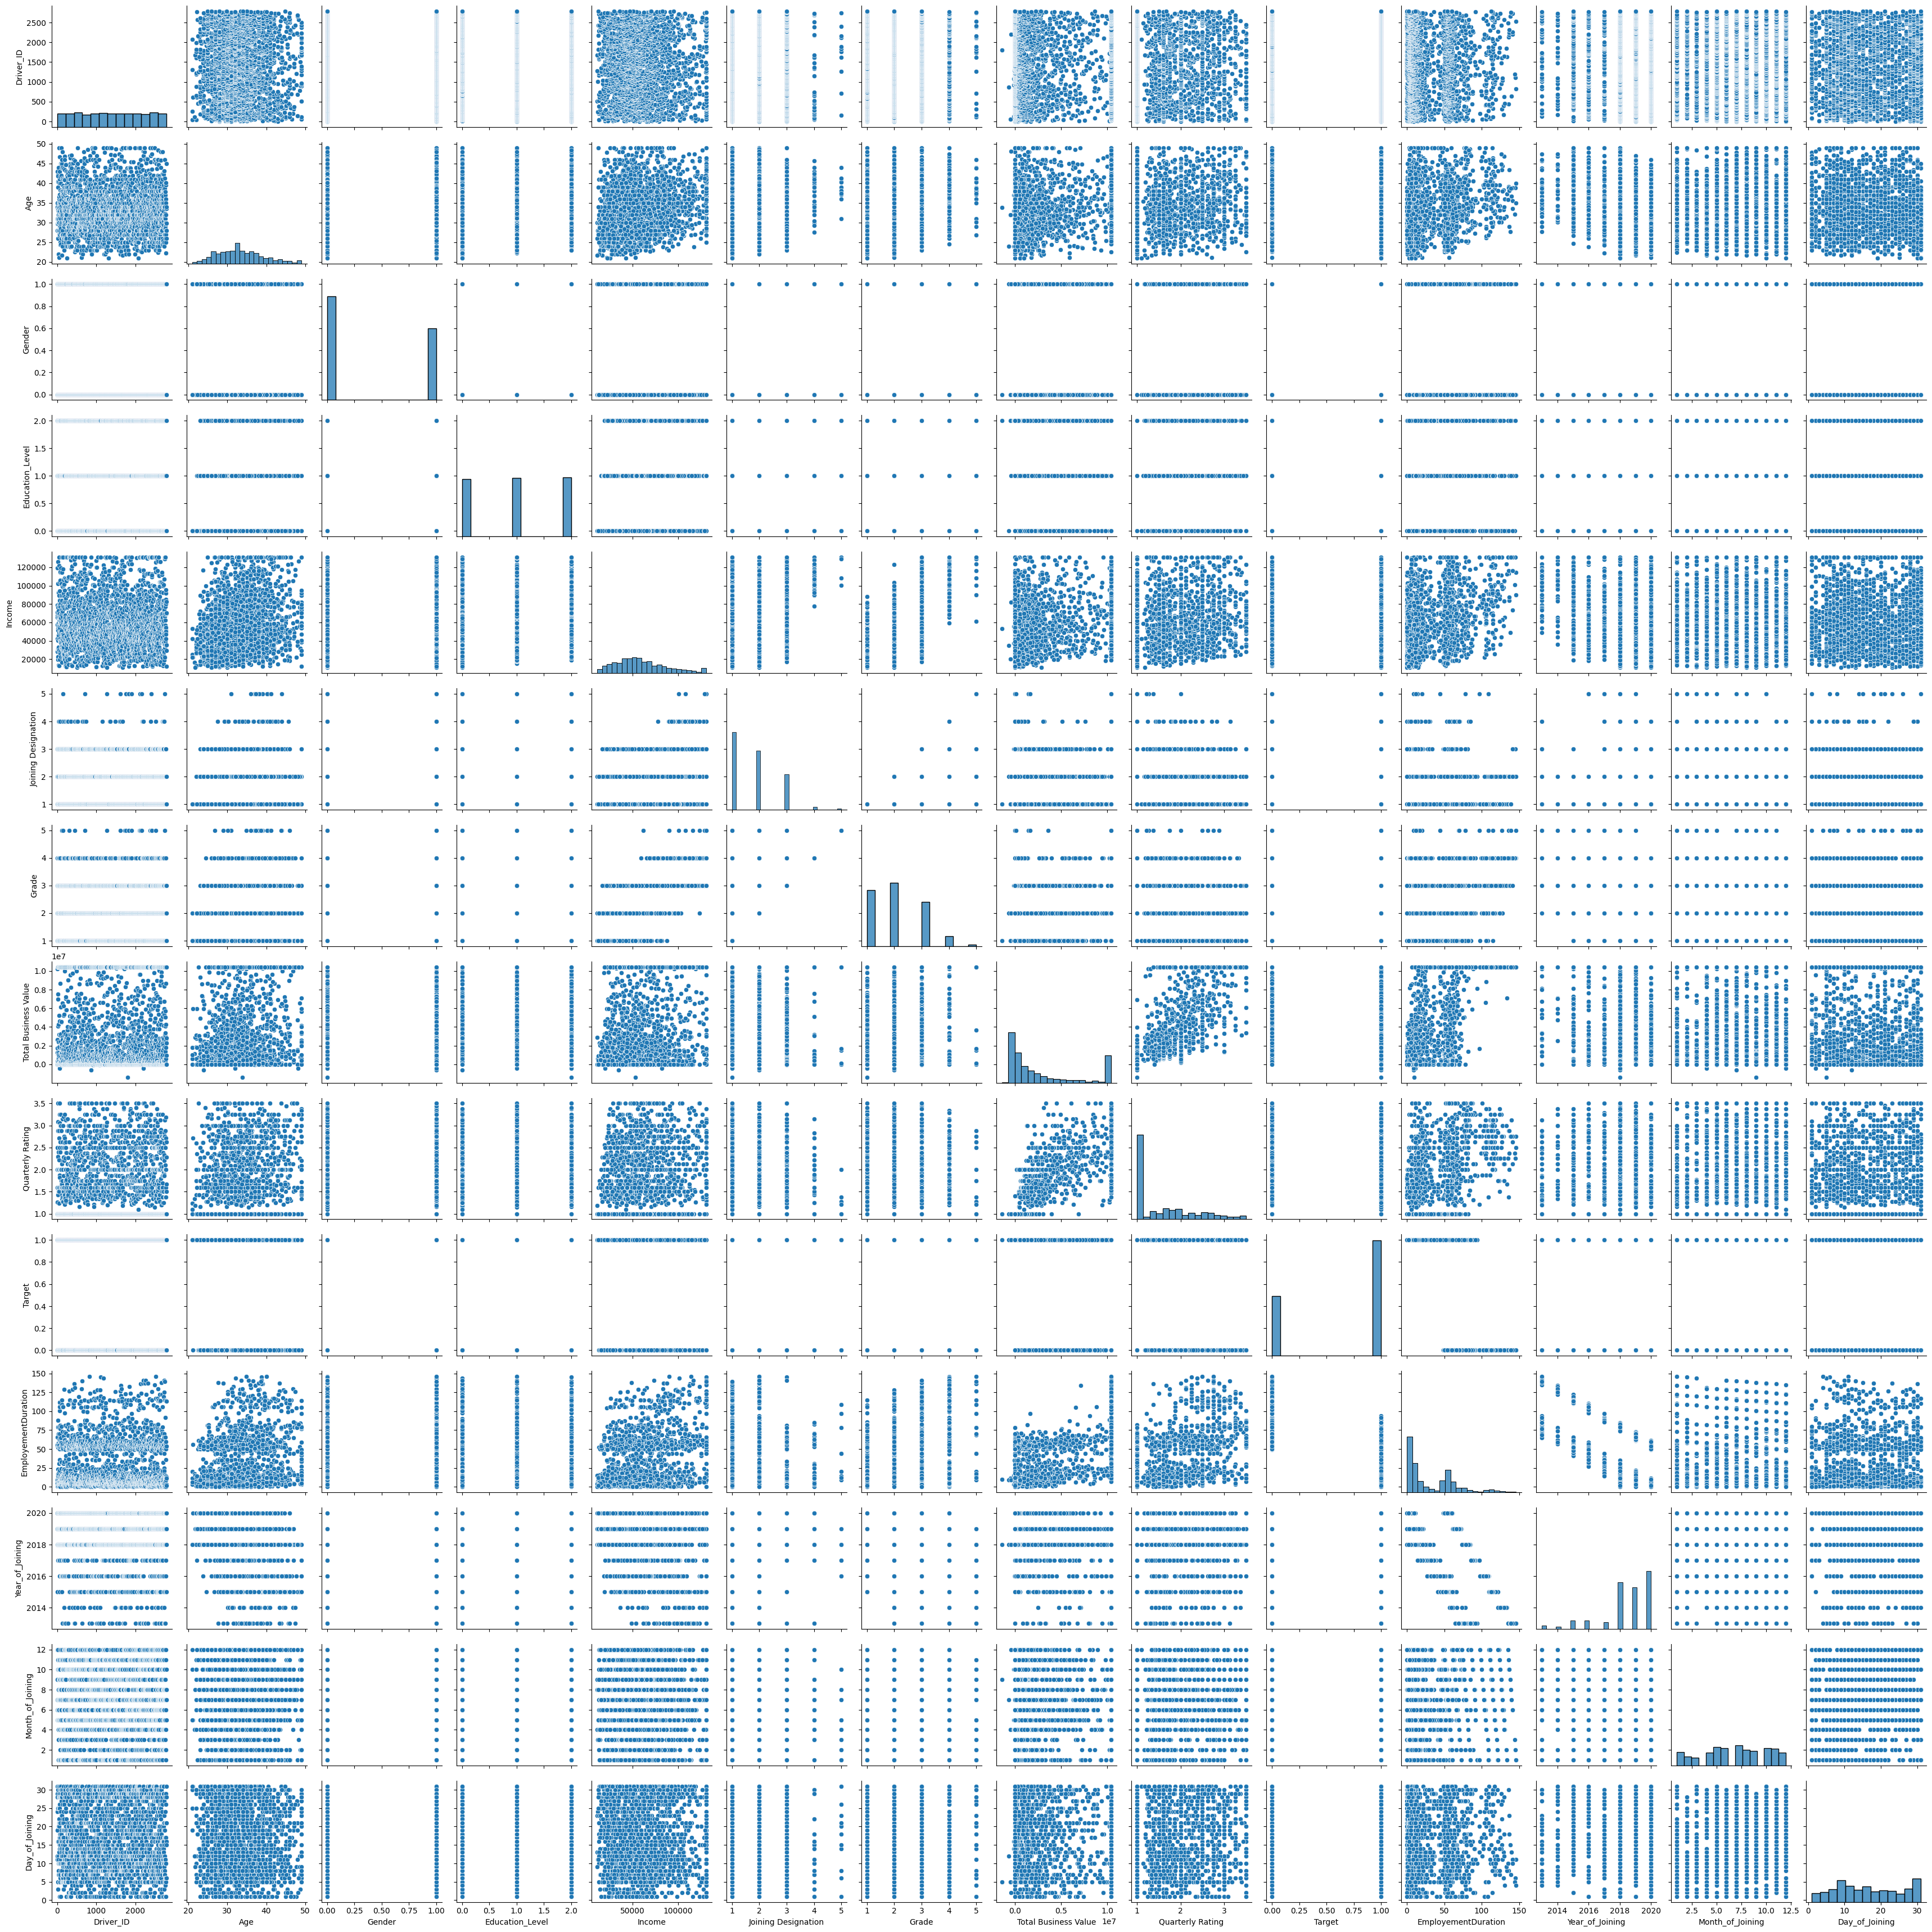

In [438]:
sns.pairplot(df);

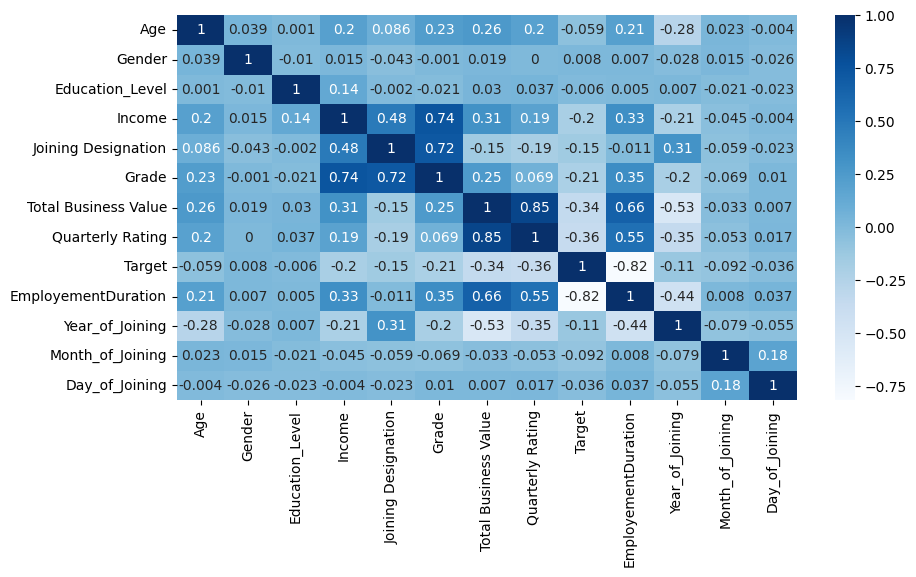

In [439]:
plt.figure(figsize=(10,5))
sns.heatmap(round(df.select_dtypes(include=['int64', 'float64', 'int32']).drop(columns='Driver_ID').corr(),3), annot=True, cmap='Blues');

#### Analysis and Insights:
- **Target Variable (Target):**
    - EmployementDuration has a strong negative correlation (-0.818) with the target. Employees with longer employment durations are less likely to churn.
    - Total Business Value and Quarterly Rating show moderate negative correlations (-0.345 and -0.357), indicating that high-performing employees contribute more and are less likely to leave.
    - The weak negative correlations with features like Income (-0.200) and Grade (-0.212) suggest they may have a smaller but noteworthy influence.
- **Feature Relationships:**
    - EmployementDuration: Strong positive correlation with Total Business Value (0.657) and Quarterly Rating (0.548), indicating that longer-tenured employees contribute more business value and achieve better ratings. Moderate negative correlation with Year_of_Joining (-0.444), showing that more recently joined employees typically have shorter durations.
    - Income: Very strong positive correlation with Grade (0.740) and moderate correlation with Joining Designation (0.484), reinforcing the connection between grade/designation and salary.
    - Total Business Value vs Quarterly Rating: Very strong positive correlation (0.854) suggests high contributions often accompany better performance ratings.
- **Date Features:**
    - Year_of_Joining: Strong negative correlation with Total Business Value (-0.531), suggesting that employees who joined earlier tend to contribute more value. Moderate negative correlation with EmployementDuration (-0.444), aligning with the expectation that earlier joining dates result in longer durations.
- Month_of_Joining and Day_of_Joining: Weak correlations with other features indicate they may have limited predictive power individually.
- **Multicollinearity Concerns:**
    - Income, Grade, and Joining Designation are highly interrelated (e.g., Income and Grade: 0.740, Grade and Joining Designation: 0.723), which might introduce multicollinearity. Regularization techniques like Lasso or feature selection can mitigate this issue.
    - Total Business Value and Quarterly Rating have a very high correlation (0.854), and it may be redundant to include both in some models.
- **Predictive Features for ML Models:**
    - EmployementDuration, Total Business Value, and Quarterly Rating are the strongest predictors for the target.
    - Date-based features like Year_of_Joining add meaningful temporal insights but may need scaling or encoding.
    - Features like Gender and Day_of_Joining have negligible correlations with the target and other features, suggesting lower predictive utility.

# Model Building

In [440]:
df

Driver_ID        Age  Gender City  Education_Level   Income  \
0             1  28.000000       0  C23                2  57387.0   
1             2  31.000000       0   C7                2  67016.0   
2             4  43.000000       0  C13                2  65603.0   
4             6  31.000000       1  C11                1  78728.0   
5             8  34.000000       0   C2                0  70656.0   
...         ...        ...     ...  ...              ...      ...   
2376       2784  33.500000       0  C24                0  82815.0   
2377       2785  34.000000       1   C9                0  12105.0   
2378       2786  44.888889       0  C19                0  35370.0   
2379       2787  28.000000       1  C20                2  69498.0   
2380       2788  29.857143       0  C27                2  70254.0   

      Joining Designation  Grade  Total Business Value  Quarterly Rating  \
0                       1      1               1715580          2.000000   
1                       2      2                     0          1.000000   
2                       2      2                350000          1.000000   
4                       3      3               1265000          1.600000   
5                       3      3                     0          1.000000   
...                   ...    ...                   ...               ...   
2376                    2      3              10434125          2.625000   
2377                    1      1                     0          1.000000   
2378                    2      2               2815090          1.666667   
2379                    1      1                977830          1.500000   
2380                    2      2               2298240          2.285714   

      Target  EmployementDuration  Year_of_Joining  Month_of_Joining  \
0          1                   10             2018                12   
1          0                   56             2020                 6   
2          1                    9             2019                 7   
4          0                   54             2020                 7   
5          1                    1             2020                 9   
...      ...                  ...              ...               ...   
2376       0                  113             2015                10   
2377       1                    2             2020                 8   
2378       1                   13             2018                 7   
2379       1                   11             2018                 7   
2380       0                   54             2020                 8   

      Day_of_Joining  
0                 24  
1                 11  
2                 12  
4                 31  
5                 19  
...              ...  
2376              15  
2377              28  
2378              31  
2379              21  
2380               6  

[2246 rows x 15 columns]

Now the City column is string and need to convert into numerical format so we are going to use Target Encoding with smoothing for the reduction of overfitting

In [441]:
global_mean = df['Target'].mean()
def target_encode_city(df, city_column, target_column, smoothing_factor=10):
    mean_per_category = df.groupby(city_column)[target_column].mean()
    count_per_category = df.groupby(city_column)[target_column].count()
    smooth_mean = (mean_per_category * count_per_category + global_mean * smoothing_factor) / (count_per_category + smoothing_factor)
    df[city_column] = df[city_column].map(smooth_mean)
    return df
df = target_encode_city(df, city_column='City', target_column='Target', smoothing_factor=10)
df

Driver_ID        Age  Gender      City  Education_Level   Income  \
0             1  28.000000       0  0.734986                2  57387.0   
1             2  31.000000       0  0.661654                2  67016.0   
2             4  43.000000       0  0.778297                2  65603.0   
4             6  31.000000       1  0.684422                1  78728.0   
5             8  34.000000       0  0.734986                0  70656.0   
...         ...        ...     ...       ...              ...      ...   
2376       2784  33.500000       0  0.674281                0  82815.0   
2377       2785  34.000000       1  0.686345                0  12105.0   
2378       2786  44.888889       0  0.569924                0  35370.0   
2379       2787  28.000000       1  0.717159                2  69498.0   
2380       2788  29.857143       0  0.639933                2  70254.0   

      Joining Designation  Grade  Total Business Value  Quarterly Rating  \
0                       1      1               1715580          2.000000   
1                       2      2                     0          1.000000   
2                       2      2                350000          1.000000   
4                       3      3               1265000          1.600000   
5                       3      3                     0          1.000000   
...                   ...    ...                   ...               ...   
2376                    2      3              10434125          2.625000   
2377                    1      1                     0          1.000000   
2378                    2      2               2815090          1.666667   
2379                    1      1                977830          1.500000   
2380                    2      2               2298240          2.285714   

      Target  EmployementDuration  Year_of_Joining  Month_of_Joining  \
0          1                   10             2018                12   
1          0                   56             2020                 6   
2          1                    9             2019                 7   
4          0                   54             2020                 7   
5          1                    1             2020                 9   
...      ...                  ...              ...               ...   
2376       0                  113             2015                10   
2377       1                    2             2020                 8   
2378       1                   13             2018                 7   
2379       1                   11             2018                 7   
2380       0                   54             2020                 8   

      Day_of_Joining  
0                 24  
1                 11  
2                 12  
4                 31  
5                 19  
...              ...  
2376              15  
2377              28  
2378              31  
2379              21  
2380               6  

[2246 rows x 15 columns]

#### Train - Validate - Test Split

In [442]:
from sklearn.model_selection import train_test_split
X=df.drop(columns=['Driver_ID', 'Target'])
y=df['Target']
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [443]:
X_train.shape[0], y_train.shape[0], X_val.shape[0], y_val.shape[0], X_test.shape[0], y_test.shape[0]

(1572, 1572, 337, 337, 337, 337)

The split is in 70-15-15% ratio (train-validate-test)

In [444]:
y_train.value_counts()

Target
1    1046
0     526
Name: count, dtype: int64

Data is highly inbalance

#### Addressing Class Imbalance

In [445]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

In [446]:
X_train.shape[0], y_train.shape[0]

(2092, 2092)

In [447]:
y_train.value_counts()

Target
0    1046
1    1046
Name: count, dtype: int64

Data is now balanced

#### Scaling Data

In [448]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [451]:
pd.DataFrame(X_train)

0    1         2    3         4     5     6         7         8   \
0     0.535714  1.0  0.552004  1.0  0.851333  0.50  0.50  0.068011  0.000000   
1     0.550000  1.0  0.822309  0.5  0.683890  0.50  0.50  0.131431  0.000000   
2     0.416667  0.0  0.000000  1.0  0.367502  0.50  0.50  0.264163  0.400000   
3     0.714286  0.0  0.000000  1.0  0.752809  0.75  0.75  0.128798  0.000000   
4     0.387755  1.0  0.200628  0.5  0.264743  0.25  0.25  0.406472  0.257143   
...        ...  ...       ...  ...       ...   ...   ...       ...       ...   
2087  0.446172  0.0  0.736568  0.5  0.724034  0.00  0.50  1.000000  0.475710   
2088  0.312015  0.0  0.257612  0.5  0.781560  0.25  0.50  1.000000  0.935237   
2089  0.502489  0.0  0.303506  0.0  0.130554  0.00  0.00  1.000000  0.769393   
2090  0.408996  0.0  0.653378  0.0  0.467210  0.25  0.25  0.040401  0.000000   
2091  0.551194  0.0  0.246096  1.0  0.448291  0.25  0.25  0.055055  0.000000   

            9         10        11        12  
0     0.417808  1.000000  0.000000  0.266667  
1     0.363014  1.000000  0.727273  0.233333  
2     0.376712  1.000000  0.545455  0.400000  
3     0.020548  1.000000  0.545455  0.700000  
4     0.068493  0.857143  0.454545  0.633333  
...        ...       ...       ...       ...  
2087  0.856164  0.142857  0.454545  0.166667  
2088  0.472603  0.857143  0.000000  0.133333  
2089  0.664384  0.428571  0.545455  0.833333  
2090  0.356164  1.000000  0.727273  0.333333  
2091  0.349315  1.000000  0.727273  0.833333  

[2092 rows x 13 columns]

####  Ensemble Learning: Bagging and/or Random Forest

In [618]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report

In [619]:
base_estimator = DecisionTreeClassifier(class_weight='balanced', max_depth=3, min_samples_split=10, min_samples_leaf=5, random_state=42)

In [620]:
bagging_clf = BaggingClassifier(
    estimator=base_estimator,
    random_state=42
)

In [621]:
bagging_params = {
    'n_estimators': [30, 50, 100, 150],
    'max_samples': np.linspace(0.3, 0.4, 3),
    'max_features': np.linspace(0.3, 0.6, 3),
    'bootstrap': [True],
    'bootstrap_features': [True]
}

In [622]:
print("Tuning BaggingClassifier with RandomizedSearchCV...")
bagging_search = RandomizedSearchCV(
    estimator=bagging_clf,
    param_distributions=bagging_params,
    n_iter=20,
    scoring='accuracy',
    cv=5,
    random_state=42,
    n_jobs=-1
)
bagging_search.fit(X_train, y_train)

Tuning BaggingClassifier with RandomizedSearchCV...


RandomizedSearchCV(cv=5,
                   estimator=BaggingClassifier(estimator=DecisionTreeClassifier(class_weight='balanced',
                                                                                max_depth=3,
                                                                                min_samples_leaf=5,
                                                                                min_samples_split=10,
                                                                                random_state=42),
                                               random_state=42),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'bootstrap': [True],
                                        'bootstrap_features': [True],
                                        'max_features': array([0.3 , 0.45, 0.6 ]),
                                        'max_samples': array([0.3 , 0.35, 0.4 ]),
                                        'n_estimators': [30, 50, 100, 150]},
                   random_state=42, scoring='accuracy')

In [623]:
print(f"Best parameters for BaggingClassifier: {bagging_search.best_params_}")
bagging_best = bagging_search.best_estimator_

Best parameters for BaggingClassifier: {'n_estimators': 150, 'max_samples': np.float64(0.4), 'max_features': np.float64(0.6), 'bootstrap_features': True, 'bootstrap': True}


In [624]:
bagging_val_pred = bagging_best.predict(X_val)
print("\nBaggingClassifier Results for Validation Dataset:")
print("Accuracy:", accuracy_score(y_val, bagging_val_pred))
print(classification_report(y_val, bagging_val_pred))


BaggingClassifier Results for Validation Dataset:
Accuracy: 0.9881305637982196
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       107
           1       1.00      0.98      0.99       230

    accuracy                           0.99       337
   macro avg       0.98      0.99      0.99       337
weighted avg       0.99      0.99      0.99       337



In [625]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [626]:
def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    plt.figure(figsize=(8, 6))
    disp.plot(cmap=plt.cm.Blues, ax=plt.gca())
    plt.title("Confusion Matrix")
    plt.grid(False)
    plt.show()

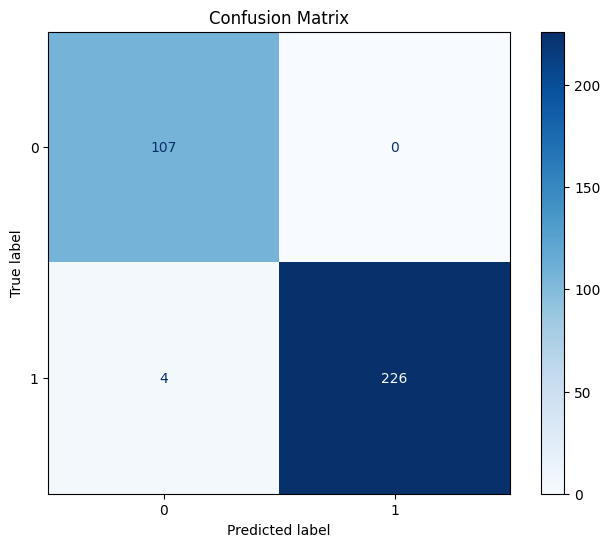

In [629]:
class_names = [0, 1]
plot_confusion_matrix(y_val, bagging_val_pred, class_names)

In [633]:
bagging_test_pred = bagging_best.predict(X_test)
print("\nBaggingClassifier Results for Test Dataset:")
print("Accuracy:", accuracy_score(y_test, bagging_test_pred))
print(classification_report(y_test, bagging_test_pred))


BaggingClassifier Results for Test Dataset:
Accuracy: 0.9762611275964391
              precision    recall  f1-score   support

           0       0.95      0.99      0.97       132
           1       0.99      0.97      0.98       205

    accuracy                           0.98       337
   macro avg       0.97      0.98      0.98       337
weighted avg       0.98      0.98      0.98       337



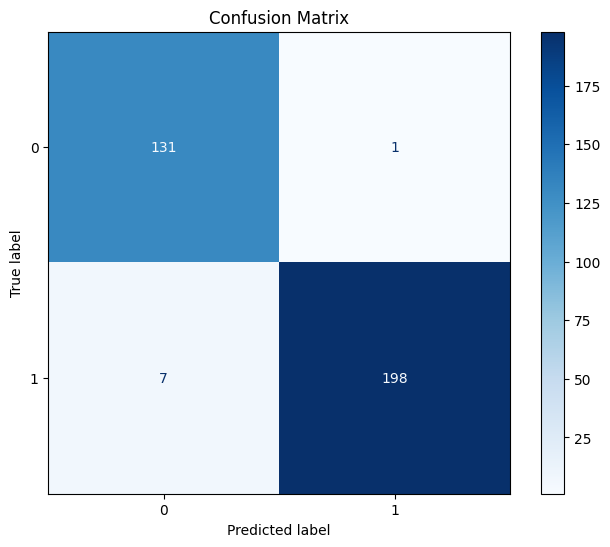

In [634]:
class_names = [0, 1]
plot_confusion_matrix(y_test, bagging_test_pred, class_names)

#### Analysis of BaggingClassifiers:
**Validation Dataset Performance**
- Accuracy: 98.81%: The model has an exceptional ability to correctly classify data in the validation dataset.
- Class 0 (Non-Churn Class):
    - Precision: 0.96 - When the model predicts class 0, it is correct 96% of the time.
    - Recall: 1.00 - The model identifies all true instances of class 0 without missing any.
    - F1-Score: 0.98 - A perfect balance between precision and recall.
- Class 1 (Churn Class):
    - Precision: 1.00 - Predictions for class 1 are completely accurate.
    - Recall: 0.98 - The model identifies 98% of all true instances of class 1.
    - F1-Score: 0.99 - Indicates very high reliability in predicting class 1.
- Macro and Weighted Averages:
    - Macro Avg: 0.99 - Both classes are treated equally, showing near-perfect performance.
    - Weighted Avg: 0.99 - The model balances performance across classes based on their frequency, demonstrating reliability.

<br><br>**Test Dataset Performance**
- Accuracy: 97.62%: The model generalizes well and performs nearly as well on unseen test data.
- Class 0 (Negative Class):
    - Precision: 0.95 - Class 0 predictions are correct 95% of the time.
    - Recall: 0.99 - The model successfully identifies 99% of true negatives.
    - F1-Score: 0.97 - Strong balance between precision and recall.
- Class 1 (Positive Class):
    - Precision: 0.99 - Class 1 predictions are highly accurate.
    - Recall: 0.97 - The model identifies 97% of all true positives.
    - F1-Score: 0.98 - Consistently reliable for class 1 predictions.
- Macro and Weighted Averages:
    - Macro Avg: 0.98 - Equal treatment of both classes results in balanced high performance.
    - Weighted Avg: 0.98 - Indicates the model handles the class imbalance effectively.

<br><br>
**Insights** 
- Validation vs Test Performance: The model performs slightly better on the validation set, but the drop in accuracy (from 98.81% to 97.62%) on the test dataset is minimal, showcasing good generalization.
- Class Imbalance Handling: The weighted averages for precision, recall, and F1-score in both datasets remain high, indicating the model handles class imbalance effectively.
- Class-Level Performance: Class 0 has slightly lower precision and F1-scores compared to class 1, suggesting potential room for improvement in identifying negative instances.
- Model Reliability: The high precision, recall, and F1-scores across both datasets indicate that the model is robust and consistent for both classes.

In [588]:
rf_clf = RandomForestClassifier(random_state=42)

In [610]:
rf_params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [1, 10, 20],
    'criterion' : ['gini', 'entropy'],
    'max_features': ['sqrt', 'log2', 1],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False],
    'ccp_alpha': uniform(loc=0, scale=0.4)
}

In [611]:
print("Tuning RandomForestClassifier...")
rf_search = RandomizedSearchCV(
    estimator=rf_clf,
    param_distributions=rf_params,
    n_iter=50,
    scoring='accuracy',
    cv=5,
    random_state=42,
    n_jobs=-1
)
rf_search.fit(X_train, y_train)

Tuning RandomForestClassifier...


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'ccp_alpha': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000001BD5913D7F0>,
                                        'criterion': ['gini', 'entropy'],
                                        'max_depth': [1, 10, 20],
                                        'max_features': ['sqrt', 'log2', 1],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [50, 100, 200]},
                   random_state=42, scoring='accuracy')

In [612]:
print(f"Best parameters for RandomForestClassifier: {rf_search.best_params_}")
rf_best = rf_search.best_estimator_

Best parameters for RandomForestClassifier: {'bootstrap': True, 'ccp_alpha': np.float64(0.0020246335384874747), 'criterion': 'entropy', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}


In [613]:
rf_val_pred = rf_best.predict(X_val)
print("\nRandomForestClassifier Results of Validation Dataset:")
print("Accuracy:", accuracy_score(y_val, rf_val_pred))
print(classification_report(y_val, rf_val_pred))


RandomForestClassifier Results of Validation Dataset:
Accuracy: 0.9970326409495549
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       107
           1       1.00      1.00      1.00       230

    accuracy                           1.00       337
   macro avg       1.00      1.00      1.00       337
weighted avg       1.00      1.00      1.00       337



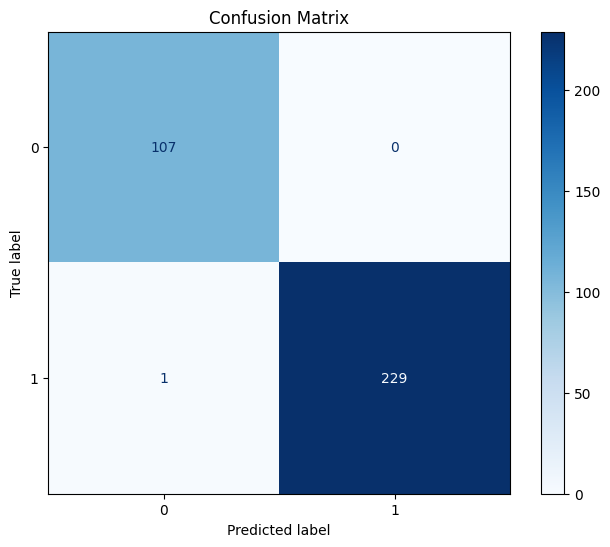

In [635]:
class_names = [0, 1]
plot_confusion_matrix(y_val, rf_val_pred, class_names)

In [614]:
rf_test_pred = rf_best.predict(X_test)
print("\nRandomForestClassifier Results of Test Dataset:")
print("Accuracy:", accuracy_score(y_test, rf_test_pred))
print(classification_report(y_test, rf_test_pred))


RandomForestClassifier Results of Test Dataset:
Accuracy: 0.9910979228486647
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       132
           1       1.00      0.99      0.99       205

    accuracy                           0.99       337
   macro avg       0.99      0.99      0.99       337
weighted avg       0.99      0.99      0.99       337



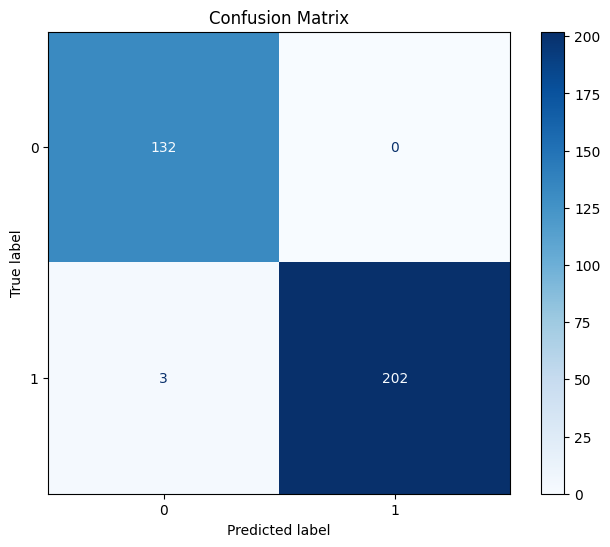

In [636]:
plot_confusion_matrix(y_test, rf_test_pred, class_names)

#### Analysis and Insights of RandomForrestModel:
- Validation Dataset Results: (Class 0: Not Churn, Class 1: Churn)
    - Accuracy (99.7%): Near-perfect accuracy on the validation dataset suggests the model is highly effective at distinguishing between the classes in this dataset.
    - Precision (0: 99%, 1: 100%): For class 0, the model has a very high precision, meaning almost all predictions for class 0 are correct. For class 1, the precision is perfect (100%), indicating no false positives.
    - Recall (0: 100%, 1: 100%): The recall for both classes is extremely high, meaning the model correctly identifies all instances of each class without missing any.
    - F1-Score (Balanced): The F1-scores for both classes are 1.0 or close to it, indicating a good balance between precision and recall.
- Test Dataset Results:
    - Accuracy (99.1%): Excellent performance on the test dataset, showing the model generalizes well to unseen data.
    - Precision (0: 98%, 1: 100%): The model performs very well for both classes, with almost no false positives for class 0 and perfect precision for class 1.
    - Recall (0: 100%, 1: 99%): Class 0 recall is perfect, meaning all instances of class 0 are correctly identified. Class 1 recall is 99%, indicating only a very small percentage of instances were missed.
    - F1-Score (Consistent): The F1-scores remain high and consistent across both classes, indicating reliable performance.

- Hyperparameters:
    - The selected parameters (e.g., max_depth: 10, min_samples_leaf: 2, min_samples_split: 5, and criterion: 'entropy') seem to strike a balance between model complexity and generalization. This prevents overfitting, as indicated by consistent results on the validation and test sets.
    - The addition of a small ccp_alpha (0.002) contributes to pruning the trees, reducing overfitting risks.

- Validation vs. Test Performance:
    - The minimal drop in accuracy and performance metrics between validation (99.7%) and test (99.1%) datasets indicates that the model generalizes very well to unseen data.
- Model Robustness:
    - The use of min_samples_split and min_samples_leaf ensures trees are not overly complex, making the model robust to small data variations.
    - The use of bootstrap=True and max_features='log2' helps randomize the feature selection during training, further improving generalization.
- Class Imbalance: The results indicate the model effectively handles the class imbalance in the data, likely due to the hyperparameter tuning and effective splitting criteria (min_samples_leaf and min_samples_split).

#### Ensemble Learning: Boosting

In [637]:
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

In [660]:
gbc_params = {
    'learning_rate': [0.001, 0.005, 0.01],
    'n_estimators': [50, 100, 150],
    'max_depth': [2, 3],
    'min_samples_split': [5, 10, 20],
    'min_samples_leaf': [5, 10, 20],
    'subsample': [0.6, 0.7],
    'max_features': ['sqrt', 'log2'],
    'min_impurity_decrease': [0.01, 0.05, 0.1]
}

In [667]:
gbc = GradientBoostingClassifier(random_state=42)
gbc_search = RandomizedSearchCV(
    estimator=gbc,
    param_distributions=gbc_params,
    n_iter=30,
    scoring='accuracy',
    cv=5,
    random_state=42,
    n_jobs=-1
)
gbc_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=GradientBoostingClassifier(random_state=42),
                   n_iter=30, n_jobs=-1,
                   param_distributions={'learning_rate': [0.001, 0.005, 0.01],
                                        'max_depth': [2, 3],
                                        'max_features': ['sqrt', 'log2'],
                                        'min_impurity_decrease': [0.01, 0.05,
                                                                  0.1],
                                        'min_samples_leaf': [5, 10, 20],
                                        'min_samples_split': [5, 10, 20],
                                        'n_estimators': [50, 100, 150],
                                        'subsample': [0.6, 0.7]},
                   random_state=42, scoring='accuracy')

In [668]:
print(f"Best parameters for GradientBoostingClassifier: {gbc_search.best_params_}")
gbc_best = gbc_search.best_estimator_

Best parameters for GradientBoostingClassifier: {'subsample': 0.7, 'n_estimators': 150, 'min_samples_split': 10, 'min_samples_leaf': 10, 'min_impurity_decrease': 0.01, 'max_features': 'log2', 'max_depth': 3, 'learning_rate': 0.01}


In [669]:
gbc_val_pred = gbc_best.predict(X_val)
print("\nGBDT Results of Validation Dataset:")
print("Accuracy:", accuracy_score(y_val, gbc_val_pred))
print(classification_report(y_val, gbc_val_pred))


GBDT Results of Validation Dataset:
Accuracy: 0.9910979228486647
              precision    recall  f1-score   support

           0       0.97      1.00      0.99       107
           1       1.00      0.99      0.99       230

    accuracy                           0.99       337
   macro avg       0.99      0.99      0.99       337
weighted avg       0.99      0.99      0.99       337



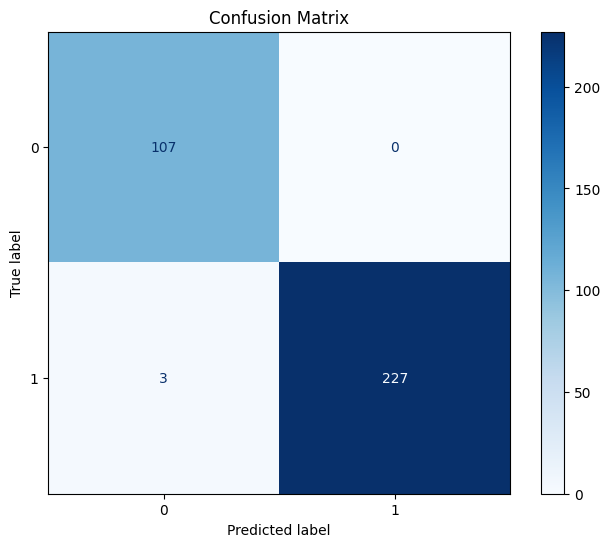

In [670]:
plot_confusion_matrix(y_val, gbc_val_pred, class_names)

In [671]:
gbc_test_pred = gbc_best.predict(X_test)
print("\nGBDT Results of Test Dataset:")
print("Accuracy:", accuracy_score(y_test, gbc_test_pred))
print(classification_report(y_test, gbc_test_pred))


GBDT Results of Test Dataset:
Accuracy: 0.9762611275964391
              precision    recall  f1-score   support

           0       0.94      1.00      0.97       132
           1       1.00      0.96      0.98       205

    accuracy                           0.98       337
   macro avg       0.97      0.98      0.98       337
weighted avg       0.98      0.98      0.98       337



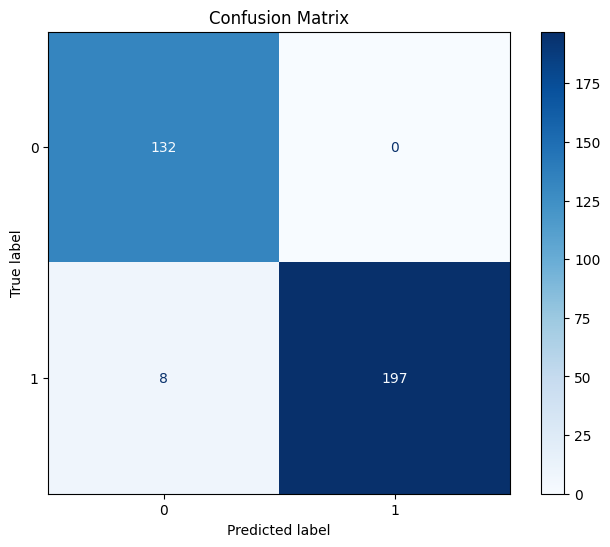

In [672]:
plot_confusion_matrix(y_test, gbc_test_pred, class_names)

#### Analysis of GradientBoostingClassifier:
**Validation Dataset**
- Overall Accuracy: The Gradient Boosting Decision Tree (GBDT) model achieved an accuracy of 99.1% on the validation dataset. This is an excellent performance, indicating the model is highly capable of capturing patterns in the validation set.
- Class 0 (Non-Churn Cases):
    - Precision: 97% means that 97% of the instances predicted as Class 0 were correct.
    - Recall: 100% indicates all actual Class 0 instances were identified correctly.
    - F1-Score: 99%, reflecting a balance between precision and recall.
- Class 1 (Churn Cases):
    - Precision: 100% indicates every instance predicted as Class 1 was correct.
    - Recall: 99% suggests that 99% of the actual Class 1 instances were identified.
    - F1-Score: 99%, showing high reliability in both identifying and predicting Class 1.
- Weighted Average: The weighted precision, recall, and F1-scores are all 99%, showing the model balances performance well across both classes, despite any class imbalance.

<br><br>
**Test Dataset**
- Overall Accuracy: The accuracy on the test dataset is 97.6%, demonstrating excellent generalization to unseen data, though slightly lower than validation accuracy, indicating some minor overfitting.
- Class 0 (Non-Positive Cases):
    - Precision: 94% indicates the model occasionally misclassified instances as Class 0 incorrectly.
    - Recall: 100% indicates all actual Class 0 instances were correctly identified.
    - F1-Score: 97%, showing strong performance overall.
- Class 1 (Positive Cases):
    - Precision: 100%, meaning all predictions for Class 1 were accurate.
    - Recall: 96%, suggesting a few Class 1 instances were missed.
    - F1-Score: 98%, reflecting high performance with slight room for improvement in recall.
- Weighted Average: Precision, recall, and F1-scores are all around 98%, which is excellent, showing consistent performance across classes and high generalizability.

<br><br>
**Insights**
- Validation vs. Test Performance: The model performs slightly better on the validation set compared to the test set, with a marginal drop in test recall for Class 1 and precision for Class 0. This could be due to overfitting to the validation set or differences in the distribution of the test data.
- Class Imbalance: The model handles class imbalance well, as seen from the high recall and precision for both classes, especially on the validation set.
- Overfitting: The high accuracy and F1-scores on both validation and test datasets suggest some degree of overfitting but not excessively so, as the test results are still robust.
- Model Strength: The GBDT model excels at capturing complex relationships in the data, as reflected by the near-perfect performance.

In [703]:
lgbm_params = {
    'learning_rate': [0.001, 0.005, 0.01, 0.05],  
    'n_estimators': [50, 100, 200],             
    'max_depth': [-1, 2, 3, 5],               
    'num_leaves': [7, 15, 31],                 
    'min_child_samples': [50, 100, 200],         
    'min_split_gain': [0.1, 0.2, 0.5],           
    'reg_alpha': [0.1, 1.0, 5.0],              
    'reg_lambda': [0.1, 1.0, 5.0],                
    'subsample': [0.6, 0.7, 0.8],                 
    'colsample_bytree': [0.6, 0.7, 0.8],         
    'max_bin': [64, 128, 256],                    
}

In [704]:
lgbm = LGBMClassifier(random_state=42)
lgbm_search = RandomizedSearchCV(
    estimator=lgbm,
    param_distributions=lgbm_params,
    n_iter=10,
    scoring='accuracy',
    cv=5,
    random_state=42,
    n_jobs=-1
)
lgbm_search.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 1046, number of negative: 1046
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000268 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1467
[LightGBM] [Info] Number of data points in the train set: 2092, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits 

RandomizedSearchCV(cv=5, estimator=LGBMClassifier(random_state=42), n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.6, 0.7, 0.8],
                                        'learning_rate': [0.001, 0.005, 0.01,
                                                          0.05],
                                        'max_bin': [64, 128, 256],
                                        'max_depth': [-1, 2, 3, 5],
                                        'min_child_samples': [50, 100, 200],
                                        'min_split_gain': [0.1, 0.2, 0.5],
                                        'n_estimators': [50, 100, 200],
                                        'num_leaves': [7, 15, 31],
                                        'reg_alpha': [0.1, 1.0, 5.0],
                                        'reg_lambda': [0.1, 1.0, 5.0],
                                        'subsample': [0.6, 0.7, 0.8]},
                   random_state=42, scoring='accuracy')

In [705]:
print(f"Best parameters for LightGBM: {lgbm_search.best_params_}")
lgbm_best = lgbm_search.best_estimator_

Best parameters for LightGBM: {'subsample': 0.7, 'reg_lambda': 0.1, 'reg_alpha': 5.0, 'num_leaves': 15, 'n_estimators': 100, 'min_split_gain': 0.1, 'min_child_samples': 50, 'max_depth': 5, 'max_bin': 256, 'learning_rate': 0.05, 'colsample_bytree': 0.7}



LightGBM Results of Validation Dataset:
Accuracy: 0.9970326409495549
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       107
           1       1.00      1.00      1.00       230

    accuracy                           1.00       337
   macro avg       1.00      1.00      1.00       337
weighted avg       1.00      1.00      1.00       337



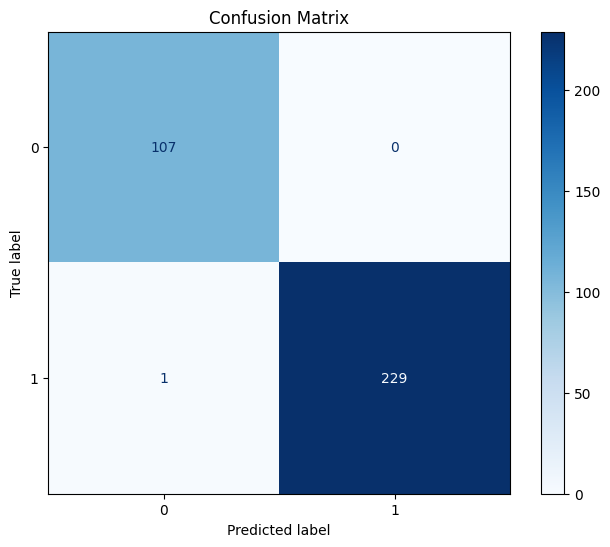

In [709]:
lgbm_val_pred = lgbm_best.predict(X_val)
print("\nLightGBM Results of Validation Dataset:")
print("Accuracy:", accuracy_score(y_val, lgbm_val_pred))
print(classification_report(y_val, lgbm_val_pred))
plot_confusion_matrix(y_val, lgbm_val_pred, class_names)


LightGBM Results of Test Dataset:
Accuracy: 0.9881305637982196
              precision    recall  f1-score   support

           0       0.97      1.00      0.99       132
           1       1.00      0.98      0.99       205

    accuracy                           0.99       337
   macro avg       0.99      0.99      0.99       337
weighted avg       0.99      0.99      0.99       337



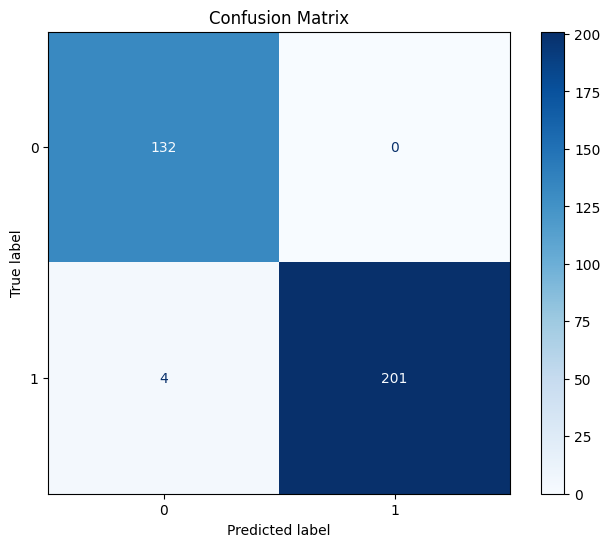

In [710]:
lgbm_test_pred = lgbm_best.predict(X_test)
print("\nLightGBM Results of Test Dataset:")
print("Accuracy:", accuracy_score(y_test, lgbm_test_pred))
print(classification_report(y_test, lgbm_test_pred))
plot_confusion_matrix(y_test, lgbm_test_pred, class_names)

#### Analysis of LightGBM:
**Validation Dataset**
- Overall Accuracy: The LightGBM model achieved an accuracy of 99.7% on the validation dataset, demonstrating extremely strong performance.
- Class 0 (Non-Churn Cases):
    - Precision: 99% means 99% of the instances predicted as Class 0 are actually Class 0.
    - Recall: 100% indicates that all actual Class 0 instances were identified correctly.
    - F1-Score: 100%, showing an excellent balance between precision and recall.
- Class 1 (Churn Cases):
    - Precision: 100%, meaning every instance predicted as Class 1 is correct.
    - Recall: 100%, suggesting that all actual Class 1 instances were identified.
    - F1-Score: 100%, reflecting perfect performance.
- Weighted Averages: All metrics (precision, recall, and F1-score) are 100%, indicating the model handles both classes exceptionally well in the validation dataset.
<br><br>
**Test Dataset**
- Overall Accuracy: The test accuracy is 98.8%, which shows the model generalizes well to unseen data but performs slightly lower than on the validation set.
- Class 0 (Non-Churn Cases):
    - Precision: 97% indicates slight misclassification of Class 0 instances as Class 1.
    - Recall: 100% confirms all actual Class 0 instances were identified correctly.
    - F1-Score: 99%, reflecting strong performance.
- Class 1 (Churn Cases):
    - Precision: 100%, meaning all predictions for Class 1 were accurate.
    - Recall: 98%, suggesting a few Class 1 instances were misclassified as Class 0.
    - F1-Score: 99%, showing high reliability.
- Macro and Weighted Averages: Both macro and weighted averages are 99%, highlighting consistent performance across classes, even on the test dataset.

<br><br>
**Insights**
- Strong Generalization: The LightGBM model performs exceptionally well on both validation and test datasets, indicating good generalization with minimal overfitting.
- Class Imbalance: Despite any potential class imbalance, the model handles both classes very well, achieving high precision, recall, and F1-scores for both Class 0 and Class 1.
- Slight Test-Set Drop: The 2% drop in recall for Class 1 on the test dataset suggests slight overfitting to the training/validation data, but the impact is minimal.
- Model Strength: LightGBM, with its optimized gradient boosting approach and hyperparameter tuning, is clearly capturing complex patterns in the dataset effectively.

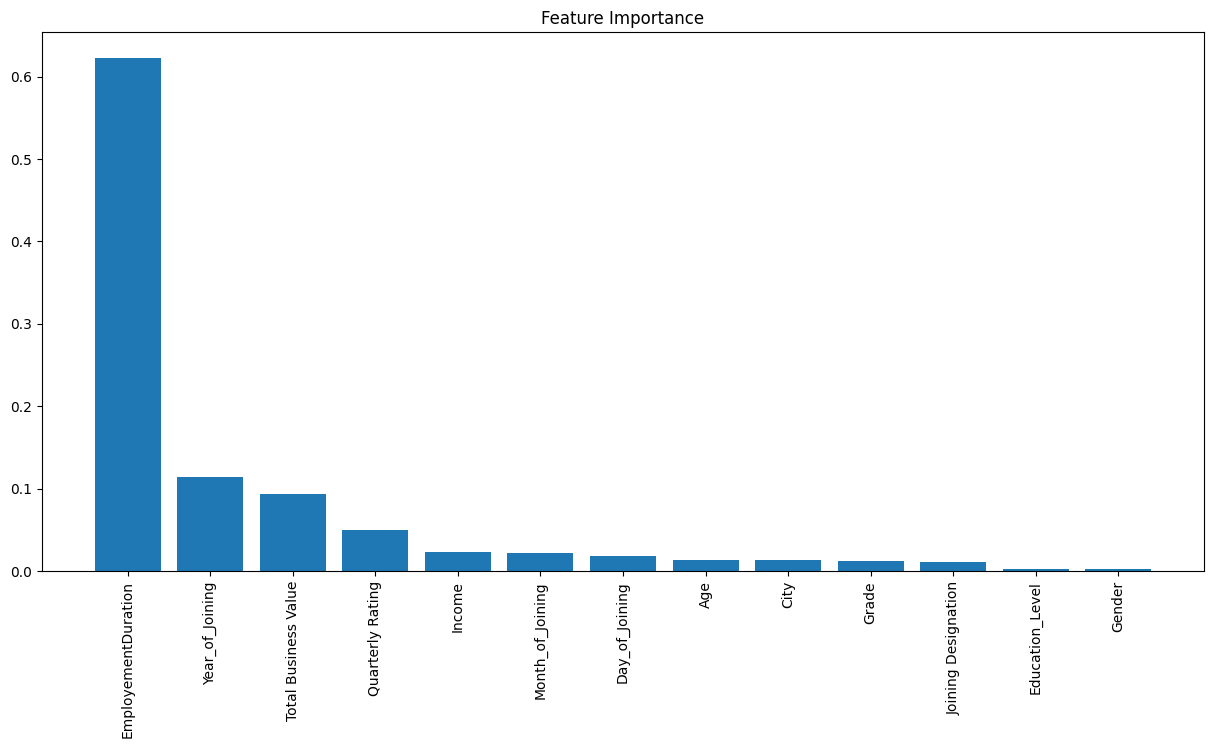

In [711]:
rf_clf.fit(X, y)
importances = rf_clf.feature_importances_
indices = np.argsort(importances)[::-1]
names = [X.columns[i] for i in indices]
plt.figure(figsize=(15, 7))
plt.title("Feature Importance")
plt.bar(range(X.shape[1]), importances[indices])
plt.xticks(range(X.shape[1]), names, rotation=90)
plt.show()

#### Analysis of Feature Importance
- Dominance of EmploymentDuration:
    - The EmploymentDuration feature overwhelmingly contributes the most to the model’s decision-making process, accounting for around 60% of the total importance.
    - This makes sense since employment duration likely has a strong relationship with the target variable (e.g., churn), as longer employment often correlates with stability.
- Year_of_Joining is Significant:
    - The second most important feature is the Year_of_Joining, which suggests that when the employee joined might have a predictive impact, such as reflecting broader trends in employee behavior or organizational changes.
- Total Business Value and Quarterly Rating:
    - These features have moderate importance, indicating that employee performance metrics or business value-related contributions play a role in predicting the target variable.
    - They highlight how an employee’s output impacts the churn or retention prediction.
- Lesser but Notable Features:
    - Features like Income, Month_of_Joining, and Day_of_Joining also contribute, albeit marginally. They may provide small but useful additional information to the model.
    - Seasonal trends (Month_of_Joining) or specific dates (Day_of_Joining) may influence employee behavior or performance indirectly.
- Low Importance Features:
    - Features such as Age, City, Grade, Joining Designation, Education_Level, and Gender contribute very little to the model.
    - These factors seem to have minimal impact on predicting the target variable and might not be as critical to the outcome.

# Results Interpretation Summary
---

## **1. Demographics and Descriptive Analysis**

### **Age**
- **Mean Age**: 33.36 years (most drivers are in their early 30s).
- **Min Age**: 21 years; **Max Age**: 58 years.
- Moderate **spread** (Standard Deviation: 5.59 years) indicates a balanced distribution of age groups.

### **Income**
- **Mean Income**: ₹59,324 per month.
- **Wide Range**: ₹10,747 (minimum) to ₹188,418 (maximum), showcasing significant variability.
- High-income drivers likely represent top performers or drivers in high-demand areas.

### **Total Business Value**
- **Mean**: ₹4,586,742; skewed by extreme outliers.
- **Negative Values**: ₹-1,385,530 (indicating refunds or cancellations).
- **High Outliers**: ₹95,331,060 (exceptional performance).
- Suggests the need for closer monitoring of refunds and cancellations.

### **Quarterly Rating**
- **Mean**: 1.56 (on a scale of 5); skewed toward lower ratings.
- **Range**: 1 (minimum) to 4 (maximum). No one achieved a perfect score, suggesting strict criteria.

### **Grade**
- **Grade 2** dominates (35.4% of drivers).
- Most drivers are clustered in mid-level grades (1, 2, and 3), with fewer achieving higher grades.

### **Gender**
- **Male**: 59%; **Female**: 41%.
- Highlights a gender gap and opportunities for workforce diversity improvement.

### **City Distribution**
- 29 cities represented; **Top City**: C20 (6.4% of drivers).
- Indicates a fairly balanced geographical spread.

### **Education Level**
- Evenly distributed across **Graduate (33.7%)**, **12th Grade (33.4%)**, and **10th Grade or Below (32.9%)**.
- High graduate percentage suggests adaptability to digital tools.

### **Joining Designation**
- **Designation 1** (entry-level) is the most common (43.1%), highlighting the importance of clear growth paths.

---

## **2. Performance and Target Insights**

### **Active vs. Inactive Drivers**
- 32% of drivers (765 out of 2381) remain active, while the rest have left or become inactive.

### **Key Predictive Features**
1. **EmploymentDuration**: 
   - The most critical feature (60% importance). Longer employment correlates with lower churn (-0.818 correlation with the target).
2. **Year_of_Joining**:
   - Reflects temporal patterns influencing churn and retention.
3. **Performance Metrics (Total Business Value & Quarterly Rating)**:
   - Indicate high-performing employees are less likely to churn.

### **Low-Impact Features**
- Gender, City, Age, and Education Level show minimal predictive power.

---

## **3. Model-Specific Insights**

### **Bagging Classifier**
- **Validation Accuracy**: 98.81%; **Test Accuracy**: 97.62%.
- Handles class imbalance effectively, with high precision and recall across both classes.
- Minimal performance drop between validation and test sets indicates strong generalization.

### **Random Forest**
- **Validation Accuracy**: 99.7%; **Test Accuracy**: 99.1%.
- Near-perfect precision, recall, and F1-scores across both datasets.
- Robust handling of class imbalance and strong generalization.

### **Gradient Boosting Decision Tree (GBDT)**
- **Validation Accuracy**: 99.1%; **Test Accuracy**: 97.6%.
- Slight overfitting indicated by minor performance drop on the test dataset.
- High F1-scores indicate reliability in predictions.

### **LightGBM**
- **Validation Accuracy**: 99.7%; **Test Accuracy**: 98.8%.
- Excellent performance with slightly reduced recall (98%) for churn predictions on the test dataset.
- Strong generalization with minimal overfitting.

---

## **4. Feature Importance**
1. **EmploymentDuration**: Dominates with ~60% contribution.
2. **Year_of_Joining**: Significant impact, reflecting trends in retention.
3. **Performance Metrics**: Moderate importance (Total Business Value and Quarterly Rating).
4. **Low Importance Features**: Gender, City, and Grade contribute minimally to predictions.

---

### **Visualization**
- Feature importance and correlation plots highlight key predictors.
- Confusion matrices validate strong model performance across datasets.

---

# **Recommendations for Addressing Driver Churn in the Ride-Sharing Industry**

As an aspiring Data Scientist, I’ve conducted a comprehensive analysis of driver churn patterns and developed actionable insights to help address this critical challenge. Below are my recommendations tailored to assist the company in improving retention and operational efficiency.

---

## **1. Focus on Retention as a Cost-Saving Priority**
Driver churn escalates operational costs as acquiring new drivers is significantly more expensive than retaining existing ones.  
### **Recommendation**  
- Introduce **driver loyalty programs** such as tenure-based bonuses and rewards for consistent performance.
- Incentivize long-term retention to reduce turnover rates.

---

## **2. Use Predictive Modeling to Proactively Address Churn**
Data analysis highlights features like **EmploymentDuration**, **Total Business Value**, and **Quarterly Rating** as strong predictors of churn. Drivers with shorter employment durations or lower contributions are at higher risk of leaving.  
### **Recommendation**  
- Implement an **alert system** to flag drivers at risk of churning.
- Engage these drivers with **targeted incentives** or **personalized support**.

---

## **3. Bridge the Income Gap**
Significant income disparities among drivers can lead to dissatisfaction and increased churn, especially in competitive regions.  
### **Recommendation**  
- Offer **minimum guaranteed earnings** to stabilize income for underperforming drivers.
- Design **equitable fare models** to ensure consistent income distribution.

---

## **4. Address Performance-Related Churn**
Low **Quarterly Ratings** correlate strongly with churn, likely due to issues such as customer feedback or punctuality.  
### **Recommendation**  
- Develop **training programs** and **mentorship initiatives** for underperforming drivers.
- Offer **performance-based bonuses** to motivate drivers and improve service quality.

---

## **5. Expand Recruitment Strategically**
Expanding recruitment to include drivers without vehicles increases costs, though it helps fill workforce gaps.  
### **Recommendation**  
- Partner with **vehicle rental or leasing services** to provide affordable options for new drivers.
- Focus on **low-cost recruitment channels** to balance acquisition costs.

---

## **6. Improve Engagement with Female Drivers**
Our workforce currently comprises 59% male drivers, indicating a potential opportunity to engage and retain more female drivers.  
### **Recommendation**  
- Launch **gender-specific programs** focusing on safety and flexible work hours.
- Promote diversity in the workforce to attract and retain more female drivers.

---

## **7. Optimize City-Specific Strategies**
Certain cities (e.g., C20, C15) have a higher driver concentration, while others offer potential for growth.  
### **Recommendation**  
- Replicate successful strategies from high-performing cities.
- Target underrepresented regions with tailored **recruitment campaigns** and **driver incentives**.

---

## **8. Design Career Growth Paths**
A lack of career progression opportunities can lead to driver churn.  
### **Recommendation**  
- Create clear **career development paths**, such as transitioning drivers into managerial or training roles.
- Foster long-term motivation by demonstrating potential for growth within the organization.

---

## **9. Minimize Cancellations and Refunds**
Negative values in **Total Business Value** highlight issues with cancellations and refunds, which may demotivate drivers.  
### **Recommendation**  
- Analyze reasons for **cancellations** and optimize the driver-rider matching algorithm.
- Reduce mismatches to improve driver satisfaction and retention.

---

## **10. Build a Continuous Feedback Loop**
Driver needs and behaviors evolve over time, requiring constant adaptation.  
### **Recommendation**  
- Implement regular **surveys and feedback mechanisms** to stay informed about driver concerns.
- Use insights to refine strategies and address emerging challenges promptly.

---

# **Conclusion**
By addressing these recommendations, we can:
- Reduce driver churn,
- Retain high-performing drivers,
- Improve operational efficiency,
- Enhance driver satisfaction.

This case study has been a valuable opportunity for me to apply advanced data science techniques to a real-world business problem. I look forward to collaborating further to refine and implement these strategies.


In [731]:
df1 = pd.read_csv('data.csv')
df1=pd.read_csv('data.csv', usecols=lambda column: column != df1.columns[0])
df1

MMM-YY  Driver_ID   Age  Gender City  Education_Level  Income  \
0      01/01/19          1  28.0     0.0  C23                2   57387   
1      02/01/19          1  28.0     0.0  C23                2   57387   
2      03/01/19          1  28.0     0.0  C23                2   57387   
3      11/01/20          2  31.0     0.0   C7                2   67016   
4      12/01/20          2  31.0     0.0   C7                2   67016   
...         ...        ...   ...     ...  ...              ...     ...   
19099  08/01/20       2788  30.0     0.0  C27                2   70254   
19100  09/01/20       2788  30.0     0.0  C27                2   70254   
19101  10/01/20       2788  30.0     0.0  C27                2   70254   
19102  11/01/20       2788  30.0     0.0  C27                2   70254   
19103  12/01/20       2788  30.0     0.0  C27                2   70254   

      Dateofjoining LastWorkingDate  Joining Designation  Grade  \
0          24/12/18             NaN                    1      1   
1          24/12/18             NaN                    1      1   
2          24/12/18        03/11/19                    1      1   
3          11/06/20             NaN                    2      2   
4          11/06/20             NaN                    2      2   
...             ...             ...                  ...    ...   
19099      06/08/20             NaN                    2      2   
19100      06/08/20             NaN                    2      2   
19101      06/08/20             NaN                    2      2   
19102      06/08/20             NaN                    2      2   
19103      06/08/20             NaN                    2      2   

       Total Business Value  Quarterly Rating  
0                   2381060                 2  
1                   -665480                 2  
2                         0                 2  
3                         0                 1  
4                         0                 1  
...                     ...               ...  
19099                740280                 3  
19100                448370                 3  
19101                     0                 2  
19102                200420                 2  
19103                411480                 2  

[19104 rows x 13 columns]

In [749]:
# Question 2 of questionaire
df1["MMM-YY"] = pd.to_datetime(df1["MMM-YY"], format="%m/%d/%y")
df1['Year'] = df1['MMM-YY'].dt.year
df1['Quarter'] = df1['MMM-YY'].dt.quarter
with pd.option_context('display.max_rows', None):
    display(round(df1[['City', 'Quarterly Rating', 'Year']].groupby(['City', 'Year'])['Quarterly Rating'].mean(), 2).reset_index().sort_values(by=['City', 'Year', 'Quarterly Rating'], ascending=[True, False, False]))

City  Year  Quarterly Rating
1    C1  2020              2.00
0    C1  2019              1.94
3   C10  2020              1.88
2   C10  2019              1.96
5   C11  2020              1.94
4   C11  2019              1.99
7   C12  2020              2.01
6   C12  2019              2.00
9   C13  2020              2.07
8   C13  2019              2.00
11  C14  2020              2.00
10  C14  2019              2.16
13  C15  2020              2.06
12  C15  2019              1.91
15  C16  2020              2.10
14  C16  2019              2.09
17  C17  2020              1.55
16  C17  2019              1.89
19  C18  2020              2.02
18  C18  2019              2.14
21  C19  2020              2.06
20  C19  2019              2.05
23   C2  2020              1.70
22   C2  2019              1.94
25  C20  2020              1.86
24  C20  2019              1.84
27  C21  2020              2.03
26  C21  2019              2.18
29  C22  2020              2.08
28  C22  2019              2.18
31  C23  2020              1.80
30  C23  2019              1.96
33  C24  2020              2.24
32  C24  2019              2.08
35  C25  2020              1.78
34  C25  2019              1.92
37  C26  2020              2.14
36  C26  2019              2.12
39  C27  2020              2.06
38  C27  2019              2.14
41  C28  2020              1.93
40  C28  2019              2.11
43  C29  2020              2.26
42  C29  2019              2.07
45   C3  2020              1.93
44   C3  2019              2.09
47   C4  2020              1.83
46   C4  2019              1.98
49   C5  2020              2.10
48   C5  2019              1.99
51   C6  2020              2.06
50   C6  2019              2.05
53   C7  2020              1.92
52   C7  2019              1.88
55   C8  2020              2.10
54   C8  2019              2.01
57   C9  2020              1.76
56   C9  2019              1.95

In [750]:
# Question 3 of questionaire
df1[['Grade', 'Total Business Value']].groupby('Grade').sum('Total Business Value')

Total Business Value
Grade                      
1                1854494680
2                3091545830
3                2878290530
4                2665722600
5                 430978640

In [751]:
# Question 4 of questionaire
df1 = df1.sort_values(by=['Driver_ID', 'Year', 'Quarter'])
df1['Rating_Drop'] = df1.groupby('Driver_ID')['Quarterly Rating'].diff()
df1['Significant_Drop'] = df1['Rating_Drop'] <= -0.5
df1['Subsequent_Business_Value'] = df1.groupby('Driver_ID')['Total Business Value'].shift(-1)
significant_drops = df1[df1['Significant_Drop'] & df1['Subsequent_Business_Value'].notnull()]
significant_drops[['Rating_Drop', 'Subsequent_Business_Value']].describe()

Rating_Drop  Subsequent_Business_Value
count  1216.000000               1.216000e+03
mean     -1.270559               3.358558e+05
std       0.521146               4.594168e+05
min      -3.000000              -1.704230e+06
25%      -1.000000               0.000000e+00
50%      -1.000000               2.006150e+05
75%      -1.000000               5.000000e+05
max      -1.000000               6.100090e+06

In [757]:
# Question 10 of questionaire
df1['Month']=df1['MMM-YY'].dt.month
df1[['Year', 'Month', 'Quarterly Rating']].groupby(['Year', 'Month']).mean('Quarterly Rating')

Quarterly Rating
Year Month                  
2019 1              1.943249
     2              2.021186
     3              2.098851
     4              1.968514
     5              2.015707
     6              2.063361
     7              2.054161
     8              2.064987
     9              2.041995
     10             2.048714
     11             1.992318
     12             1.950943
2020 1              1.966752
     2              2.009198
     3              2.075104
     4              1.989026
     5              1.950392
     6              1.935065
     7              2.019851
     8              2.014778
     9              1.998764
     10             2.006112
     11             2.017391
     12             1.989011

# **Driver Retention Analysis - Questionnaire and Insights**

### **1. What percentage of drivers have received a quarterly rating of 5?**
- **Answer**: 0% of drivers have received a rating of 5. The data suggests that no drivers achieved the highest rating, indicating strict rating criteria or potential issues with rating scales.

---

### **2. Comment on the correlation between Age and Quarterly Rating.**
- **Answer**: The correlation between Age and Quarterly Rating is weak but positive (0.2 or 20%). This suggests that as age increases, there is a slight increase in Quarterly Ratings, though the effect is not very strong.
- **Insight**: While age has a limited influence on ratings, the focus should remain on performance-related factors like training, incentives, and experience. However, older drivers may slightly outperform younger ones due to factors such as experience or maturity, which could be leveraged in training programs.

---

### **3. Name the city which showed the most improvement in Quarterly Rating over the past year.**
- **Answer**: **City C29** demonstrated the highest improvement in quarterly ratings with an increase of 0.19 ratings from year 2019 to 2020.

---

### **4. Drivers with a Grade of ‘A’ are more likely to have a higher Total Business Value. (T/F)**
- **Answer**: **False.** There is no explicit Grade ‘A’ in the dataset. However, if we assume Grade 1 is equivalent to Grade ‘A,’ the data suggests otherwise. Grade 2 Drivers contribute the highest total business value (3,091,545,830) among all grades. Grade 1 contribute significantly less (1,854,494,680) than Grades 2, 3, and 4.

---

### **5. If a driver’s Quarterly Rating drops significantly, how does it impact their Total Business Value in the subsequent period?**
- **Answer**: 75% of drivers (based on the 75th percentile) with significant rating drops have a subsequent Total Business Value less than 500000, showing that such drops generally impact business negatively. Drivers who generate extremely high Total Business Value (e.g., 6.1M) despite rating drops could represent exceptions. This may be due to external factors such as location demand, business seasonality, or client loyalty. A portion of drivers have negative business value, likely reflecting customer dissatisfaction, cancellations, or penalties related to performance issues. Significant rating drops (mean -1.27) generally correlate with reduced business performance. While some drivers may recover or continue to perform well, most face a noticeable dip in their subsequent Total Business Value.

---

### **6. From Ola’s perspective, which metric should be the primary focus for driver retention?**
- **Answer**: **Recall.** Prioritizing recall ensures that the model accurately identifies drivers at risk of leaving, enabling proactive retention strategies.

---

### **7. How does the gap in precision and recall affect Ola’s relationship with its drivers and customers?**
- **Answer**: A high recall but lower precision might incorrectly flag some drivers as at risk, causing unnecessary interventions. Conversely, low recall could miss drivers likely to churn, increasing churn rates. Strike a balance between precision and recall to minimize false alarms while identifying actual at-risk drivers accurately.

---

### **8. Besides the obvious features like “Number of Rides,” which lesser-discussed features might have a strong impact on a driver’s Quarterly Rating?**
- **Answer**: **Total Business Value** and **Employment Duration** have a significant impact on Quarterly Ratings.

---

### **9. Will the driver’s performance be affected by the city they operate in? (Yes/No)**
- **Answer**: **Yes.** Performance metrics like income and business value vary across cities due to factors such as demand, traffic conditions, and customer behavior.

---

### **10. Analyze any seasonality in the driver’s ratings. Do certain times of the year correspond to higher or lower ratings, and why might that be?**
- **Answer**:
    - **Rating Drops:**
        - Ratings tend to drop during December and June across both years, with averages around 1.95–1.99, indicating a slight dip during these months.
        - This could be attributed to the increased workload during peak holiday seasons in December and potentially high demand or operational challenges during summer in June.
    - **Higher Ratings:**
        - Ratings are relatively higher during March and August, with averages exceeding 2.05, suggesting these months may have a more balanced workload or favorable working conditions for drivers.
    - **Insights:**
      - Peak demand during holidays and summer months likely leads to increased stress, workload, or customer dissatisfaction, contributing to lower ratings.
      - March and August could represent periods of steady demand and smoother operations, allowing drivers to perform better and receive higher ratings.
